In [99]:
import io
from nbformat import current
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')
        word_count = 0
        for cell in nb.worksheets[0].cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count
nb_word_count('MSIN0143_2020_GROUP_K2.ipynb') #with the Appendix and References

2630

<div class="image">

  <img style="float: right;" src="https://mms.businesswire.com/media/20200722005444/en/807306/5/Spotify_Logo_RGB_Green%5B2%5D.jpg?download=1" width="40%" align="right">
     <h4>
          <p style="font-size:32pt">MSIN0143 Coursework </p>
         <br>
          <p style="font-size:20pt; color: #1DB954">Group K2</p>
     </h4>
</div>

<h3>Table of Content</h3>

* [1. Introduction](#1.-Introduction)
* [2. Dataset Description](#2.-Dataset-Description)
* [3. Data Preparation and Cleaning](#3.-Data-Preparation-and-Cleaning)
* [4. Exploratory and Descriptive Analyis](#4.-Exploratory-and-Descriptive-Analysis)
    * [4.1 Artist Analysis](#4.1-Artists-Analysis)
    * [4.2 Songs Analysis](#4.2-Songs-Analysis)
    * [4.3 Audio Features Analysis](#4.3-Audio-Features-Analysis)
* [5. Linear Regression Model](#5.-Linear-Regression-Model)
* [6. Popularity Prediction Modell](#6.-Popularity-Prediction-Model)
* [7. Summary](#7.-Summary)
* [8. References](#8.-References)
* [9. Appendix](#9.-Appendix)
    

# 1. Introduction

Spotify is a digital music, podcast, and video streaming subscription service with 320m users, including 144m subscribers across 92 markets. According to “Business of Apps”, in the first quarter of 2020, Spotify recorded 286 million monthly active users, 130 million of which were Premium subscribers. Those figures allow the platform to claim 35% market share.

Using Spotify dataset including audio features of 160k+ songs released between 1921 and 2020, the goal of this project is to analyze the trends of top songs and artists, as well as to identify what makes a song popular on Spotify. 

In particular, the focus will be on the following topics: 
- Popular Artists
- Popular Songs 
- Audio Features Trends
- Regression Analysis for identification of the most important features that impact song popualrity score 
- Popularity Prediction Model 


The dataset is collected from Spotify Web API and can be found on [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks).

<br>
<br>

In [2]:
# Importing relevant modules
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%autosave 120
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #plotting graphs 
import matplotlib as mpl 
import seaborn as sns # used for plot interactive graph.
from tqdm import tqdm # for dates converting
from datetime import datetime # for dates converting
import calendar # for dates converting
# statistical analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
# for the prediction model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse # For scoring
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Autosaving every 120 seconds


# 2. Dataset Description

In [3]:
#reading the datafile into a dataframes
dfbeforeCleaning = pd.read_csv('data.csv')


## 2.1 Data Attributes


**Numerical Variables:**

|**Variable**   |  **Description**  |
|:---| :---|
| **`ID`** | ID generated by Spotify |
| **`Acousticness`** | **`(Ranges from 0-1)`** - A measure of how acoustic a track is, the closer the value is to 1, the more acoustic the track is. |
| **`Dancability`** | **`(Ranges from 0-1)`** - A combination of musical elements to identify how suitable a track is for dancing. |
| **`Duration_ms`** | Length of the song in miliseconds|
| **`Instrumentalness`** | **`(Ranges from 0-1)`** - A variable indicating if a track has vocals. The closer to 1, the more instrumental it is. |
| **`Valence`** | **`(Ranges from 0-1)`** - Measure of how positive a track is.|
| **`Popularity`** | **`(Ranges from 0-100)`** - How popular a song is based on the total number of plays alongside how recent the plays are.|
| **`Tempo`** | **`(Float variable from 50 to 150)`** - The overall pace of the track
| **`Liveness `** | **`(Ranges from 0-1)`** - Predicting if audience is present in a track. The closer to 1, the higher the likelihood.|
| **`Loudness`** | **`(Float ranging from -60 to 0)`**  - How loud a track is in decibels (dB). Loudness values in a track are averaged to get this value.|
| **`Speechiness `** | **`(Ranges from 0-1)`** -Indicating if a track has words. The closer it is to 1, the more likely it is to have or be exclusively having words .|
| **`Year`** | **`(Ranges from 1921-2020)`**  - Year which the song is released.|
| **`Energy`** | **`(Ranges from 0-1)`**  - Represents a the intensity and level of activity. As the track moves closer to one, the more loud and fast it is.|

**Dummy Variables:**

|**Variable**   |  **Description**  |
|:---| :---|
| **`Mode`** | **`(Binary values, 0 = Minor, 1 = Major)`**  - Type of scale for the track.|
| **`Explicit`** | **`(Binary values, 0 = No explicit content, 1 = Explicit content)`** - If a song is explicit or not.|



**Categorical Variables:**

|**Variable**   |  **Description**  |
|:---| :---|
| **`Key`** |**`(Octave keys - values ranging from 0 to 11. C = 0, C# = 1, so on)`**  - Estimated overall key of the track. Values are mapped to pitches according to standard Pitch Class notation..|
| **`Artists`** | Name of the artists.|
| **`Name`** | Name of the song.|
| **`Relase_date`** |**`(Date of release mostly in yyyy-mm-dd format)`**  - Shows release date of song.|


The description of the variables are from the following sources : 
1. https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/
     
2. https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/

In [4]:
#Checking dataset variables and types 
dfbeforeCleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

In [5]:
#checking how many enteries and rows
dfbeforeCleaning.shape

(169909, 19)

# 3. Data Preparation and Cleaning

**1) Checking null variables**

In [6]:
# Check for missing values
dfbeforeCleaning.isna().sum()
#No missing values were found.

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

**2) Checking values formats**

In [7]:
#Checking Values Formats
dfbeforeCleaning.head(4)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928


**3) Remove square bracket and quotation marks from artist's name**

In [8]:
dfbeforeCleaning.head(1)
dfbeforeCleaning['artists'] = dfbeforeCleaning['artists'].apply(lambda x: x[1:-1].replace("'", ''))
dfbeforeCleaning.head(1)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.195,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.151,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.779,1928


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,Carl Woitschach,0.708,158648,0.195,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.151,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.779,1928


**4) Convert duration into minutes**

In [9]:
dfbeforeCleaning['duration_min'] = (dfbeforeCleaning['duration_ms']/60000).round(2)

# and delete the previous one
dfbeforeCleaning.drop(['duration_ms'],inplace=True,axis=1)

dfbeforeCleaning.head(1)

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_min
0,0.995,Carl Woitschach,0.708,0.195,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.151,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.779,1928,2.64


**5) Change dates in the release_date column to the same format**
<br> The release date values  are not consistent with  YYYY-MM-DD  format with 43% of values containing year only and 1% with a month and year.  The below fills those values with the mean date.

In [10]:
# to create new dataframes with incomplete release dates
df_only_y = dfbeforeCleaning[dfbeforeCleaning['release_date'].apply(lambda x: len(x) == 4)] # release dates with a year only
df_only_m_y = dfbeforeCleaning[dfbeforeCleaning['release_date'].apply(lambda x: len(x) == 7)] # release dates with a year and month only

# to delete the rows with incomplete release dates from the main dataframe
dfbeforeCleaning = dfbeforeCleaning[dfbeforeCleaning['release_date'].map(len) > 7]

# to correct release_date data type in the main dataframe
dfbeforeCleaning['release_date'] = pd.to_datetime(dfbeforeCleaning['release_date'])

In [11]:
# the percentage of songs with missing days and months
ratio_y = df_only_y['release_date'].count() / dfbeforeCleaning['release_date'].count()
round(ratio_y * 100)
# the percentage of songs with missing days
ratio_m_y = df_only_m_y['release_date'].count() / dfbeforeCleaning['release_date'].count()
round(ratio_m_y * 100)

43.0

1.0

In [12]:
#Firstly, the functions that find mean values based on a year or a year and a month were defined.
# to find mean release date based on a year
def mean_date_y(year):
    start_date = str(year) + "-1-1"
    end_date = str(year) + "-12-31"
    period = dfbeforeCleaning[(dfbeforeCleaning["release_date"] >= start_date) & (dfbeforeCleaning["release_date"] <= end_date)]
    return (np.mean(period["release_date"])).strftime('%Y-%m-%d') # to convert into YYYY-MM-DD format


# to find mean release date based on a year and month
def mean_date_y_m(year, month):
    leap_year = list(range(1920, 2020, 4))
    day = "-" + str(list(calendar.monthrange(year,month))[-1])
    # if month is February in an ordinary year
    if month == 2 and year not in leap_year:
        start_date = str(year) + "-" + str(month) + "-1"
        end_date = str(year) + "-" + str(month) + day
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
        print("start_date", start_date)
        print("end_date", end_date)
        period = dfbeforeCleaning[(dfbeforeCleaning["release_date"] >= start_date) & (dfbeforeCleaning["release_date"] <= end_date)]
    # if month is February in a leap year
    elif month == 2 & year in leap_year:
        start_date = str(year) + "-" + str(month) + "-1"
        end_date = str(year) + "-" + str(month) + day
        print("start_date", start_date)
        print("end_date", end_date)
        period = dfbeforeCleaning[(dfbeforeCleaning["release_date"] >= start_date) & (dfbeforeCleaning["release_date"] <= end_date)]
    # if month is April, June, September, or November   
    elif month == 4 or month == 6 or month == 9 or month ==11:
        start_date = str(year) + "-" + str(month) + "-1"
        end_date = str(year) + "-" + str(month) + day
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
        print("start_date", start_date)
        print("end_date", end_date)
        period = dfbeforeCleaning[(dfbeforeCleaning["release_date"] >= start_date) & (dfbeforeCleaning["release_date"] <= end_date)]
        
    else:
        start_date = str(year) + "-" + str(month) + "-1"
        end_date = str(year) + "-" + str(month) + day
        print("start_date", start_date)
        print("end_date", end_date)
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
        period = dfbeforeCleaning[(dfbeforeCleaning["release_date"] >= start_date) & (dfbeforeCleaning["release_date"] <= end_date)]
        
    return (np.mean(period["release_date"])) # to convert into YYYY-MM-DD format


In [13]:
#Replacing missing values by the mean values.
# to replace inappropriate data in df_only_y with mean values of a year
years = range(1921,2021)
for y in years:
    df_only_y['release_date'] = df_only_y['release_date'].replace(str(y), mean_date_y(y))

In [14]:
# to create a loop and cover all possible dates
months = range(1,13)
for year in tqdm(years):
    for month in tqdm(months):
        mean_date_y_m(year,month)

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1921-1-1
end_date 1921-1-31


NaT

start_date 1921-02-01 00:00:00
end_date 1921-02-28 00:00:00


Timestamp('1921-02-20 00:00:00')

start_date 1921-3-1
end_date 1921-3-31


Timestamp('1921-03-20 07:38:10.909090816')

start_date 1921-04-01 00:00:00
end_date 1921-04-30 00:00:00


Timestamp('1921-04-12 00:00:00')

start_date 1921-5-1
end_date 1921-5-31


NaT

start_date 1921-06-01 00:00:00
end_date 1921-06-30 00:00:00


NaT

start_date 1921-7-1
end_date 1921-7-31


NaT

start_date 1921-8-1
end_date 1921-8-31


NaT

start_date 1921-09-01 00:00:00
end_date 1921-09-30 00:00:00


Timestamp('1921-09-11 00:00:00')

start_date 1921-10-1
end_date 1921-10-31


NaT

start_date 1921-11-01 00:00:00
end_date 1921-11-30 00:00:00


NaT

start_date 1921-12-1
end_date 1921-12-31


Timestamp('1921-12-18 00:00:00')

100%|██████████| 12/12 [00:00<00:00, 197.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1922-1-1
end_date 1922-1-31


NaT

start_date 1922-02-01 00:00:00
end_date 1922-02-28 00:00:00


Timestamp('1922-02-22 00:00:00')

start_date 1922-3-1
end_date 1922-3-31


Timestamp('1922-03-25 02:27:41.538461440')

start_date 1922-04-01 00:00:00
end_date 1922-04-30 00:00:00


NaT

start_date 1922-5-1
end_date 1922-5-31


NaT

start_date 1922-06-01 00:00:00
end_date 1922-06-30 00:00:00


NaT

start_date 1922-7-1
end_date 1922-7-31


NaT

start_date 1922-8-1
end_date 1922-8-31


NaT

start_date 1922-09-01 00:00:00
end_date 1922-09-30 00:00:00


NaT

start_date 1922-10-1
end_date 1922-10-31


NaT

start_date 1922-11-01 00:00:00
end_date 1922-11-30 00:00:00


NaT

start_date 1922-12-1
end_date 1922-12-31


NaT

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1923-1-1
end_date 1923-1-31


Timestamp('1923-01-04 00:00:00')

start_date 1923-02-01 00:00:00
end_date 1923-02-28 00:00:00


NaT

start_date 1923-3-1
end_date 1923-3-31


Timestamp('1923-03-28 19:12:00')

start_date 1923-04-01 00:00:00
end_date 1923-04-30 00:00:00


NaT

start_date 1923-5-1
end_date 1923-5-31


NaT

start_date 1923-06-01 00:00:00
end_date 1923-06-30 00:00:00


NaT

start_date 1923-7-1
end_date 1923-7-31


Timestamp('1923-07-09 00:00:00')

start_date 1923-8-1
end_date 1923-8-31


NaT

start_date 1923-09-01 00:00:00
end_date 1923-09-30 00:00:00


NaT

start_date 1923-10-1
end_date 1923-10-31


NaT

start_date 1923-11-01 00:00:00
end_date 1923-11-30 00:00:00


NaT

start_date 1923-12-1
end_date 1923-12-31


Timestamp('1923-12-18 00:00:00')

100%|██████████| 12/12 [00:00<00:00, 301.54it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1924-1-1
end_date 1924-1-31


Timestamp('1924-01-01 00:00:00')

start_date 1924-2-1
end_date 1924-2-29


NaT

start_date 1924-3-1
end_date 1924-3-31


Timestamp('1924-03-29 00:00:00')

start_date 1924-04-01 00:00:00
end_date 1924-04-30 00:00:00


NaT

start_date 1924-5-1
end_date 1924-5-31


NaT

start_date 1924-06-01 00:00:00
end_date 1924-06-30 00:00:00


NaT

start_date 1924-7-1
end_date 1924-7-31


Timestamp('1924-07-11 11:42:00')

start_date 1924-8-1
end_date 1924-8-31


NaT

start_date 1924-09-01 00:00:00
end_date 1924-09-30 00:00:00


NaT

start_date 1924-10-1
end_date 1924-10-31


NaT

start_date 1924-11-01 00:00:00
end_date 1924-11-30 00:00:00


NaT

start_date 1924-12-1
end_date 1924-12-31


Timestamp('1924-12-24 12:00:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1925-1-1
end_date 1925-1-31


Timestamp('1925-01-01 00:00:00')

start_date 1925-02-01 00:00:00
end_date 1925-02-28 00:00:00


NaT

start_date 1925-3-1
end_date 1925-3-31


NaT

start_date 1925-04-01 00:00:00
end_date 1925-04-30 00:00:00


Timestamp('1925-04-25 01:45:21.951219456')

start_date 1925-5-1
end_date 1925-5-31


NaT

start_date 1925-06-01 00:00:00
end_date 1925-06-30 00:00:00


NaT

start_date 1925-7-1
end_date 1925-7-31


Timestamp('1925-07-12 00:00:00')

start_date 1925-8-1
end_date 1925-8-31


Timestamp('1925-08-02 00:00:00')

start_date 1925-09-01 00:00:00
end_date 1925-09-30 00:00:00


NaT

start_date 1925-10-1
end_date 1925-10-31


NaT

start_date 1925-11-01 00:00:00
end_date 1925-11-30 00:00:00


Timestamp('1925-11-12 00:00:00')

start_date 1925-12-1
end_date 1925-12-31


NaT

100%|██████████| 12/12 [00:00<00:00, 132.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1926-1-1
end_date 1926-1-31


Timestamp('1926-01-01 00:00:00')

start_date 1926-02-01 00:00:00
end_date 1926-02-28 00:00:00


NaT

start_date 1926-3-1
end_date 1926-3-31


NaT

start_date 1926-04-01 00:00:00
end_date 1926-04-30 00:00:00


Timestamp('1926-04-24 10:54:32.727272704')

start_date 1926-5-1
end_date 1926-5-31


Timestamp('1926-05-14 00:00:00')

start_date 1926-06-01 00:00:00
end_date 1926-06-30 00:00:00


NaT

start_date 1926-7-1
end_date 1926-7-31


Timestamp('1926-07-09 21:36:00')

start_date 1926-8-1
end_date 1926-8-31


Timestamp('1926-08-15 00:00:00')

start_date 1926-09-01 00:00:00
end_date 1926-09-30 00:00:00


NaT

start_date 1926-10-1
end_date 1926-10-31


Timestamp('1926-10-03 00:00:00')

start_date 1926-11-01 00:00:00
end_date 1926-11-30 00:00:00


NaT

start_date 1926-12-1
end_date 1926-12-31


NaT

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1927-1-1
end_date 1927-1-31


Timestamp('1927-01-03 16:56:28.235294208')

start_date 1927-02-01 00:00:00
end_date 1927-02-28 00:00:00


NaT

start_date 1927-3-1
end_date 1927-3-31


NaT

start_date 1927-04-01 00:00:00
end_date 1927-04-30 00:00:00


Timestamp('1927-04-01 00:00:00')

start_date 1927-5-1
end_date 1927-5-31


Timestamp('1927-05-14 06:41:00.759493632')

start_date 1927-06-01 00:00:00
end_date 1927-06-30 00:00:00


Timestamp('1927-06-24 21:49:05.454545408')

start_date 1927-7-1
end_date 1927-7-31


NaT

start_date 1927-8-1
end_date 1927-8-31


Timestamp('1927-08-17 23:09:39.020978944')

start_date 1927-09-01 00:00:00
end_date 1927-09-30 00:00:00


Timestamp('1927-09-09 07:19:41.679389440')

start_date 1927-10-1
end_date 1927-10-31


NaT

start_date 1927-11-01 00:00:00
end_date 1927-11-30 00:00:00


NaT

start_date 1927-12-1
end_date 1927-12-31


NaT

100%|██████████| 12/12 [00:00<00:00, 127.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1928-1-1
end_date 1928-1-31


Timestamp('1928-01-02 04:32:25.945945856')

start_date 1928-2-1
end_date 1928-2-29


NaT

start_date 1928-3-1
end_date 1928-3-31


NaT

start_date 1928-04-01 00:00:00
end_date 1928-04-30 00:00:00


Timestamp('1928-04-01 00:00:00')

start_date 1928-5-1
end_date 1928-5-31


Timestamp('1928-05-13 16:34:17.142857216')

start_date 1928-06-01 00:00:00
end_date 1928-06-30 00:00:00


Timestamp('1928-06-20 00:00:00')

start_date 1928-7-1
end_date 1928-7-31


Timestamp('1928-07-01 00:00:00')

start_date 1928-8-1
end_date 1928-8-31


Timestamp('1928-08-19 04:34:17.142857216')

start_date 1928-09-01 00:00:00
end_date 1928-09-30 00:00:00


Timestamp('1928-09-21 02:52:48')

start_date 1928-10-1
end_date 1928-10-31


Timestamp('1928-10-03 00:00:00')

start_date 1928-11-01 00:00:00
end_date 1928-11-30 00:00:00


NaT

start_date 1928-12-1
end_date 1928-12-31


Timestamp('1928-12-04 00:00:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1929-1-1
end_date 1929-1-31


Timestamp('1929-01-01 16:00:00')

start_date 1929-02-01 00:00:00
end_date 1929-02-28 00:00:00


NaT

start_date 1929-3-1
end_date 1929-3-31


Timestamp('1929-03-12 00:00:00')

start_date 1929-04-01 00:00:00
end_date 1929-04-30 00:00:00


Timestamp('1929-04-17 00:00:00')

start_date 1929-5-1
end_date 1929-5-31


Timestamp('1929-05-13 00:00:00')

start_date 1929-06-01 00:00:00
end_date 1929-06-30 00:00:00


Timestamp('1929-06-20 00:00:00')

start_date 1929-7-1
end_date 1929-7-31


NaT

start_date 1929-8-1
end_date 1929-8-31


NaT

start_date 1929-09-01 00:00:00
end_date 1929-09-30 00:00:00


NaT

start_date 1929-10-1
end_date 1929-10-31


Timestamp('1929-10-19 01:43:55.051546368')

start_date 1929-11-01 00:00:00
end_date 1929-11-30 00:00:00


Timestamp('1929-11-05 15:50:56.603773696')

start_date 1929-12-1
end_date 1929-12-31


Timestamp('1929-12-31 00:00:00')

100%|██████████| 12/12 [00:00<00:00, 324.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1930-1-1
end_date 1930-1-31


Timestamp('1930-01-01 00:30:12.011425280')

start_date 1930-02-01 00:00:00
end_date 1930-02-28 00:00:00


NaT

start_date 1930-3-1
end_date 1930-3-31


Timestamp('1930-03-10 00:00:00')

start_date 1930-04-01 00:00:00
end_date 1930-04-30 00:00:00


Timestamp('1930-04-03 20:00:00')

start_date 1930-5-1
end_date 1930-5-31


Timestamp('1930-05-25 13:05:27.272727296')

start_date 1930-06-01 00:00:00
end_date 1930-06-30 00:00:00


Timestamp('1930-06-19 12:24:16.179775232')

start_date 1930-7-1
end_date 1930-7-31


NaT

start_date 1930-8-1
end_date 1930-8-31


Timestamp('1930-08-18 00:00:00')

start_date 1930-09-01 00:00:00
end_date 1930-09-30 00:00:00


NaT

start_date 1930-10-1
end_date 1930-10-31


NaT

start_date 1930-11-01 00:00:00
end_date 1930-11-30 00:00:00


Timestamp('1930-11-15 11:54:08.780487680')

start_date 1930-12-1
end_date 1930-12-31


Timestamp('1930-12-05 10:00:51.798561024')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1931-1-1
end_date 1931-1-31


Timestamp('1931-01-01 00:00:00')

start_date 1931-02-01 00:00:00
end_date 1931-02-28 00:00:00


Timestamp('1931-02-01 00:00:00')

start_date 1931-3-1
end_date 1931-3-31


Timestamp('1931-03-28 20:00:00')

start_date 1931-04-01 00:00:00
end_date 1931-04-30 00:00:00


Timestamp('1931-04-15 21:13:50.769230848')

start_date 1931-5-1
end_date 1931-5-31


NaT

start_date 1931-06-01 00:00:00
end_date 1931-06-30 00:00:00


Timestamp('1931-06-25 00:00:00')

start_date 1931-7-1
end_date 1931-7-31


Timestamp('1931-07-01 00:00:00')

start_date 1931-8-1
end_date 1931-8-31


NaT

start_date 1931-09-01 00:00:00
end_date 1931-09-30 00:00:00


NaT

start_date 1931-10-1
end_date 1931-10-31


NaT

start_date 1931-11-01 00:00:00
end_date 1931-11-30 00:00:00


Timestamp('1931-11-04 00:00:00')

start_date 1931-12-1
end_date 1931-12-31


Timestamp('1931-12-08 20:05:13.043478272')

100%|██████████| 12/12 [00:00<00:00, 148.68it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1932-1-1
end_date 1932-1-31


Timestamp('1932-01-02 22:57:23.478260992')

start_date 1932-2-1
end_date 1932-2-29


Timestamp('1932-02-16 00:00:00')

start_date 1932-3-1
end_date 1932-3-31


NaT

start_date 1932-04-01 00:00:00
end_date 1932-04-30 00:00:00


Timestamp('1932-04-21 21:49:05.454545408')

start_date 1932-5-1
end_date 1932-5-31


Timestamp('1932-05-11 00:00:00')

start_date 1932-06-01 00:00:00
end_date 1932-06-30 00:00:00


Timestamp('1932-06-25 00:00:00')

start_date 1932-7-1
end_date 1932-7-31


Timestamp('1932-07-07 00:00:00')

start_date 1932-8-1
end_date 1932-8-31


NaT

start_date 1932-09-01 00:00:00
end_date 1932-09-30 00:00:00


NaT

start_date 1932-10-1
end_date 1932-10-31


NaT

start_date 1932-11-01 00:00:00
end_date 1932-11-30 00:00:00


NaT

start_date 1932-12-1
end_date 1932-12-31


Timestamp('1932-12-14 05:37:22.285714176')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1933-1-1
end_date 1933-1-31


Timestamp('1933-01-03 18:53:25.161290240')

start_date 1933-02-01 00:00:00
end_date 1933-02-28 00:00:00


NaT

start_date 1933-3-1
end_date 1933-3-31


Timestamp('1933-03-03 18:00:00')

start_date 1933-04-01 00:00:00
end_date 1933-04-30 00:00:00


NaT

start_date 1933-5-1
end_date 1933-5-31


NaT

start_date 1933-06-01 00:00:00
end_date 1933-06-30 00:00:00


Timestamp('1933-06-26 00:00:00')

start_date 1933-7-1
end_date 1933-7-31


NaT

start_date 1933-8-1
end_date 1933-8-31


Timestamp('1933-08-24 00:00:00')

start_date 1933-09-01 00:00:00
end_date 1933-09-30 00:00:00


Timestamp('1933-09-26 14:24:00')

start_date 1933-10-1
end_date 1933-10-31


NaT

start_date 1933-11-01 00:00:00
end_date 1933-11-30 00:00:00


NaT

start_date 1933-12-1
end_date 1933-12-31


Timestamp('1933-12-26 17:08:34.285714304')

100%|██████████| 12/12 [00:00<00:00, 327.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1934-1-1
end_date 1934-1-31


Timestamp('1934-01-06 15:31:45.882352896')

start_date 1934-02-01 00:00:00
end_date 1934-02-28 00:00:00


NaT

start_date 1934-3-1
end_date 1934-3-31


Timestamp('1934-03-22 00:00:00')

start_date 1934-04-01 00:00:00
end_date 1934-04-30 00:00:00


Timestamp('1934-04-25 00:00:00')

start_date 1934-5-1
end_date 1934-5-31


NaT

start_date 1934-06-01 00:00:00
end_date 1934-06-30 00:00:00


Timestamp('1934-06-15 07:15:20.930232576')

start_date 1934-7-1
end_date 1934-7-31


Timestamp('1934-07-01 00:00:00')

start_date 1934-8-1
end_date 1934-8-31


NaT

start_date 1934-09-01 00:00:00
end_date 1934-09-30 00:00:00


NaT

start_date 1934-10-1
end_date 1934-10-31


NaT

start_date 1934-11-01 00:00:00
end_date 1934-11-30 00:00:00


Timestamp('1934-11-22 01:50:46.153846144')

start_date 1934-12-1
end_date 1934-12-31


Timestamp('1934-12-15 02:49:24.705882368')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1935-1-1
end_date 1935-1-31


Timestamp('1935-01-02 03:20:18.897637760')

start_date 1935-02-01 00:00:00
end_date 1935-02-28 00:00:00


NaT

start_date 1935-3-1
end_date 1935-3-31


NaT

start_date 1935-04-01 00:00:00
end_date 1935-04-30 00:00:00


NaT

start_date 1935-5-1
end_date 1935-5-31


Timestamp('1935-05-22 16:25:15.789473664')

start_date 1935-06-01 00:00:00
end_date 1935-06-30 00:00:00


NaT

start_date 1935-7-1
end_date 1935-7-31


Timestamp('1935-07-06 00:00:00')

start_date 1935-8-1
end_date 1935-8-31


Timestamp('1935-08-28 00:00:00')

start_date 1935-09-01 00:00:00
end_date 1935-09-30 00:00:00


NaT

start_date 1935-10-1
end_date 1935-10-31


Timestamp('1935-10-11 16:00:00')

start_date 1935-11-01 00:00:00
end_date 1935-11-30 00:00:00


Timestamp('1935-11-11 00:00:00')

start_date 1935-12-1
end_date 1935-12-31


Timestamp('1935-12-09 17:01:56.129032320')

100%|██████████| 12/12 [00:00<00:00, 139.58it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1936-1-1
end_date 1936-1-31


Timestamp('1936-01-08 16:11:42.439024384')

start_date 1936-2-1
end_date 1936-2-29


NaT

start_date 1936-3-1
end_date 1936-3-31


Timestamp('1936-03-12 00:00:00')

start_date 1936-04-01 00:00:00
end_date 1936-04-30 00:00:00


Timestamp('1936-04-16 22:57:23.478260864')

start_date 1936-5-1
end_date 1936-5-31


Timestamp('1936-05-22 02:10:54.545454592')

start_date 1936-06-01 00:00:00
end_date 1936-06-30 00:00:00


Timestamp('1936-06-14 20:00:00')

start_date 1936-7-1
end_date 1936-7-31


Timestamp('1936-07-25 00:00:00')

start_date 1936-8-1
end_date 1936-8-31


Timestamp('1936-08-15 00:00:00')

start_date 1936-09-01 00:00:00
end_date 1936-09-30 00:00:00


Timestamp('1936-09-01 00:00:00')

start_date 1936-10-1
end_date 1936-10-31


Timestamp('1936-10-25 12:00:00')

start_date 1936-11-01 00:00:00
end_date 1936-11-30 00:00:00


Timestamp('1936-11-14 16:21:49.090909056')

start_date 1936-12-1
end_date 1936-12-31


Timestamp('1936-12-13 07:04:55.081967232')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1937-1-1
end_date 1937-1-31


Timestamp('1937-01-08 20:00:00')

start_date 1937-02-01 00:00:00
end_date 1937-02-28 00:00:00


Timestamp('1937-02-11 00:00:00')

start_date 1937-3-1
end_date 1937-3-31


NaT

start_date 1937-04-01 00:00:00
end_date 1937-04-30 00:00:00


Timestamp('1937-04-12 00:00:00')

start_date 1937-5-1
end_date 1937-5-31


Timestamp('1937-05-02 00:00:00')

start_date 1937-06-01 00:00:00
end_date 1937-06-30 00:00:00


Timestamp('1937-06-19 00:00:00')

start_date 1937-7-1
end_date 1937-7-31


NaT

start_date 1937-8-1
end_date 1937-8-31


NaT

start_date 1937-09-01 00:00:00
end_date 1937-09-30 00:00:00


Timestamp('1937-09-15 00:00:00')

start_date 1937-10-1
end_date 1937-10-31


Timestamp('1937-10-14 00:00:00')

start_date 1937-11-01 00:00:00
end_date 1937-11-30 00:00:00


NaT

start_date 1937-12-1
end_date 1937-12-31


Timestamp('1937-12-23 09:36:00')

100%|██████████| 12/12 [00:00<00:00, 142.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1938-1-1
end_date 1938-1-31


Timestamp('1938-01-10 00:51:47.913669120')

start_date 1938-02-01 00:00:00
end_date 1938-02-28 00:00:00


NaT

start_date 1938-3-1
end_date 1938-3-31


Timestamp('1938-03-08 08:00:00')

start_date 1938-04-01 00:00:00
end_date 1938-04-30 00:00:00


Timestamp('1938-04-20 18:00:00')

start_date 1938-5-1
end_date 1938-5-31


Timestamp('1938-05-12 00:00:00')

start_date 1938-06-01 00:00:00
end_date 1938-06-30 00:00:00


Timestamp('1938-06-15 12:00:00')

start_date 1938-7-1
end_date 1938-7-31


Timestamp('1938-07-14 00:00:00')

start_date 1938-8-1
end_date 1938-8-31


NaT

start_date 1938-09-01 00:00:00
end_date 1938-09-30 00:00:00


NaT

start_date 1938-10-1
end_date 1938-10-31


NaT

start_date 1938-11-01 00:00:00
end_date 1938-11-30 00:00:00


NaT

start_date 1938-12-1
end_date 1938-12-31


Timestamp('1938-12-20 16:00:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1939-1-1
end_date 1939-1-31


Timestamp('1939-01-08 11:32:11.330472064')

start_date 1939-02-01 00:00:00
end_date 1939-02-28 00:00:00


Timestamp('1939-02-19 21:36:00')

start_date 1939-3-1
end_date 1939-3-31


Timestamp('1939-03-20 00:00:00')

start_date 1939-04-01 00:00:00
end_date 1939-04-30 00:00:00


Timestamp('1939-04-19 00:00:00')

start_date 1939-5-1
end_date 1939-5-31


Timestamp('1939-05-09 19:12:00')

start_date 1939-06-01 00:00:00
end_date 1939-06-30 00:00:00


NaT

start_date 1939-7-1
end_date 1939-7-31


Timestamp('1939-07-01 00:00:00')

start_date 1939-8-1
end_date 1939-8-31


Timestamp('1939-08-25 00:00:00')

start_date 1939-09-01 00:00:00
end_date 1939-09-30 00:00:00


Timestamp('1939-09-05 13:32:18.461538432')

start_date 1939-10-1
end_date 1939-10-31


Timestamp('1939-10-05 00:00:00')

start_date 1939-11-01 00:00:00
end_date 1939-11-30 00:00:00


NaT

start_date 1939-12-1
end_date 1939-12-31


Timestamp('1939-12-15 09:36:00')

100%|██████████| 12/12 [00:00<00:00, 144.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1940-1-1
end_date 1940-1-31


Timestamp('1940-01-02 01:10:10.684160896')

start_date 1940-2-1
end_date 1940-2-29


Timestamp('1940-02-01 00:00:00')

start_date 1940-3-1
end_date 1940-3-31


Timestamp('1940-03-29 00:00:00')

start_date 1940-04-01 00:00:00
end_date 1940-04-30 00:00:00


Timestamp('1940-04-28 00:00:00')

start_date 1940-5-1
end_date 1940-5-31


Timestamp('1940-05-13 12:00:00')

start_date 1940-06-01 00:00:00
end_date 1940-06-30 00:00:00


Timestamp('1940-06-27 04:36:09.863013760')

start_date 1940-7-1
end_date 1940-7-31


Timestamp('1940-07-04 00:00:00')

start_date 1940-8-1
end_date 1940-8-31


Timestamp('1940-08-22 00:00:00')

start_date 1940-09-01 00:00:00
end_date 1940-09-30 00:00:00


NaT

start_date 1940-10-1
end_date 1940-10-31


NaT

start_date 1940-11-01 00:00:00
end_date 1940-11-30 00:00:00


Timestamp('1940-11-19 00:00:00')

start_date 1940-12-1
end_date 1940-12-31


Timestamp('1940-12-12 11:25:02.912621312')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1941-1-1
end_date 1941-1-31


Timestamp('1941-01-04 13:03:40.408163328')

start_date 1941-02-01 00:00:00
end_date 1941-02-28 00:00:00


Timestamp('1941-02-01 00:00:00')

start_date 1941-3-1
end_date 1941-3-31


Timestamp('1941-03-06 00:00:00')

start_date 1941-04-01 00:00:00
end_date 1941-04-30 00:00:00


Timestamp('1941-04-03 00:00:00')

start_date 1941-5-1
end_date 1941-5-31


Timestamp('1941-05-05 00:00:00')

start_date 1941-06-01 00:00:00
end_date 1941-06-30 00:00:00


Timestamp('1941-06-06 02:24:00')

start_date 1941-7-1
end_date 1941-7-31


Timestamp('1941-07-08 12:00:00')

start_date 1941-8-1
end_date 1941-8-31


Timestamp('1941-08-31 00:00:00')

start_date 1941-09-01 00:00:00
end_date 1941-09-30 00:00:00


Timestamp('1941-09-15 18:00:00')

start_date 1941-10-1
end_date 1941-10-31


Timestamp('1941-10-03 08:00:00')

start_date 1941-11-01 00:00:00
end_date 1941-11-30 00:00:00


Timestamp('1941-11-01 15:00:00')

start_date 1941-12-1
end_date 1941-12-31


Timestamp('1941-12-17 15:30:43.902439040')

100%|██████████| 12/12 [00:00<00:00, 138.89it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1942-1-1
end_date 1942-1-31


Timestamp('1942-01-01 18:51:25.714285696')

start_date 1942-02-01 00:00:00
end_date 1942-02-28 00:00:00


Timestamp('1942-02-23 00:00:00')

start_date 1942-3-1
end_date 1942-3-31


Timestamp('1942-03-11 19:54:53.617021312')

start_date 1942-04-01 00:00:00
end_date 1942-04-30 00:00:00


Timestamp('1942-04-06 13:12:00')

start_date 1942-5-1
end_date 1942-5-31


Timestamp('1942-05-14 17:20:00')

start_date 1942-06-01 00:00:00
end_date 1942-06-30 00:00:00


Timestamp('1942-06-18 03:00:00')

start_date 1942-7-1
end_date 1942-7-31


Timestamp('1942-07-01 00:00:00')

start_date 1942-8-1
end_date 1942-8-31


Timestamp('1942-08-19 12:00:00')

start_date 1942-09-01 00:00:00
end_date 1942-09-30 00:00:00


NaT

start_date 1942-10-1
end_date 1942-10-31


Timestamp('1942-10-16 06:00:00')

start_date 1942-11-01 00:00:00
end_date 1942-11-30 00:00:00


Timestamp('1942-11-15 06:35:21.042084224')

start_date 1942-12-1
end_date 1942-12-31


Timestamp('1942-12-20 13:17:08.571428608')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1943-1-1
end_date 1943-1-31


Timestamp('1943-01-05 13:00:33.644859776')

start_date 1943-02-01 00:00:00
end_date 1943-02-28 00:00:00


NaT

start_date 1943-3-1
end_date 1943-3-31


Timestamp('1943-03-15 09:55:51.724137984')

start_date 1943-04-01 00:00:00
end_date 1943-04-30 00:00:00


Timestamp('1943-04-17 08:00:00')

start_date 1943-5-1
end_date 1943-5-31


Timestamp('1943-05-08 00:00:00')

start_date 1943-06-01 00:00:00
end_date 1943-06-30 00:00:00


NaT

start_date 1943-7-1
end_date 1943-7-31


Timestamp('1943-07-21 06:00:00')

start_date 1943-8-1
end_date 1943-8-31


NaT

start_date 1943-09-01 00:00:00
end_date 1943-09-30 00:00:00


NaT

start_date 1943-10-1
end_date 1943-10-31


Timestamp('1943-10-14 00:00:00')

start_date 1943-11-01 00:00:00
end_date 1943-11-30 00:00:00


NaT

start_date 1943-12-1
end_date 1943-12-31


Timestamp('1943-12-21 23:26:21.308411264')

100%|██████████| 12/12 [00:00<00:00, 322.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1944-1-1
end_date 1944-1-31


Timestamp('1944-01-03 00:51:12')

start_date 1944-2-1
end_date 1944-2-29


Timestamp('1944-02-24 00:00:00')

start_date 1944-3-1
end_date 1944-3-31


Timestamp('1944-03-11 00:00:00')

start_date 1944-04-01 00:00:00
end_date 1944-04-30 00:00:00


Timestamp('1944-04-16 10:54:32.727272704')

start_date 1944-5-1
end_date 1944-5-31


NaT

start_date 1944-06-01 00:00:00
end_date 1944-06-30 00:00:00


Timestamp('1944-06-08 10:00:00')

start_date 1944-7-1
end_date 1944-7-31


NaT

start_date 1944-8-1
end_date 1944-8-31


Timestamp('1944-08-19 00:00:00')

start_date 1944-09-01 00:00:00
end_date 1944-09-30 00:00:00


NaT

start_date 1944-10-1
end_date 1944-10-31


NaT

start_date 1944-11-01 00:00:00
end_date 1944-11-30 00:00:00


Timestamp('1944-11-01 00:00:00')

start_date 1944-12-1
end_date 1944-12-31


Timestamp('1944-12-16 20:30:39.647577088')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1945-1-1
end_date 1945-1-31


Timestamp('1945-01-01 07:27:43.865546240')

start_date 1945-02-01 00:00:00
end_date 1945-02-28 00:00:00


Timestamp('1945-02-01 00:00:00')

start_date 1945-3-1
end_date 1945-3-31


Timestamp('1945-03-13 00:42:21.176470528')

start_date 1945-04-01 00:00:00
end_date 1945-04-30 00:00:00


Timestamp('1945-04-13 00:00:00')

start_date 1945-5-1
end_date 1945-5-31


Timestamp('1945-05-02 09:36:00')

start_date 1945-06-01 00:00:00
end_date 1945-06-30 00:00:00


Timestamp('1945-06-13 00:00:00')

start_date 1945-7-1
end_date 1945-7-31


NaT

start_date 1945-8-1
end_date 1945-8-31


Timestamp('1945-08-04 00:00:00')

start_date 1945-09-01 00:00:00
end_date 1945-09-30 00:00:00


NaT

start_date 1945-10-1
end_date 1945-10-31


NaT

start_date 1945-11-01 00:00:00
end_date 1945-11-30 00:00:00


Timestamp('1945-11-02 10:33:36')

start_date 1945-12-1
end_date 1945-12-31


Timestamp('1945-12-16 13:40:15.189873408')

100%|██████████| 12/12 [00:00<00:00, 150.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1946-1-1
end_date 1946-1-31


Timestamp('1946-01-01 09:38:37.808219136')

start_date 1946-02-01 00:00:00
end_date 1946-02-28 00:00:00


Timestamp('1946-02-01 00:00:00')

start_date 1946-3-1
end_date 1946-3-31


Timestamp('1946-03-10 07:12:00')

start_date 1946-04-01 00:00:00
end_date 1946-04-30 00:00:00


Timestamp('1946-04-13 16:00:00')

start_date 1946-5-1
end_date 1946-5-31


Timestamp('1946-05-01 00:00:00')

start_date 1946-06-01 00:00:00
end_date 1946-06-30 00:00:00


Timestamp('1946-06-26 00:00:00')

start_date 1946-7-1
end_date 1946-7-31


Timestamp('1946-07-01 00:00:00')

start_date 1946-8-1
end_date 1946-8-31


Timestamp('1946-08-20 00:00:00')

start_date 1946-09-01 00:00:00
end_date 1946-09-30 00:00:00


NaT

start_date 1946-10-1
end_date 1946-10-31


Timestamp('1946-10-02 08:00:00')

start_date 1946-11-01 00:00:00
end_date 1946-11-30 00:00:00


Timestamp('1946-11-27 12:52:40.975609728')

start_date 1946-12-1
end_date 1946-12-31


Timestamp('1946-12-18 06:47:19.840637440')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1947-1-1
end_date 1947-1-31


Timestamp('1947-01-01 22:48:53.333333376')

start_date 1947-02-01 00:00:00
end_date 1947-02-28 00:00:00


Timestamp('1947-02-06 20:00:00')

start_date 1947-3-1
end_date 1947-3-31


Timestamp('1947-03-22 18:46:57.391304320')

start_date 1947-04-01 00:00:00
end_date 1947-04-30 00:00:00


Timestamp('1947-04-05 00:00:00')

start_date 1947-5-1
end_date 1947-5-31


Timestamp('1947-05-01 20:52:10.434782592')

start_date 1947-06-01 00:00:00
end_date 1947-06-30 00:00:00


Timestamp('1947-06-17 00:00:00')

start_date 1947-7-1
end_date 1947-7-31


NaT

start_date 1947-8-1
end_date 1947-8-31


Timestamp('1947-08-15 00:00:00')

start_date 1947-09-01 00:00:00
end_date 1947-09-30 00:00:00


Timestamp('1947-09-28 06:00:00')

start_date 1947-10-1
end_date 1947-10-31


Timestamp('1947-10-17 00:00:00')

start_date 1947-11-01 00:00:00
end_date 1947-11-30 00:00:00


Timestamp('1947-11-27 13:42:51.428571392')

start_date 1947-12-1
end_date 1947-12-31


Timestamp('1947-12-19 10:57:33.061224448')

100%|██████████| 12/12 [00:00<00:00, 142.52it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1948-1-1
end_date 1948-1-31


Timestamp('1948-01-01 06:41:00.759493632')

start_date 1948-2-1
end_date 1948-2-29


Timestamp('1948-02-02 23:12:00')

start_date 1948-3-1
end_date 1948-3-31


Timestamp('1948-03-17 06:51:25.714285696')

start_date 1948-04-01 00:00:00
end_date 1948-04-30 00:00:00


Timestamp('1948-04-15 07:42:51.428571392')

start_date 1948-5-1
end_date 1948-5-31


Timestamp('1948-05-18 00:00:00')

start_date 1948-06-01 00:00:00
end_date 1948-06-30 00:00:00


Timestamp('1948-06-08 00:00:00')

start_date 1948-7-1
end_date 1948-7-31


Timestamp('1948-07-11 09:00:00')

start_date 1948-8-1
end_date 1948-8-31


Timestamp('1948-08-10 06:13:20')

start_date 1948-09-01 00:00:00
end_date 1948-09-30 00:00:00


Timestamp('1948-09-19 00:00:00')

start_date 1948-10-1
end_date 1948-10-31


NaT

start_date 1948-11-01 00:00:00
end_date 1948-11-30 00:00:00


Timestamp('1948-11-10 13:20:00')

start_date 1948-12-1
end_date 1948-12-31


Timestamp('1948-12-21 13:23:33.333333376')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1949-1-1
end_date 1949-1-31


Timestamp('1949-01-01 05:01:02.717769984')

start_date 1949-02-01 00:00:00
end_date 1949-02-28 00:00:00


Timestamp('1949-02-15 00:00:00')

start_date 1949-3-1
end_date 1949-3-31


Timestamp('1949-03-13 09:27:16.363636352')

start_date 1949-04-01 00:00:00
end_date 1949-04-30 00:00:00


Timestamp('1949-04-17 00:00:00')

start_date 1949-5-1
end_date 1949-5-31


Timestamp('1949-05-02 03:25:42.857142912')

start_date 1949-06-01 00:00:00
end_date 1949-06-30 00:00:00


Timestamp('1949-06-10 16:00:00')

start_date 1949-7-1
end_date 1949-7-31


Timestamp('1949-07-10 15:00:00')

start_date 1949-8-1
end_date 1949-8-31


Timestamp('1949-08-12 22:24:00')

start_date 1949-09-01 00:00:00
end_date 1949-09-30 00:00:00


Timestamp('1949-09-13 12:00:00')

start_date 1949-10-1
end_date 1949-10-31


Timestamp('1949-10-23 04:34:17.142857088')

start_date 1949-11-01 00:00:00
end_date 1949-11-30 00:00:00


Timestamp('1949-11-17 11:30:00')

start_date 1949-12-1
end_date 1949-12-31


Timestamp('1949-12-20 05:07:51.724137984')

100%|██████████| 12/12 [00:00<00:00, 330.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1950-1-1
end_date 1950-1-31


Timestamp('1950-01-01 00:00:00')

start_date 1950-02-01 00:00:00
end_date 1950-02-28 00:00:00


Timestamp('1950-02-08 10:00:00')

start_date 1950-3-1
end_date 1950-3-31


Timestamp('1950-03-18 08:00:00')

start_date 1950-04-01 00:00:00
end_date 1950-04-30 00:00:00


Timestamp('1950-04-16 05:38:49.411764736')

start_date 1950-5-1
end_date 1950-5-31


Timestamp('1950-05-10 08:00:00')

start_date 1950-06-01 00:00:00
end_date 1950-06-30 00:00:00


NaT

start_date 1950-7-1
end_date 1950-7-31


Timestamp('1950-07-02 16:36:55.384615424')

start_date 1950-8-1
end_date 1950-8-31


Timestamp('1950-08-14 20:34:17.142857088')

start_date 1950-09-01 00:00:00
end_date 1950-09-30 00:00:00


Timestamp('1950-09-16 06:32:43.636363648')

start_date 1950-10-1
end_date 1950-10-31


Timestamp('1950-10-11 18:00:00')

start_date 1950-11-01 00:00:00
end_date 1950-11-30 00:00:00


NaT

start_date 1950-12-1
end_date 1950-12-31


Timestamp('1950-12-19 10:45:31.034482816')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1951-1-1
end_date 1951-1-31


Timestamp('1951-01-01 04:43:45.414364672')

start_date 1951-02-01 00:00:00
end_date 1951-02-28 00:00:00


Timestamp('1951-02-17 04:48:00')

start_date 1951-3-1
end_date 1951-3-31


Timestamp('1951-03-12 07:00:00')

start_date 1951-04-01 00:00:00
end_date 1951-04-30 00:00:00


Timestamp('1951-04-04 10:00:00')

start_date 1951-5-1
end_date 1951-5-31


Timestamp('1951-05-13 14:53:47.586206848')

start_date 1951-06-01 00:00:00
end_date 1951-06-30 00:00:00


Timestamp('1951-06-07 08:00:00')

start_date 1951-7-1
end_date 1951-7-31


Timestamp('1951-07-08 00:57:36')

start_date 1951-8-1
end_date 1951-8-31


NaT

start_date 1951-09-01 00:00:00
end_date 1951-09-30 00:00:00


Timestamp('1951-09-23 19:33:20')

start_date 1951-10-1
end_date 1951-10-31


Timestamp('1951-10-09 05:38:49.411764736')

start_date 1951-11-01 00:00:00
end_date 1951-11-30 00:00:00


Timestamp('1951-11-11 23:36:23.606557376')

start_date 1951-12-1
end_date 1951-12-31


Timestamp('1951-12-16 00:00:00')

100%|██████████| 12/12 [00:00<00:00, 144.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1952-1-1
end_date 1952-1-31


Timestamp('1952-01-01 14:22:35.844155840')

start_date 1952-2-1
end_date 1952-2-29


Timestamp('1952-02-03 21:00:00')

start_date 1952-3-1
end_date 1952-3-31


Timestamp('1952-03-11 00:00:00')

start_date 1952-04-01 00:00:00
end_date 1952-04-30 00:00:00


Timestamp('1952-04-09 06:20:22.641509440')

start_date 1952-5-1
end_date 1952-5-31


Timestamp('1952-05-11 04:08:16.551724160')

start_date 1952-06-01 00:00:00
end_date 1952-06-30 00:00:00


Timestamp('1952-06-07 12:00:00')

start_date 1952-7-1
end_date 1952-7-31


Timestamp('1952-07-04 12:00:00')

start_date 1952-8-1
end_date 1952-8-31


Timestamp('1952-08-20 19:45:52.941176448')

start_date 1952-09-01 00:00:00
end_date 1952-09-30 00:00:00


Timestamp('1952-09-08 13:05:27.272727296')

start_date 1952-10-1
end_date 1952-10-31


Timestamp('1952-10-05 08:11:42.439024384')

start_date 1952-11-01 00:00:00
end_date 1952-11-30 00:00:00


Timestamp('1952-11-04 19:25:42.857142848')

start_date 1952-12-1
end_date 1952-12-31


Timestamp('1952-12-12 06:57:23.478260864')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1953-1-1
end_date 1953-1-31


Timestamp('1953-01-02 03:26:47.705779328')

start_date 1953-02-01 00:00:00
end_date 1953-02-28 00:00:00


Timestamp('1953-02-20 22:48:00')

start_date 1953-3-1
end_date 1953-3-31


Timestamp('1953-03-16 08:34:17.142857152')

start_date 1953-04-01 00:00:00
end_date 1953-04-30 00:00:00


Timestamp('1953-04-09 02:44:34.285714304')

start_date 1953-5-1
end_date 1953-5-31


Timestamp('1953-05-13 08:43:38.181818176')

start_date 1953-06-01 00:00:00
end_date 1953-06-30 00:00:00


Timestamp('1953-06-23 00:00:00')

start_date 1953-7-1
end_date 1953-7-31


Timestamp('1953-07-13 07:52:50.149253760')

start_date 1953-8-1
end_date 1953-8-31


Timestamp('1953-08-01 00:00:00')

start_date 1953-09-01 00:00:00
end_date 1953-09-30 00:00:00


Timestamp('1953-09-14 22:58:17.142857152')

start_date 1953-10-1
end_date 1953-10-31


Timestamp('1953-10-16 17:08:34.285714304')

start_date 1953-11-01 00:00:00
end_date 1953-11-30 00:00:00


Timestamp('1953-11-20 02:13:57.209302336')

start_date 1953-12-1
end_date 1953-12-31


Timestamp('1953-12-16 04:55:12')

100%|██████████| 12/12 [00:00<00:00, 139.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1954-1-1
end_date 1954-1-31


Timestamp('1954-01-02 08:25:38.931297728')

start_date 1954-02-01 00:00:00
end_date 1954-02-28 00:00:00


Timestamp('1954-02-07 07:18:15.652173888')

start_date 1954-3-1
end_date 1954-3-31


Timestamp('1954-03-12 02:46:09.230769216')

start_date 1954-04-01 00:00:00
end_date 1954-04-30 00:00:00


Timestamp('1954-04-06 20:34:17.142857152')

start_date 1954-5-1
end_date 1954-5-31


Timestamp('1954-05-10 13:36:00')

start_date 1954-06-01 00:00:00
end_date 1954-06-30 00:00:00


Timestamp('1954-06-04 02:24:00')

start_date 1954-7-1
end_date 1954-7-31


Timestamp('1954-07-12 00:48:48.813559296')

start_date 1954-8-1
end_date 1954-8-31


Timestamp('1954-08-03 20:34:17.142857152')

start_date 1954-09-01 00:00:00
end_date 1954-09-30 00:00:00


Timestamp('1954-09-11 05:06:22.978723392')

start_date 1954-10-1
end_date 1954-10-31


Timestamp('1954-10-15 04:48:00')

start_date 1954-11-01 00:00:00
end_date 1954-11-30 00:00:00


Timestamp('1954-11-10 16:00:00')

start_date 1954-12-1
end_date 1954-12-31


Timestamp('1954-12-14 08:15:35.064935040')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1955-1-1
end_date 1955-1-31


Timestamp('1955-01-01 03:55:44.162436544')

start_date 1955-02-01 00:00:00
end_date 1955-02-28 00:00:00


Timestamp('1955-02-15 04:08:16.551724160')

start_date 1955-3-1
end_date 1955-3-31


Timestamp('1955-03-05 19:12:00')

start_date 1955-04-01 00:00:00
end_date 1955-04-30 00:00:00


Timestamp('1955-04-07 06:58:54.545454528')

start_date 1955-5-1
end_date 1955-5-31


Timestamp('1955-05-04 13:48:00')

start_date 1955-06-01 00:00:00
end_date 1955-06-30 00:00:00


Timestamp('1955-06-08 22:22:22.372881344')

start_date 1955-7-1
end_date 1955-7-31


Timestamp('1955-07-13 01:08:34.285714304')

start_date 1955-8-1
end_date 1955-8-31


Timestamp('1955-08-08 04:48:00')

start_date 1955-09-01 00:00:00
end_date 1955-09-30 00:00:00


Timestamp('1955-09-24 22:00:00')

start_date 1955-10-1
end_date 1955-10-31


Timestamp('1955-10-11 22:35:17.647058816')

start_date 1955-11-01 00:00:00
end_date 1955-11-30 00:00:00


Timestamp('1955-11-21 11:25:42.857142848')

start_date 1955-12-1
end_date 1955-12-31


Timestamp('1955-12-16 13:38:49.411764736')

100%|██████████| 12/12 [00:00<00:00, 146.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1956-1-1
end_date 1956-1-31


Timestamp('1956-01-01 10:19:03.925233664')

start_date 1956-2-1
end_date 1956-2-29


Timestamp('1956-02-02 01:24:42.352941184')

start_date 1956-3-1
end_date 1956-3-31


Timestamp('1956-03-15 15:46:17.142857152')

start_date 1956-04-01 00:00:00
end_date 1956-04-30 00:00:00


Timestamp('1956-04-05 00:00:00')

start_date 1956-5-1
end_date 1956-5-31


Timestamp('1956-05-12 20:18:27.692307712')

start_date 1956-06-01 00:00:00
end_date 1956-06-30 00:00:00


Timestamp('1956-06-15 00:00:00')

start_date 1956-7-1
end_date 1956-7-31


Timestamp('1956-07-10 03:12:00')

start_date 1956-8-1
end_date 1956-8-31


Timestamp('1956-08-14 13:46:40')

start_date 1956-09-01 00:00:00
end_date 1956-09-30 00:00:00


Timestamp('1956-09-08 00:00:00')

start_date 1956-10-1
end_date 1956-10-31


Timestamp('1956-10-14 18:00:00')

start_date 1956-11-01 00:00:00
end_date 1956-11-30 00:00:00


Timestamp('1956-11-06 02:49:24.705882368')

start_date 1956-12-1
end_date 1956-12-31


Timestamp('1956-12-16 05:46:19.746835456')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1957-1-1
end_date 1957-1-31


Timestamp('1957-01-01 04:37:02.410147968')

start_date 1957-02-01 00:00:00
end_date 1957-02-28 00:00:00


Timestamp('1957-02-13 07:34:44.210526336')

start_date 1957-3-1
end_date 1957-3-31


Timestamp('1957-03-09 19:47:22.105263168')

start_date 1957-04-01 00:00:00
end_date 1957-04-30 00:00:00


Timestamp('1957-04-03 03:55:38.181818176')

start_date 1957-5-1
end_date 1957-5-31


Timestamp('1957-05-02 14:16:12.972972992')

start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00


Timestamp('1957-06-14 00:00:00')

start_date 1957-7-1
end_date 1957-7-31


Timestamp('1957-07-15 12:00:00')

start_date 1957-8-1
end_date 1957-8-31


Timestamp('1957-08-08 18:14:24')

start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00


NaT

start_date 1957-10-1
end_date 1957-10-31


Timestamp('1957-10-15 10:09:13.846153856')

start_date 1957-11-01 00:00:00
end_date 1957-11-30 00:00:00


Timestamp('1957-11-05 19:16:21.818181824')

start_date 1957-12-1
end_date 1957-12-31


Timestamp('1957-12-11 10:40:00')

100%|██████████| 12/12 [00:00<00:00, 325.89it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1958-1-1
end_date 1958-1-31


Timestamp('1958-01-02 12:35:47.368421056')

start_date 1958-02-01 00:00:00
end_date 1958-02-28 00:00:00


Timestamp('1958-02-16 05:00:00')

start_date 1958-3-1
end_date 1958-3-31


Timestamp('1958-03-11 02:38:02.926829248')

start_date 1958-04-01 00:00:00
end_date 1958-04-30 00:00:00


Timestamp('1958-04-12 02:05:13.043478272')

start_date 1958-5-1
end_date 1958-5-31


Timestamp('1958-05-10 14:24:00')

start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00


Timestamp('1958-06-07 14:04:48')

start_date 1958-7-1
end_date 1958-7-31


Timestamp('1958-07-08 04:48:00')

start_date 1958-8-1
end_date 1958-8-31


Timestamp('1958-08-06 03:52:15.483870976')

start_date 1958-09-01 00:00:00
end_date 1958-09-30 00:00:00


Timestamp('1958-09-13 05:29:08.571428544')

start_date 1958-10-1
end_date 1958-10-31


Timestamp('1958-10-13 16:00:00')

start_date 1958-11-01 00:00:00
end_date 1958-11-30 00:00:00


Timestamp('1958-11-09 01:09:40.645161280')

start_date 1958-12-1
end_date 1958-12-31


Timestamp('1958-12-18 06:07:39.574468096')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1959-1-1
end_date 1959-1-31


Timestamp('1959-01-01 15:39:25.714285696')

start_date 1959-02-01 00:00:00
end_date 1959-02-28 00:00:00


Timestamp('1959-02-11 19:53:08.571428544')

start_date 1959-3-1
end_date 1959-3-31


Timestamp('1959-03-14 01:42:51.428571456')

start_date 1959-04-01 00:00:00
end_date 1959-04-30 00:00:00


Timestamp('1959-04-04 07:12:00')

start_date 1959-5-1
end_date 1959-5-31


Timestamp('1959-05-05 20:03:34.925373120')

start_date 1959-06-01 00:00:00
end_date 1959-06-30 00:00:00


Timestamp('1959-06-07 04:48:00')

start_date 1959-7-1
end_date 1959-7-31


Timestamp('1959-07-05 11:30:24.657534272')

start_date 1959-8-1
end_date 1959-8-31


Timestamp('1959-08-14 12:16:44.651162816')

start_date 1959-09-01 00:00:00
end_date 1959-09-30 00:00:00


Timestamp('1959-09-13 09:42:07.659574464')

start_date 1959-10-1
end_date 1959-10-31


Timestamp('1959-10-16 17:41:03.157894720')

start_date 1959-11-01 00:00:00
end_date 1959-11-30 00:00:00


Timestamp('1959-11-04 22:09:13.846153856')

start_date 1959-12-1
end_date 1959-12-31


Timestamp('1959-12-12 03:49:05.454545472')

100%|██████████| 12/12 [00:00<00:00, 150.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1960-1-1
end_date 1960-1-31


Timestamp('1960-01-02 18:42:17.142857152')

start_date 1960-2-1
end_date 1960-2-29


Timestamp('1960-02-13 07:26:53.793103424')

start_date 1960-3-1
end_date 1960-3-31


Timestamp('1960-03-17 20:34:17.142857152')

start_date 1960-04-01 00:00:00
end_date 1960-04-30 00:00:00


Timestamp('1960-04-07 12:50:13.953488384')

start_date 1960-5-1
end_date 1960-5-31


Timestamp('1960-05-02 21:32:18.461538432')

start_date 1960-06-01 00:00:00
end_date 1960-06-30 00:00:00


Timestamp('1960-06-15 00:45:00')

start_date 1960-7-1
end_date 1960-7-31


Timestamp('1960-07-13 03:52:56.470588224')

start_date 1960-8-1
end_date 1960-8-31


Timestamp('1960-08-08 12:00:00')

start_date 1960-09-01 00:00:00
end_date 1960-09-30 00:00:00


Timestamp('1960-09-13 14:05:13.043478272')

start_date 1960-10-1
end_date 1960-10-31


Timestamp('1960-10-16 19:38:10.909090880')

start_date 1960-11-01 00:00:00
end_date 1960-11-30 00:00:00


Timestamp('1960-11-15 17:36:00')

start_date 1960-12-1
end_date 1960-12-31


Timestamp('1960-12-15 09:07:49.565217376')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1961-1-1
end_date 1961-1-31


Timestamp('1961-01-01 07:48:29.145427296')

start_date 1961-02-01 00:00:00
end_date 1961-02-28 00:00:00


Timestamp('1961-02-18 23:07:38.181818176')

start_date 1961-3-1
end_date 1961-3-31


Timestamp('1961-03-16 00:00:00')

start_date 1961-04-01 00:00:00
end_date 1961-04-30 00:00:00


Timestamp('1961-04-09 12:00:00')

start_date 1961-5-1
end_date 1961-5-31


Timestamp('1961-05-14 17:44:20.869565216')

start_date 1961-06-01 00:00:00
end_date 1961-06-30 00:00:00


Timestamp('1961-06-02 18:21:10.588235296')

start_date 1961-7-1
end_date 1961-7-31


Timestamp('1961-07-12 18:09:43.783783776')

start_date 1961-8-1
end_date 1961-8-31


Timestamp('1961-08-12 16:00:00')

start_date 1961-09-01 00:00:00
end_date 1961-09-30 00:00:00


Timestamp('1961-09-09 12:00:00')

start_date 1961-10-1
end_date 1961-10-31


Timestamp('1961-10-17 12:24:00')

start_date 1961-11-01 00:00:00
end_date 1961-11-30 00:00:00


Timestamp('1961-11-18 21:49:05.454545440')

start_date 1961-12-1
end_date 1961-12-31


Timestamp('1961-12-17 07:09:28.421052640')

100%|██████████| 12/12 [00:00<00:00, 300.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1962-1-1
end_date 1962-1-31


Timestamp('1962-01-01 20:00:50.883392224')

start_date 1962-02-01 00:00:00
end_date 1962-02-28 00:00:00


Timestamp('1962-02-06 05:47:35.172413792')

start_date 1962-3-1
end_date 1962-3-31


Timestamp('1962-03-14 16:09:47.755102048')

start_date 1962-04-01 00:00:00
end_date 1962-04-30 00:00:00


Timestamp('1962-04-10 06:17:08.571428576')

start_date 1962-5-1
end_date 1962-5-31


Timestamp('1962-05-26 00:00:00')

start_date 1962-06-01 00:00:00
end_date 1962-06-30 00:00:00


Timestamp('1962-06-11 03:57:10.588235296')

start_date 1962-7-1
end_date 1962-7-31


Timestamp('1962-07-05 12:00:00')

start_date 1962-8-1
end_date 1962-8-31


Timestamp('1962-08-09 00:00:00')

start_date 1962-09-01 00:00:00
end_date 1962-09-30 00:00:00


Timestamp('1962-09-17 02:24:00')

start_date 1962-10-1
end_date 1962-10-31


Timestamp('1962-10-07 18:48:38.918918912')

start_date 1962-11-01 00:00:00
end_date 1962-11-30 00:00:00


Timestamp('1962-11-08 00:55:23.076923072')

start_date 1962-12-1
end_date 1962-12-31


Timestamp('1962-12-15 01:15:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1963-1-1
end_date 1963-1-31


Timestamp('1963-01-02 13:29:32.020725376')

start_date 1963-02-01 00:00:00
end_date 1963-02-28 00:00:00


Timestamp('1963-02-12 01:05:27.272727264')

start_date 1963-3-1
end_date 1963-3-31


Timestamp('1963-03-17 15:34:28.085106368')

start_date 1963-04-01 00:00:00
end_date 1963-04-30 00:00:00


Timestamp('1963-04-20 17:41:03.157894752')

start_date 1963-5-1
end_date 1963-5-31


Timestamp('1963-05-13 08:15:44.262295072')

start_date 1963-06-01 00:00:00
end_date 1963-06-30 00:00:00


Timestamp('1963-06-08 03:55:06.122448992')

start_date 1963-7-1
end_date 1963-7-31


Timestamp('1963-07-02 20:21:49.090909088')

start_date 1963-8-1
end_date 1963-8-31


Timestamp('1963-08-09 20:36:55.384615392')

start_date 1963-09-01 00:00:00
end_date 1963-09-30 00:00:00


Timestamp('1963-09-13 12:48:00')

start_date 1963-10-1
end_date 1963-10-31


Timestamp('1963-10-07 03:41:32.307692320')

start_date 1963-11-01 00:00:00
end_date 1963-11-30 00:00:00


Timestamp('1963-11-16 11:08:02.474226816')

start_date 1963-12-1
end_date 1963-12-31


Timestamp('1963-12-16 07:29:21.702127648')

100%|██████████| 12/12 [00:00<00:00, 131.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1964-1-1
end_date 1964-1-31


Timestamp('1964-01-02 17:03:47.242524928')

start_date 1964-2-1
end_date 1964-2-29


Timestamp('1964-02-07 14:51:25.714285728')

start_date 1964-3-1
end_date 1964-3-31


Timestamp('1964-03-05 21:41:55.068493152')

start_date 1964-04-01 00:00:00
end_date 1964-04-30 00:00:00


Timestamp('1964-04-07 22:48:00')

start_date 1964-5-1
end_date 1964-5-31


Timestamp('1964-05-17 14:41:37.959183680')

start_date 1964-06-01 00:00:00
end_date 1964-06-30 00:00:00


Timestamp('1964-06-14 12:58:46.530612256')

start_date 1964-7-1
end_date 1964-7-31


Timestamp('1964-07-13 09:05:14.563106784')

start_date 1964-8-1
end_date 1964-8-31


Timestamp('1964-08-16 01:52:30')

start_date 1964-09-01 00:00:00
end_date 1964-09-30 00:00:00


Timestamp('1964-09-11 17:52:20.425531904')

start_date 1964-10-1
end_date 1964-10-31


Timestamp('1964-10-11 01:06:18.947368416')

start_date 1964-11-01 00:00:00
end_date 1964-11-30 00:00:00


Timestamp('1964-11-04 21:00:00')

start_date 1964-12-1
end_date 1964-12-31


Timestamp('1964-12-17 12:26:40')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1965-1-1
end_date 1965-1-31


Timestamp('1965-01-01 13:42:51.428571424')

start_date 1965-02-01 00:00:00
end_date 1965-02-28 00:00:00


Timestamp('1965-02-08 11:12:00')

start_date 1965-3-1
end_date 1965-3-31


Timestamp('1965-03-09 01:38:27.692307680')

start_date 1965-04-01 00:00:00
end_date 1965-04-30 00:00:00


Timestamp('1965-04-07 19:42:51.428571424')

start_date 1965-5-1
end_date 1965-5-31


Timestamp('1965-05-16 13:01:01.016949152')

start_date 1965-06-01 00:00:00
end_date 1965-06-30 00:00:00


Timestamp('1965-06-12 09:06:12.413793104')

start_date 1965-7-1
end_date 1965-7-31


Timestamp('1965-07-17 14:01:11.287128720')

start_date 1965-8-1
end_date 1965-8-31


Timestamp('1965-08-10 03:34:28.085106384')

start_date 1965-09-01 00:00:00
end_date 1965-09-30 00:00:00


Timestamp('1965-09-10 06:18:10.909090912')

start_date 1965-10-1
end_date 1965-10-31


Timestamp('1965-10-15 09:36:00')

start_date 1965-11-01 00:00:00
end_date 1965-11-30 00:00:00


Timestamp('1965-11-13 19:06:07.346938768')

start_date 1965-12-1
end_date 1965-12-31


Timestamp('1965-12-07 05:27:48.292682928')

100%|██████████| 12/12 [00:00<00:00, 127.80it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1966-1-1
end_date 1966-1-31


Timestamp('1966-01-03 04:28:50.946291568')

start_date 1966-02-01 00:00:00
end_date 1966-02-28 00:00:00


Timestamp('1966-02-12 22:48:00')

start_date 1966-3-1
end_date 1966-3-31


Timestamp('1966-03-11 13:36:00')

start_date 1966-04-01 00:00:00
end_date 1966-04-30 00:00:00


Timestamp('1966-04-09 06:05:42.857142864')

start_date 1966-5-1
end_date 1966-5-31


Timestamp('1966-05-10 21:28:25.263157888')

start_date 1966-06-01 00:00:00
end_date 1966-06-30 00:00:00


Timestamp('1966-06-19 03:42:23.629343632')

start_date 1966-7-1
end_date 1966-7-31


Timestamp('1966-07-14 14:08:34.285714288')

start_date 1966-8-1
end_date 1966-8-31


Timestamp('1966-08-17 20:43:38.181818176')

start_date 1966-09-01 00:00:00
end_date 1966-09-30 00:00:00


Timestamp('1966-09-16 07:18:15.652173920')

start_date 1966-10-1
end_date 1966-10-31


Timestamp('1966-10-14 22:53:20')

start_date 1966-11-01 00:00:00
end_date 1966-11-30 00:00:00


Timestamp('1966-11-05 07:38:10.909090912')

start_date 1966-12-1
end_date 1966-12-31


Timestamp('1966-12-10 12:35:24.590163936')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1967-1-1
end_date 1967-1-31


Timestamp('1967-01-03 03:21:01.538461536')

start_date 1967-02-01 00:00:00
end_date 1967-02-28 00:00:00


Timestamp('1967-02-08 00:22:09.230769232')

start_date 1967-3-1
end_date 1967-3-31


Timestamp('1967-03-08 01:06:58.604651168')

start_date 1967-04-01 00:00:00
end_date 1967-04-30 00:00:00


Timestamp('1967-04-03 13:36:00')

start_date 1967-5-1
end_date 1967-5-31


Timestamp('1967-05-21 15:06:17.622377616')

start_date 1967-06-01 00:00:00
end_date 1967-06-30 00:00:00


Timestamp('1967-06-06 11:47:35.172413792')

start_date 1967-7-1
end_date 1967-7-31


Timestamp('1967-07-12 11:42:26.341463408')

start_date 1967-8-1
end_date 1967-8-31


Timestamp('1967-08-13 01:03:17.802197808')

start_date 1967-09-01 00:00:00
end_date 1967-09-30 00:00:00


Timestamp('1967-09-15 02:30:26.865671648')

start_date 1967-10-1
end_date 1967-10-31


Timestamp('1967-10-23 15:30:27.692307696')

start_date 1967-11-01 00:00:00
end_date 1967-11-30 00:00:00


Timestamp('1967-11-12 09:08:34.285714288')

start_date 1967-12-1
end_date 1967-12-31


Timestamp('1967-12-17 09:55:29.323308272')

100%|██████████| 12/12 [00:00<00:00, 320.65it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1968-1-1
end_date 1968-1-31


Timestamp('1968-01-05 05:42:02.565320664')

start_date 1968-2-1
end_date 1968-2-29


Timestamp('1968-02-21 11:04:36.923076920')

start_date 1968-3-1
end_date 1968-3-31


Timestamp('1968-03-07 17:27:16.363636360')

start_date 1968-04-01 00:00:00
end_date 1968-04-30 00:00:00


Timestamp('1968-04-15 12:58:22.702702704')

start_date 1968-5-1
end_date 1968-5-31


Timestamp('1968-05-03 16:04:04.067796608')

start_date 1968-06-01 00:00:00
end_date 1968-06-30 00:00:00


Timestamp('1968-06-15 21:54:46.956521736')

start_date 1968-7-1
end_date 1968-7-31


Timestamp('1968-07-08 16:41:44.347826088')

start_date 1968-8-1
end_date 1968-8-31


Timestamp('1968-08-18 20:41:22.758620688')

start_date 1968-09-01 00:00:00
end_date 1968-09-30 00:00:00


Timestamp('1968-09-06 12:40:00')

start_date 1968-10-1
end_date 1968-10-31


Timestamp('1968-10-16 14:01:50.769230768')

start_date 1968-11-01 00:00:00
end_date 1968-11-30 00:00:00


Timestamp('1968-11-15 21:11:15')

start_date 1968-12-1
end_date 1968-12-31


Timestamp('1968-12-18 05:52:39.183673468')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1969-1-1
end_date 1969-1-31


Timestamp('1969-01-04 03:10:19.451371572')

start_date 1969-02-01 00:00:00
end_date 1969-02-28 00:00:00


Timestamp('1969-02-14 09:36:00')

start_date 1969-3-1
end_date 1969-3-31


Timestamp('1969-03-17 23:13:32.903225808')

start_date 1969-04-01 00:00:00
end_date 1969-04-30 00:00:00


Timestamp('1969-04-14 04:59:13.246753248')

start_date 1969-5-1
end_date 1969-5-31


Timestamp('1969-05-16 08:08:08.135593220')

start_date 1969-06-01 00:00:00
end_date 1969-06-30 00:00:00


Timestamp('1969-06-07 17:04:19.793814432')

start_date 1969-7-1
end_date 1969-7-31


Timestamp('1969-07-16 04:55:53.424657534')

start_date 1969-8-1
end_date 1969-8-31


Timestamp('1969-08-07 21:22:41.344537816')

start_date 1969-09-01 00:00:00
end_date 1969-09-30 00:00:00


Timestamp('1969-09-18 23:34:17.142857143')

start_date 1969-10-1
end_date 1969-10-31


Timestamp('1969-10-14 16:19:12')

start_date 1969-11-01 00:00:00
end_date 1969-11-30 00:00:00


Timestamp('1969-11-07 19:12:00')

start_date 1969-12-1
end_date 1969-12-31


Timestamp('1969-12-12 01:07:45.882352942')

100%|██████████| 12/12 [00:00<00:00, 140.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1970-1-1
end_date 1970-1-31


Timestamp('1970-01-04 23:36:03.988919667')

start_date 1970-02-01 00:00:00
end_date 1970-02-28 00:00:00


Timestamp('1970-02-08 20:00:00')

start_date 1970-3-1
end_date 1970-3-31


Timestamp('1970-03-07 08:57:36')

start_date 1970-04-01 00:00:00
end_date 1970-04-30 00:00:00


Timestamp('1970-04-13 06:22:47.088607595')

start_date 1970-5-1
end_date 1970-5-31


Timestamp('1970-05-09 21:30:00')

start_date 1970-06-01 00:00:00
end_date 1970-06-30 00:00:00


Timestamp('1970-06-08 20:22:19.534883720')

start_date 1970-7-1
end_date 1970-7-31


Timestamp('1970-07-15 18:52:48')

start_date 1970-8-1
end_date 1970-8-31


Timestamp('1970-08-15 04:05:20')

start_date 1970-09-01 00:00:00
end_date 1970-09-30 00:00:00


Timestamp('1970-09-13 04:05:06.382978724')

start_date 1970-10-1
end_date 1970-10-31


Timestamp('1970-10-16 00:42:46.336633664')

start_date 1970-11-01 00:00:00
end_date 1970-11-30 00:00:00


Timestamp('1970-11-15 07:12:44.766839380')

start_date 1970-12-1
end_date 1970-12-31


Timestamp('1970-12-11 14:01:50.769230768')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1971-1-1
end_date 1971-1-31


Timestamp('1971-01-02 10:37:58.481012660')

start_date 1971-02-01 00:00:00
end_date 1971-02-28 00:00:00


Timestamp('1971-02-14 03:09:28.421052632')

start_date 1971-3-1
end_date 1971-3-31


Timestamp('1971-03-15 19:07:07.118644064')

start_date 1971-04-01 00:00:00
end_date 1971-04-30 00:00:00


Timestamp('1971-04-13 09:52:56.470588232')

start_date 1971-5-1
end_date 1971-5-31


Timestamp('1971-05-17 21:15:42.281879192')

start_date 1971-06-01 00:00:00
end_date 1971-06-30 00:00:00


Timestamp('1971-06-16 09:36:00')

start_date 1971-7-1
end_date 1971-7-31


Timestamp('1971-07-10 05:37:30')

start_date 1971-8-1
end_date 1971-8-31


Timestamp('1971-08-16 09:29:40.219780216')

start_date 1971-09-01 00:00:00
end_date 1971-09-30 00:00:00


Timestamp('1971-09-09 20:15:35.064935064')

start_date 1971-10-1
end_date 1971-10-31


Timestamp('1971-10-24 06:00:00')

start_date 1971-11-01 00:00:00
end_date 1971-11-30 00:00:00


Timestamp('1971-11-11 17:16:05.853658536')

start_date 1971-12-1
end_date 1971-12-31


Timestamp('1971-12-16 06:04:33.417721520')

100%|██████████| 12/12 [00:00<00:00, 152.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1972-1-1
end_date 1972-1-31


Timestamp('1972-01-04 13:05:01.003344480')

start_date 1972-2-1
end_date 1972-2-29


Timestamp('1972-02-12 00:16:21.818181816')

start_date 1972-3-1
end_date 1972-3-31


Timestamp('1972-03-07 12:32:14.328358208')

start_date 1972-04-01 00:00:00
end_date 1972-04-30 00:00:00


Timestamp('1972-04-06 02:40:00')

start_date 1972-5-1
end_date 1972-5-31


Timestamp('1972-05-10 20:40:58.536585360')

start_date 1972-06-01 00:00:00
end_date 1972-06-30 00:00:00


Timestamp('1972-06-08 12:18:56.842105264')

start_date 1972-7-1
end_date 1972-7-31


Timestamp('1972-07-08 10:13:20')

start_date 1972-8-1
end_date 1972-8-31


Timestamp('1972-08-14 19:27:34.054054048')

start_date 1972-09-01 00:00:00
end_date 1972-09-30 00:00:00


Timestamp('1972-09-13 23:36:00')

start_date 1972-10-1
end_date 1972-10-31


Timestamp('1972-10-14 12:00:00')

start_date 1972-11-01 00:00:00
end_date 1972-11-30 00:00:00


Timestamp('1972-11-09 15:06:40')

start_date 1972-12-1
end_date 1972-12-31


Timestamp('1972-12-08 14:38:38.644067792')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1973-1-1
end_date 1973-1-31


Timestamp('1973-01-02 11:22:06.315789472')

start_date 1973-02-01 00:00:00
end_date 1973-02-28 00:00:00


Timestamp('1973-02-07 16:55:04.918032784')

start_date 1973-3-1
end_date 1973-3-31


Timestamp('1973-03-12 15:06:40')

start_date 1973-04-01 00:00:00
end_date 1973-04-30 00:00:00


Timestamp('1973-04-10 03:48:00')

start_date 1973-5-1
end_date 1973-5-31


Timestamp('1973-05-11 13:49:49.830508480')

start_date 1973-06-01 00:00:00
end_date 1973-06-30 00:00:00


Timestamp('1973-06-12 21:00:00')

start_date 1973-7-1
end_date 1973-7-31


Timestamp('1973-07-11 18:45:00')

start_date 1973-8-1
end_date 1973-8-31


Timestamp('1973-08-20 02:10:54.545454544')

start_date 1973-09-01 00:00:00
end_date 1973-09-30 00:00:00


Timestamp('1973-09-13 14:17:08.571428576')

start_date 1973-10-1
end_date 1973-10-31


Timestamp('1973-10-13 01:36:55.384615392')

start_date 1973-11-01 00:00:00
end_date 1973-11-30 00:00:00


Timestamp('1973-11-08 01:25:32.673267328')

start_date 1973-12-1
end_date 1973-12-31


Timestamp('1973-12-09 13:22:01.518987344')

100%|██████████| 12/12 [00:00<00:00, 140.98it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1974-1-1
end_date 1974-1-31


Timestamp('1974-01-01 23:24:21.386138608')

start_date 1974-02-01 00:00:00
end_date 1974-02-28 00:00:00


Timestamp('1974-02-13 08:48:00')

start_date 1974-3-1
end_date 1974-3-31


Timestamp('1974-03-09 14:02:15.849056608')

start_date 1974-04-01 00:00:00
end_date 1974-04-30 00:00:00


Timestamp('1974-04-11 07:36:00')

start_date 1974-5-1
end_date 1974-5-31


Timestamp('1974-05-16 23:13:32.903225808')

start_date 1974-06-01 00:00:00
end_date 1974-06-30 00:00:00


Timestamp('1974-06-17 04:48:00')

start_date 1974-7-1
end_date 1974-7-31


Timestamp('1974-07-07 19:48:00')

start_date 1974-8-1
end_date 1974-8-31


Timestamp('1974-08-09 22:24:00')

start_date 1974-09-01 00:00:00
end_date 1974-09-30 00:00:00


Timestamp('1974-09-10 07:55:49.565217376')

start_date 1974-10-1
end_date 1974-10-31


Timestamp('1974-10-13 02:50:19.354838720')

start_date 1974-11-01 00:00:00
end_date 1974-11-30 00:00:00


Timestamp('1974-11-08 00:23:13.548387104')

start_date 1974-12-1
end_date 1974-12-31


Timestamp('1974-12-17 02:40:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1975-1-1
end_date 1975-1-31


Timestamp('1975-01-03 00:15:41.689373312')

start_date 1975-02-01 00:00:00
end_date 1975-02-28 00:00:00


Timestamp('1975-02-17 16:18:38.446601952')

start_date 1975-3-1
end_date 1975-3-31


Timestamp('1975-03-16 02:29:36.623376608')

start_date 1975-04-01 00:00:00
end_date 1975-04-30 00:00:00


Timestamp('1975-04-12 00:00:00')

start_date 1975-5-1
end_date 1975-5-31


Timestamp('1975-05-14 21:20:00')

start_date 1975-06-01 00:00:00
end_date 1975-06-30 00:00:00


Timestamp('1975-06-15 07:51:30.265486720')

start_date 1975-7-1
end_date 1975-7-31


Timestamp('1975-07-12 18:18:00')

start_date 1975-8-1
end_date 1975-8-31


Timestamp('1975-08-13 03:14:35.675675680')

start_date 1975-09-01 00:00:00
end_date 1975-09-30 00:00:00


Timestamp('1975-09-11 17:38:49.411764704')

start_date 1975-10-1
end_date 1975-10-31


Timestamp('1975-10-14 07:20:28.235294112')

start_date 1975-11-01 00:00:00
end_date 1975-11-30 00:00:00


Timestamp('1975-11-13 02:38:38.644067808')

start_date 1975-12-1
end_date 1975-12-31


Timestamp('1975-12-20 14:42:00')

100%|██████████| 12/12 [00:00<00:00, 332.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1976-1-1
end_date 1976-1-31


Timestamp('1976-01-03 08:29:13.043478272')

start_date 1976-2-1
end_date 1976-2-29


Timestamp('1976-02-08 03:32:27.540983616')

start_date 1976-3-1
end_date 1976-3-31


Timestamp('1976-03-18 03:50:56.603773600')

start_date 1976-04-01 00:00:00
end_date 1976-04-30 00:00:00


Timestamp('1976-04-20 00:31:45.882352928')

start_date 1976-5-1
end_date 1976-5-31


Timestamp('1976-05-13 03:07:49.565217376')

start_date 1976-06-01 00:00:00
end_date 1976-06-30 00:00:00


Timestamp('1976-06-11 18:21:10.588235296')

start_date 1976-7-1
end_date 1976-7-31


Timestamp('1976-07-05 06:24:00')

start_date 1976-8-1
end_date 1976-8-31


Timestamp('1976-08-06 11:28:41.739130432')

start_date 1976-09-01 00:00:00
end_date 1976-09-30 00:00:00


Timestamp('1976-09-17 03:23:53.628318592')

start_date 1976-10-1
end_date 1976-10-31


Timestamp('1976-10-20 01:00:50.704225344')

start_date 1976-11-01 00:00:00
end_date 1976-11-30 00:00:00


Timestamp('1976-11-09 12:46:45.194805184')

start_date 1976-12-1
end_date 1976-12-31


Timestamp('1976-12-09 22:49:00.845070432')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1977-1-1
end_date 1977-1-31


Timestamp('1977-01-02 12:50:25.210084032')

start_date 1977-02-01 00:00:00
end_date 1977-02-28 00:00:00


Timestamp('1977-02-06 13:14:10.909090912')

start_date 1977-3-1
end_date 1977-3-31


Timestamp('1977-03-11 10:27:05.806451616')

start_date 1977-04-01 00:00:00
end_date 1977-04-30 00:00:00


Timestamp('1977-04-11 12:00:00')

start_date 1977-5-1
end_date 1977-5-31


Timestamp('1977-05-15 11:41:32.307692320')

start_date 1977-06-01 00:00:00
end_date 1977-06-30 00:00:00


Timestamp('1977-06-14 08:52:36.164383552')

start_date 1977-7-1
end_date 1977-7-31


Timestamp('1977-07-19 01:10:49.180327872')

start_date 1977-8-1
end_date 1977-8-31


Timestamp('1977-08-21 22:02:26.938775520')

start_date 1977-09-01 00:00:00
end_date 1977-09-30 00:00:00


Timestamp('1977-09-15 09:25:03.797468352')

start_date 1977-10-1
end_date 1977-10-31


Timestamp('1977-10-17 10:19:44.810126592')

start_date 1977-11-01 00:00:00
end_date 1977-11-30 00:00:00


Timestamp('1977-11-07 15:20:30.379746848')

start_date 1977-12-1
end_date 1977-12-31


Timestamp('1977-12-13 14:44:12.631578944')

100%|██████████| 12/12 [00:00<00:00, 137.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1978-1-1
end_date 1978-1-31


Timestamp('1978-01-01 12:04:11.162790688')

start_date 1978-02-01 00:00:00
end_date 1978-02-28 00:00:00


Timestamp('1978-02-10 05:41:41.694915264')

start_date 1978-3-1
end_date 1978-3-31


Timestamp('1978-03-18 07:15:20.930232544')

start_date 1978-04-01 00:00:00
end_date 1978-04-30 00:00:00


Timestamp('1978-04-08 12:14:07.058823520')

start_date 1978-5-1
end_date 1978-5-31


Timestamp('1978-05-10 01:56:07.741935488')

start_date 1978-06-01 00:00:00
end_date 1978-06-30 00:00:00


Timestamp('1978-06-06 06:05:42.857142848')

start_date 1978-7-1
end_date 1978-7-31


Timestamp('1978-07-10 06:27:41.538461536')

start_date 1978-8-1
end_date 1978-8-31


Timestamp('1978-08-13 03:30:00')

start_date 1978-09-01 00:00:00
end_date 1978-09-30 00:00:00


Timestamp('1978-09-19 03:51:25.714285728')

start_date 1978-10-1
end_date 1978-10-31


Timestamp('1978-10-13 05:47:14.042553184')

start_date 1978-11-01 00:00:00
end_date 1978-11-30 00:00:00


Timestamp('1978-11-10 02:06:47.547169824')

start_date 1978-12-1
end_date 1978-12-31


Timestamp('1978-12-14 11:07:19.024390240')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1979-1-1
end_date 1979-1-31


Timestamp('1979-01-02 18:46:06.212534048')

start_date 1979-02-01 00:00:00
end_date 1979-02-28 00:00:00


Timestamp('1979-02-13 08:19:35.510204096')

start_date 1979-3-1
end_date 1979-3-31


Timestamp('1979-03-19 14:15:00')

start_date 1979-04-01 00:00:00
end_date 1979-04-30 00:00:00


Timestamp('1979-04-20 05:34:53.023255808')

start_date 1979-5-1
end_date 1979-5-31


Timestamp('1979-05-13 13:52:46.265060224')

start_date 1979-06-01 00:00:00
end_date 1979-06-30 00:00:00


Timestamp('1979-06-11 00:12:12.203389824')

start_date 1979-7-1
end_date 1979-7-31


Timestamp('1979-07-17 07:48:00')

start_date 1979-8-1
end_date 1979-8-31


Timestamp('1979-08-12 20:21:49.090909120')

start_date 1979-09-01 00:00:00
end_date 1979-09-30 00:00:00


Timestamp('1979-09-14 10:06:18.947368448')

start_date 1979-10-1
end_date 1979-10-31


Timestamp('1979-10-14 17:05:05.084745792')

start_date 1979-11-01 00:00:00
end_date 1979-11-30 00:00:00


Timestamp('1979-11-15 07:14:28.965517248')

start_date 1979-12-1
end_date 1979-12-31


Timestamp('1979-12-15 20:34:17.142857152')

100%|██████████| 12/12 [00:00<00:00, 136.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1980-1-1
end_date 1980-1-31


Timestamp('1980-01-02 02:57:49.879518080')

start_date 1980-2-1
end_date 1980-2-29


Timestamp('1980-02-13 06:09:43.783783808')

start_date 1980-3-1
end_date 1980-3-31


Timestamp('1980-03-19 14:53:09.873417728')

start_date 1980-04-01 00:00:00
end_date 1980-04-30 00:00:00


Timestamp('1980-04-17 04:51:53.513513536')

start_date 1980-5-1
end_date 1980-5-31


Timestamp('1980-05-14 00:31:18.260869568')

start_date 1980-06-01 00:00:00
end_date 1980-06-30 00:00:00


Timestamp('1980-06-18 00:21:49.090909120')

start_date 1980-7-1
end_date 1980-7-31


Timestamp('1980-07-13 19:30:00')

start_date 1980-8-1
end_date 1980-8-31


Timestamp('1980-08-09 06:58:03.870967744')

start_date 1980-09-01 00:00:00
end_date 1980-09-30 00:00:00


Timestamp('1980-09-15 14:47:02.400000')

start_date 1980-10-1
end_date 1980-10-31


Timestamp('1980-10-13 12:49:11.552795008')

start_date 1980-11-01 00:00:00
end_date 1980-11-30 00:00:00


Timestamp('1980-11-09 14:55:44.881889792')

start_date 1980-12-1
end_date 1980-12-31


Timestamp('1980-12-12 13:28:25.263157888')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1981-1-1
end_date 1981-1-31


Timestamp('1981-01-02 03:38:10.909090880')

start_date 1981-02-01 00:00:00
end_date 1981-02-28 00:00:00


Timestamp('1981-02-07 12:36:00')

start_date 1981-3-1
end_date 1981-3-31


Timestamp('1981-03-12 20:06:29.189189184')

start_date 1981-04-01 00:00:00
end_date 1981-04-30 00:00:00


Timestamp('1981-04-09 02:31:34.736842112')

start_date 1981-5-1
end_date 1981-5-31


Timestamp('1981-05-11 19:25:42.857142848')

start_date 1981-06-01 00:00:00
end_date 1981-06-30 00:00:00


Timestamp('1981-06-14 10:17:08.571428544')

start_date 1981-7-1
end_date 1981-7-31


Timestamp('1981-07-17 20:08:53.333333312')

start_date 1981-8-1
end_date 1981-8-31


Timestamp('1981-08-16 19:19:28.831168832')

start_date 1981-09-01 00:00:00
end_date 1981-09-30 00:00:00


Timestamp('1981-09-11 03:53:30.810810816')

start_date 1981-10-1
end_date 1981-10-31


Timestamp('1981-10-19 12:39:16.363636352')

start_date 1981-11-01 00:00:00
end_date 1981-11-30 00:00:00


Timestamp('1981-11-11 04:55:04.918032768')

start_date 1981-12-1
end_date 1981-12-31


Timestamp('1981-12-24 10:33:36')

100%|██████████| 12/12 [00:00<00:00, 133.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1982-1-1
end_date 1982-1-31


Timestamp('1982-01-01 11:00:09.068010048')

start_date 1982-02-01 00:00:00
end_date 1982-02-28 00:00:00


Timestamp('1982-02-11 21:46:40')

start_date 1982-3-1
end_date 1982-3-31


Timestamp('1982-03-18 07:33:41.917808192')

start_date 1982-04-01 00:00:00
end_date 1982-04-30 00:00:00


Timestamp('1982-04-16 12:44:26.666666688')

start_date 1982-5-1
end_date 1982-5-31


Timestamp('1982-05-06 09:00:00')

start_date 1982-06-01 00:00:00
end_date 1982-06-30 00:00:00


Timestamp('1982-06-13 00:31:04.748201408')

start_date 1982-7-1
end_date 1982-7-31


Timestamp('1982-07-11 08:25:56.756756736')

start_date 1982-8-1
end_date 1982-8-31


Timestamp('1982-08-13 07:01:27.804878080')

start_date 1982-09-01 00:00:00
end_date 1982-09-30 00:00:00


Timestamp('1982-09-14 10:35:50.649350656')

start_date 1982-10-1
end_date 1982-10-31


Timestamp('1982-10-12 12:18:46.956521728')

start_date 1982-11-01 00:00:00
end_date 1982-11-30 00:00:00


Timestamp('1982-11-15 23:10:41.095890432')

start_date 1982-12-1
end_date 1982-12-31


Timestamp('1982-12-12 09:36:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1983-1-1
end_date 1983-1-31


Timestamp('1983-01-02 16:42:31.898734208')

start_date 1983-02-01 00:00:00
end_date 1983-02-28 00:00:00


Timestamp('1983-02-15 11:26:46.153846144')

start_date 1983-3-1
end_date 1983-3-31


Timestamp('1983-03-14 12:18:27.692307712')

start_date 1983-04-01 00:00:00
end_date 1983-04-30 00:00:00


Timestamp('1983-04-11 17:03:09.473684224')

start_date 1983-5-1
end_date 1983-5-31


Timestamp('1983-05-18 00:47:28.351648320')

start_date 1983-06-01 00:00:00
end_date 1983-06-30 00:00:00


Timestamp('1983-06-10 22:06:44.494382016')

start_date 1983-7-1
end_date 1983-7-31


Timestamp('1983-07-16 10:11:19.245283008')

start_date 1983-8-1
end_date 1983-8-31


Timestamp('1983-08-14 00:00:00')

start_date 1983-09-01 00:00:00
end_date 1983-09-30 00:00:00


Timestamp('1983-09-10 06:47:16.363636352')

start_date 1983-10-1
end_date 1983-10-31


Timestamp('1983-10-13 05:09:52.405063296')

start_date 1983-11-01 00:00:00
end_date 1983-11-30 00:00:00


Timestamp('1983-11-12 12:50:13.953488384')

start_date 1983-12-1
end_date 1983-12-31


Timestamp('1983-12-08 09:20:00')

100%|██████████| 12/12 [00:00<00:00, 128.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1984-1-1
end_date 1984-1-31


Timestamp('1984-01-01 21:00:00')

start_date 1984-2-1
end_date 1984-2-29


Timestamp('1984-02-17 22:12:32.238805952')

start_date 1984-3-1
end_date 1984-3-31


Timestamp('1984-03-14 00:00:00')

start_date 1984-04-01 00:00:00
end_date 1984-04-30 00:00:00


Timestamp('1984-04-13 04:34:17.142857152')

start_date 1984-5-1
end_date 1984-5-31


Timestamp('1984-05-10 11:40:53.097345152')

start_date 1984-06-01 00:00:00
end_date 1984-06-30 00:00:00


Timestamp('1984-06-09 19:00:00')

start_date 1984-7-1
end_date 1984-7-31


Timestamp('1984-07-21 19:50:46.153846144')

start_date 1984-8-1
end_date 1984-8-31


Timestamp('1984-08-17 22:54:32.727272704')

start_date 1984-09-01 00:00:00
end_date 1984-09-30 00:00:00


Timestamp('1984-09-15 05:01:23.720930240')

start_date 1984-10-1
end_date 1984-10-31


Timestamp('1984-10-09 17:05:16.800000')

start_date 1984-11-01 00:00:00
end_date 1984-11-30 00:00:00


Timestamp('1984-11-08 11:20:26.373626368')

start_date 1984-12-1
end_date 1984-12-31


Timestamp('1984-12-14 22:07:30')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1985-1-1
end_date 1985-1-31


Timestamp('1985-01-02 15:38:52.800000')

start_date 1985-02-01 00:00:00
end_date 1985-02-28 00:00:00


Timestamp('1985-02-16 14:08:34.285714304')

start_date 1985-3-1
end_date 1985-3-31


Timestamp('1985-03-14 06:00:00')

start_date 1985-04-01 00:00:00
end_date 1985-04-30 00:00:00


Timestamp('1985-04-19 05:05:27.272727296')

start_date 1985-5-1
end_date 1985-5-31


Timestamp('1985-05-13 16:00:00')

start_date 1985-06-01 00:00:00
end_date 1985-06-30 00:00:00


Timestamp('1985-06-13 13:11:34.736842112')

start_date 1985-7-1
end_date 1985-7-31


Timestamp('1985-07-10 06:26:20.487804864')

start_date 1985-8-1
end_date 1985-8-31


Timestamp('1985-08-15 20:02:49.411764736')

start_date 1985-09-01 00:00:00
end_date 1985-09-30 00:00:00


Timestamp('1985-09-17 10:14:38.048780480')

start_date 1985-10-1
end_date 1985-10-31


Timestamp('1985-10-14 20:48:00')

start_date 1985-11-01 00:00:00
end_date 1985-11-30 00:00:00


Timestamp('1985-11-16 16:04:31.698113216')

start_date 1985-12-1
end_date 1985-12-31


Timestamp('1985-12-19 03:00:00')

100%|██████████| 12/12 [00:00<00:00, 128.61it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1986-1-1
end_date 1986-1-31


Timestamp('1986-01-02 14:48:18.701298688')

start_date 1986-02-01 00:00:00
end_date 1986-02-28 00:00:00


Timestamp('1986-02-12 00:00:00')

start_date 1986-3-1
end_date 1986-3-31


Timestamp('1986-03-14 22:31:50.204081664')

start_date 1986-04-01 00:00:00
end_date 1986-04-30 00:00:00


Timestamp('1986-04-12 12:38:55.135135104')

start_date 1986-5-1
end_date 1986-5-31


Timestamp('1986-05-17 06:40:00')

start_date 1986-06-01 00:00:00
end_date 1986-06-30 00:00:00


Timestamp('1986-06-12 07:20:00')

start_date 1986-7-1
end_date 1986-7-31


Timestamp('1986-07-19 21:00:00')

start_date 1986-8-1
end_date 1986-8-31


Timestamp('1986-08-13 12:50:13.953488384')

start_date 1986-09-01 00:00:00
end_date 1986-09-30 00:00:00


Timestamp('1986-09-20 16:36:55.384615360')

start_date 1986-10-1
end_date 1986-10-31


Timestamp('1986-10-12 08:06:29.189189184')

start_date 1986-11-01 00:00:00
end_date 1986-11-30 00:00:00


Timestamp('1986-11-14 04:17:08.571428544')

start_date 1986-12-1
end_date 1986-12-31


Timestamp('1986-12-14 05:49:05.454545472')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1987-1-1
end_date 1987-1-31


Timestamp('1987-01-01 13:16:24.489795904')

start_date 1987-02-01 00:00:00
end_date 1987-02-28 00:00:00


Timestamp('1987-02-06 22:20:41.379310336')

start_date 1987-3-1
end_date 1987-3-31


Timestamp('1987-03-10 04:22:46.423357696')

start_date 1987-04-01 00:00:00
end_date 1987-04-30 00:00:00


Timestamp('1987-04-13 13:47:14.042553216')

start_date 1987-5-1
end_date 1987-5-31


Timestamp('1987-05-13 20:20:52.173913024')

start_date 1987-06-01 00:00:00
end_date 1987-06-30 00:00:00


Timestamp('1987-06-08 17:45:36')

start_date 1987-7-1
end_date 1987-7-31


Timestamp('1987-07-20 14:35:17.647058816')

start_date 1987-8-1
end_date 1987-8-31


Timestamp('1987-08-16 23:09:01.592920384')

start_date 1987-09-01 00:00:00
end_date 1987-09-30 00:00:00


Timestamp('1987-09-14 03:12:45.354330688')

start_date 1987-10-1
end_date 1987-10-31


Timestamp('1987-10-18 21:37:25.544554432')

start_date 1987-11-01 00:00:00
end_date 1987-11-30 00:00:00


Timestamp('1987-11-06 08:25:56.756756736')

start_date 1987-12-1
end_date 1987-12-31


Timestamp('1987-12-15 15:25:42.857142848')

100%|██████████| 12/12 [00:00<00:00, 142.58it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1988-1-1
end_date 1988-1-31


Timestamp('1988-01-02 13:49:37.777777792')

start_date 1988-2-1
end_date 1988-2-29


Timestamp('1988-02-08 16:00:00')

start_date 1988-3-1
end_date 1988-3-31


Timestamp('1988-03-12 01:16:27.610619456')

start_date 1988-04-01 00:00:00
end_date 1988-04-30 00:00:00


Timestamp('1988-04-14 13:13:28.163265280')

start_date 1988-5-1
end_date 1988-5-31


Timestamp('1988-05-16 17:26:02.264150912')

start_date 1988-06-01 00:00:00
end_date 1988-06-30 00:00:00


Timestamp('1988-06-18 08:31:34.736842112')

start_date 1988-7-1
end_date 1988-7-31


Timestamp('1988-07-13 03:18:37.241379328')

start_date 1988-8-1
end_date 1988-8-31


Timestamp('1988-08-13 11:19:14.716981120')

start_date 1988-09-01 00:00:00
end_date 1988-09-30 00:00:00


Timestamp('1988-09-09 18:11:10.807453440')

start_date 1988-10-1
end_date 1988-10-31


Timestamp('1988-10-16 07:03:31.764705920')

start_date 1988-11-01 00:00:00
end_date 1988-11-30 00:00:00


Timestamp('1988-11-12 10:55:23.076923136')

start_date 1988-12-1
end_date 1988-12-31


Timestamp('1988-12-07 18:40:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1989-1-1
end_date 1989-1-31


Timestamp('1989-01-03 15:24:39.754601216')

start_date 1989-02-01 00:00:00
end_date 1989-02-28 00:00:00


Timestamp('1989-02-12 20:45:24.324324352')

start_date 1989-3-1
end_date 1989-3-31


Timestamp('1989-03-16 10:01:47.462686592')

start_date 1989-04-01 00:00:00
end_date 1989-04-30 00:00:00


Timestamp('1989-04-13 09:11:29.361702144')

start_date 1989-5-1
end_date 1989-5-31


Timestamp('1989-05-08 19:01:37.297297280')

start_date 1989-06-01 00:00:00
end_date 1989-06-30 00:00:00


Timestamp('1989-06-14 19:53:08.571428608')

start_date 1989-7-1
end_date 1989-7-31


Timestamp('1989-07-17 06:32:43.636363648')

start_date 1989-8-1
end_date 1989-8-31


Timestamp('1989-08-16 02:25:49.367088640')

start_date 1989-09-01 00:00:00
end_date 1989-09-30 00:00:00


Timestamp('1989-09-16 00:48:48.813559296')

start_date 1989-10-1
end_date 1989-10-31


Timestamp('1989-10-17 08:22:19.534883712')

start_date 1989-11-01 00:00:00
end_date 1989-11-30 00:00:00


Timestamp('1989-11-16 04:48:00')

start_date 1989-12-1
end_date 1989-12-31


Timestamp('1989-12-10 16:56:28.235294080')

100%|██████████| 12/12 [00:00<00:00, 335.82it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1990-1-1
end_date 1990-1-31


Timestamp('1990-01-01 17:47:03.021582720')

start_date 1990-02-01 00:00:00
end_date 1990-02-28 00:00:00


Timestamp('1990-02-14 23:08:34.285714304')

start_date 1990-3-1
end_date 1990-3-31


Timestamp('1990-03-16 16:21:49.090909056')

start_date 1990-04-01 00:00:00
end_date 1990-04-30 00:00:00


Timestamp('1990-04-11 09:32:31.807228928')

start_date 1990-5-1
end_date 1990-5-31


Timestamp('1990-05-12 07:15:20.930232576')

start_date 1990-06-01 00:00:00
end_date 1990-06-30 00:00:00


Timestamp('1990-06-13 02:18:47.710843392')

start_date 1990-7-1
end_date 1990-7-31


Timestamp('1990-07-12 13:14:01.121495296')

start_date 1990-8-1
end_date 1990-8-31


Timestamp('1990-08-13 01:53:15.505617920')

start_date 1990-09-01 00:00:00
end_date 1990-09-30 00:00:00


Timestamp('1990-09-15 06:06:47.547169792')

start_date 1990-10-1
end_date 1990-10-31


Timestamp('1990-10-12 20:20:09.160305280')

start_date 1990-11-01 00:00:00
end_date 1990-11-30 00:00:00


Timestamp('1990-11-12 23:32:02.330097024')

start_date 1990-12-1
end_date 1990-12-31


Timestamp('1990-12-19 03:47:22.105263104')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1991-1-1
end_date 1991-1-31


Timestamp('1991-01-01 18:45:12.558139520')

start_date 1991-02-01 00:00:00
end_date 1991-02-28 00:00:00


Timestamp('1991-02-10 19:36:00')

start_date 1991-3-1
end_date 1991-3-31


Timestamp('1991-03-15 21:58:18.591549312')

start_date 1991-04-01 00:00:00
end_date 1991-04-30 00:00:00


Timestamp('1991-04-16 00:00:00')

start_date 1991-5-1
end_date 1991-5-31


Timestamp('1991-05-19 12:42:21.176470528')

start_date 1991-06-01 00:00:00
end_date 1991-06-30 00:00:00


Timestamp('1991-06-13 14:49:24.705882368')

start_date 1991-7-1
end_date 1991-7-31


Timestamp('1991-07-10 01:04:28.656716416')

start_date 1991-8-1
end_date 1991-8-31


Timestamp('1991-08-18 19:26:42.919708032')

start_date 1991-09-01 00:00:00
end_date 1991-09-30 00:00:00


Timestamp('1991-09-19 21:03:53.093525120')

start_date 1991-10-1
end_date 1991-10-31


Timestamp('1991-10-13 06:14:24')

start_date 1991-11-01 00:00:00
end_date 1991-11-30 00:00:00


Timestamp('1991-11-13 09:11:15')

start_date 1991-12-1
end_date 1991-12-31


Timestamp('1991-12-18 12:36:00')

100%|██████████| 12/12 [00:00<00:00, 140.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1992-1-1
end_date 1992-1-31


Timestamp('1992-01-02 04:22:52.536348928')

start_date 1992-2-1
end_date 1992-2-29


Timestamp('1992-02-16 03:12:00')

start_date 1992-3-1
end_date 1992-3-31


Timestamp('1992-03-20 19:40:00')

start_date 1992-04-01 00:00:00
end_date 1992-04-30 00:00:00


Timestamp('1992-04-17 00:54:20.377358464')

start_date 1992-5-1
end_date 1992-5-31


Timestamp('1992-05-15 08:12:00')

start_date 1992-06-01 00:00:00
end_date 1992-06-30 00:00:00


Timestamp('1992-06-10 19:05:54.929577472')

start_date 1992-7-1
end_date 1992-7-31


Timestamp('1992-07-16 02:43:38.181818240')

start_date 1992-8-1
end_date 1992-8-31


Timestamp('1992-08-17 05:54:27.692307712')

start_date 1992-09-01 00:00:00
end_date 1992-09-30 00:00:00


Timestamp('1992-09-21 23:09:10.588235264')

start_date 1992-10-1
end_date 1992-10-31


Timestamp('1992-10-15 05:22:59.439252352')

start_date 1992-11-01 00:00:00
end_date 1992-11-30 00:00:00


Timestamp('1992-11-12 22:14:38.048780544')

start_date 1992-12-1
end_date 1992-12-31


Timestamp('1992-12-12 16:00:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1993-1-1
end_date 1993-1-31


Timestamp('1993-01-01 20:01:56.129032320')

start_date 1993-02-01 00:00:00
end_date 1993-02-28 00:00:00


Timestamp('1993-02-14 01:41:15')

start_date 1993-3-1
end_date 1993-3-31


Timestamp('1993-03-12 03:54:25.116279040')

start_date 1993-04-01 00:00:00
end_date 1993-04-30 00:00:00


Timestamp('1993-04-15 22:25:34.426229504')

start_date 1993-5-1
end_date 1993-5-31


Timestamp('1993-05-17 10:49:45.365853696')

start_date 1993-06-01 00:00:00
end_date 1993-06-30 00:00:00


Timestamp('1993-06-15 13:42:51.428571392')

start_date 1993-7-1
end_date 1993-7-31


Timestamp('1993-07-13 10:24:00')

start_date 1993-8-1
end_date 1993-8-31


Timestamp('1993-08-16 14:30:00')

start_date 1993-09-01 00:00:00
end_date 1993-09-30 00:00:00


Timestamp('1993-09-18 07:42:51.428571392')

start_date 1993-10-1
end_date 1993-10-31


Timestamp('1993-10-13 06:07:39.574468096')

start_date 1993-11-01 00:00:00
end_date 1993-11-30 00:00:00


Timestamp('1993-11-09 22:35:54.744525568')

start_date 1993-12-1
end_date 1993-12-31


Timestamp('1993-12-10 22:56:00')

100%|██████████| 12/12 [00:00<00:00, 281.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1994-1-1
end_date 1994-1-31


Timestamp('1994-01-02 05:28:39.922630528')

start_date 1994-02-01 00:00:00
end_date 1994-02-28 00:00:00


Timestamp('1994-02-09 14:41:37.959183616')

start_date 1994-3-1
end_date 1994-3-31


Timestamp('1994-03-12 21:03:29.032258048')

start_date 1994-04-01 00:00:00
end_date 1994-04-30 00:00:00


Timestamp('1994-04-18 07:03:31.764705920')

start_date 1994-5-1
end_date 1994-5-31


Timestamp('1994-05-18 08:43:38.181818240')

start_date 1994-06-01 00:00:00
end_date 1994-06-30 00:00:00


Timestamp('1994-06-12 03:33:20')

start_date 1994-7-1
end_date 1994-7-31


Timestamp('1994-07-13 11:06:00')

start_date 1994-8-1
end_date 1994-8-31


Timestamp('1994-08-20 21:40:38.709677440')

start_date 1994-09-01 00:00:00
end_date 1994-09-30 00:00:00


Timestamp('1994-09-17 17:16:25.987261184')

start_date 1994-10-1
end_date 1994-10-31


Timestamp('1994-10-18 11:55:02.068965504')

start_date 1994-11-01 00:00:00
end_date 1994-11-30 00:00:00


Timestamp('1994-11-10 10:08:39.587628928')

start_date 1994-12-1
end_date 1994-12-31


Timestamp('1994-12-12 20:48:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1995-1-1
end_date 1995-1-31


Timestamp('1995-01-02 08:32:43.636363648')

start_date 1995-02-01 00:00:00
end_date 1995-02-28 00:00:00


Timestamp('1995-02-22 03:07:49.565217408')

start_date 1995-3-1
end_date 1995-3-31


Timestamp('1995-03-17 23:13:32.903225856')

start_date 1995-04-01 00:00:00
end_date 1995-04-30 00:00:00


Timestamp('1995-04-15 19:42:51.428571392')

start_date 1995-5-1
end_date 1995-5-31


Timestamp('1995-05-14 13:10:35.294117632')

start_date 1995-06-01 00:00:00
end_date 1995-06-30 00:00:00


Timestamp('1995-06-15 07:19:41.679389312')

start_date 1995-7-1
end_date 1995-7-31


Timestamp('1995-07-13 08:00:00')

start_date 1995-8-1
end_date 1995-8-31


Timestamp('1995-08-16 09:10:35.294117632')

start_date 1995-09-01 00:00:00
end_date 1995-09-30 00:00:00


Timestamp('1995-09-18 15:42:03.364486016')

start_date 1995-10-1
end_date 1995-10-31


Timestamp('1995-10-15 17:06:17.900552448')

start_date 1995-11-01 00:00:00
end_date 1995-11-30 00:00:00


Timestamp('1995-11-14 17:13:32.903225856')

start_date 1995-12-1
end_date 1995-12-31


Timestamp('1995-12-10 07:00:00')

100%|██████████| 12/12 [00:00<00:00, 133.38it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1996-1-1
end_date 1996-1-31


Timestamp('1996-01-02 22:12:44.245810048')

start_date 1996-2-1
end_date 1996-2-29


Timestamp('1996-02-15 05:37:46.666666624')

start_date 1996-3-1
end_date 1996-3-31


Timestamp('1996-03-19 12:00:00')

start_date 1996-04-01 00:00:00
end_date 1996-04-30 00:00:00


Timestamp('1996-04-17 00:11:31.200000')

start_date 1996-5-1
end_date 1996-5-31


Timestamp('1996-05-14 12:49:05.454545408')

start_date 1996-06-01 00:00:00
end_date 1996-06-30 00:00:00


Timestamp('1996-06-13 03:23:28.695652224')

start_date 1996-7-1
end_date 1996-7-31


Timestamp('1996-07-21 08:10:00')

start_date 1996-8-1
end_date 1996-8-31


Timestamp('1996-08-18 00:50:49.411764736')

start_date 1996-09-01 00:00:00
end_date 1996-09-30 00:00:00


Timestamp('1996-09-17 14:47:26.511627904')

start_date 1996-10-1
end_date 1996-10-31


Timestamp('1996-10-15 18:05:54.098360704')

start_date 1996-11-01 00:00:00
end_date 1996-11-30 00:00:00


Timestamp('1996-11-14 16:21:49.090909056')

start_date 1996-12-1
end_date 1996-12-31


Timestamp('1996-12-16 04:57:55.862068992')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1997-1-1
end_date 1997-1-31


Timestamp('1997-01-02 06:32:04.752475264')

start_date 1997-02-01 00:00:00
end_date 1997-02-28 00:00:00


Timestamp('1997-02-13 07:54:08.780487808')

start_date 1997-3-1
end_date 1997-3-31


Timestamp('1997-03-11 23:01:13.469387776')

start_date 1997-04-01 00:00:00
end_date 1997-04-30 00:00:00


Timestamp('1997-04-14 20:58:06.315789440')

start_date 1997-5-1
end_date 1997-5-31


Timestamp('1997-05-19 02:53:20')

start_date 1997-06-01 00:00:00
end_date 1997-06-30 00:00:00


Timestamp('1997-06-12 20:15:24.770642176')

start_date 1997-7-1
end_date 1997-7-31


Timestamp('1997-07-11 11:45:52.941176448')

start_date 1997-8-1
end_date 1997-8-31


Timestamp('1997-08-18 11:19:14.716981120')

start_date 1997-09-01 00:00:00
end_date 1997-09-30 00:00:00


Timestamp('1997-09-17 07:37:17.837837824')

start_date 1997-10-1
end_date 1997-10-31


Timestamp('1997-10-16 14:21:53.868613120')

start_date 1997-11-01 00:00:00
end_date 1997-11-30 00:00:00


Timestamp('1997-11-10 23:47:47.796610176')

start_date 1997-12-1
end_date 1997-12-31


Timestamp('1997-12-08 00:00:00')

100%|██████████| 12/12 [00:00<00:00, 128.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1998-1-1
end_date 1998-1-31


Timestamp('1998-01-02 05:15:50.185873664')

start_date 1998-02-01 00:00:00
end_date 1998-02-28 00:00:00


Timestamp('1998-02-14 00:36:27.341772160')

start_date 1998-3-1
end_date 1998-3-31


Timestamp('1998-03-17 04:16:00')

start_date 1998-04-01 00:00:00
end_date 1998-04-30 00:00:00


Timestamp('1998-04-20 18:11:22.105263104')

start_date 1998-5-1
end_date 1998-5-31


Timestamp('1998-05-12 17:48:23.225806464')

start_date 1998-06-01 00:00:00
end_date 1998-06-30 00:00:00


Timestamp('1998-06-15 11:45:00')

start_date 1998-7-1
end_date 1998-7-31


Timestamp('1998-07-16 20:40:00')

start_date 1998-8-1
end_date 1998-8-31


Timestamp('1998-08-15 21:03:40.408163328')

start_date 1998-09-01 00:00:00
end_date 1998-09-30 00:00:00


Timestamp('1998-09-20 05:39:16.020942464')

start_date 1998-10-1
end_date 1998-10-31


Timestamp('1998-10-16 17:13:32.903225856')

start_date 1998-11-01 00:00:00
end_date 1998-11-30 00:00:00


Timestamp('1998-11-15 08:42:00')

start_date 1998-12-1
end_date 1998-12-31


Timestamp('1998-12-16 04:34:17.142857088')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 1999-1-1
end_date 1999-1-31


Timestamp('1999-01-02 18:53:57.583892608')

start_date 1999-02-01 00:00:00
end_date 1999-02-28 00:00:00


Timestamp('1999-02-18 10:48:38.918918912')

start_date 1999-3-1
end_date 1999-3-31


Timestamp('1999-03-14 04:13:20')

start_date 1999-04-01 00:00:00
end_date 1999-04-30 00:00:00


Timestamp('1999-04-16 18:00:00')

start_date 1999-5-1
end_date 1999-5-31


Timestamp('1999-05-15 13:24:19.459459456')

start_date 1999-06-01 00:00:00
end_date 1999-06-30 00:00:00


Timestamp('1999-06-11 02:07:03.529411712')

start_date 1999-7-1
end_date 1999-7-31


Timestamp('1999-07-18 09:12:19.726027392')

start_date 1999-8-1
end_date 1999-8-31


Timestamp('1999-08-19 18:54:32.727272704')

start_date 1999-09-01 00:00:00
end_date 1999-09-30 00:00:00


Timestamp('1999-09-16 01:01:01.016949120')

start_date 1999-10-1
end_date 1999-10-31


Timestamp('1999-10-15 05:51:13.170731648')

start_date 1999-11-01 00:00:00
end_date 1999-11-30 00:00:00


Timestamp('1999-11-13 15:52:15.483870976')

start_date 1999-12-1
end_date 1999-12-31


Timestamp('1999-12-20 09:54:46.956521728')

100%|██████████| 12/12 [00:00<00:00, 340.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2000-1-1
end_date 2000-1-31


Timestamp('2000-01-02 14:18:00')

start_date 2000-2-1
end_date 2000-2-29


Timestamp('2000-02-17 22:06:18.947368448')

start_date 2000-3-1
end_date 2000-3-31


Timestamp('2000-03-16 03:43:05.915492992')

start_date 2000-04-01 00:00:00
end_date 2000-04-30 00:00:00


Timestamp('2000-04-15 14:04:48')

start_date 2000-5-1
end_date 2000-5-31


Timestamp('2000-05-17 19:16:55.384615424')

start_date 2000-06-01 00:00:00
end_date 2000-06-30 00:00:00


Timestamp('2000-06-15 05:03:45')

start_date 2000-7-1
end_date 2000-7-31


Timestamp('2000-07-16 06:51:25.714285696')

start_date 2000-8-1
end_date 2000-8-31


Timestamp('2000-08-14 17:20:00')

start_date 2000-09-01 00:00:00
end_date 2000-09-30 00:00:00


Timestamp('2000-09-18 11:10:20.689655168')

start_date 2000-10-1
end_date 2000-10-31


Timestamp('2000-10-19 09:16:58.867924480')

start_date 2000-11-01 00:00:00
end_date 2000-11-30 00:00:00


Timestamp('2000-11-12 17:11:21.081081088')

start_date 2000-12-1
end_date 2000-12-31


Timestamp('2000-12-06 10:26:05.217391360')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2001-1-1
end_date 2001-1-31


Timestamp('2001-01-01 23:06:34.603709952')

start_date 2001-02-01 00:00:00
end_date 2001-02-28 00:00:00


Timestamp('2001-02-17 15:41:32.307692288')

start_date 2001-3-1
end_date 2001-3-31


Timestamp('2001-03-14 19:24:56.629213440')

start_date 2001-04-01 00:00:00
end_date 2001-04-30 00:00:00


Timestamp('2001-04-13 18:37:36.716417920')

start_date 2001-5-1
end_date 2001-5-31


Timestamp('2001-05-14 00:40:22.429906560')

start_date 2001-06-01 00:00:00
end_date 2001-06-30 00:00:00


Timestamp('2001-06-15 03:02:32.112676096')

start_date 2001-7-1
end_date 2001-7-31


Timestamp('2001-07-18 21:56:34.285714304')

start_date 2001-8-1
end_date 2001-8-31


Timestamp('2001-08-16 22:32:43.636363648')

start_date 2001-09-01 00:00:00
end_date 2001-09-30 00:00:00


Timestamp('2001-09-13 14:42:00')

start_date 2001-10-1
end_date 2001-10-31


Timestamp('2001-10-19 00:31:45.882352896')

start_date 2001-11-01 00:00:00
end_date 2001-11-30 00:00:00


Timestamp('2001-11-15 16:07:00.437956224')

start_date 2001-12-1
end_date 2001-12-31


Timestamp('2001-12-07 18:49:24.705882368')

100%|██████████| 12/12 [00:00<00:00, 142.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2002-1-1
end_date 2002-1-31


Timestamp('2002-01-01 22:23:26.896551680')

start_date 2002-02-01 00:00:00
end_date 2002-02-28 00:00:00


Timestamp('2002-02-16 16:36:55.384615424')

start_date 2002-3-1
end_date 2002-3-31


Timestamp('2002-03-18 06:57:23.478260864')

start_date 2002-04-01 00:00:00
end_date 2002-04-30 00:00:00


Timestamp('2002-04-12 18:09:43.783783808')

start_date 2002-5-1
end_date 2002-5-31


Timestamp('2002-05-13 12:22:44.210526336')

start_date 2002-06-01 00:00:00
end_date 2002-06-30 00:00:00


Timestamp('2002-06-15 09:42:51.428571392')

start_date 2002-7-1
end_date 2002-7-31


Timestamp('2002-07-17 17:34:38.873239424')

start_date 2002-8-1
end_date 2002-8-31


Timestamp('2002-08-17 16:35:53.271028096')

start_date 2002-09-01 00:00:00
end_date 2002-09-30 00:00:00


Timestamp('2002-09-20 09:16:02.376237568')

start_date 2002-10-1
end_date 2002-10-31


Timestamp('2002-10-18 03:46:46.299212544')

start_date 2002-11-01 00:00:00
end_date 2002-11-30 00:00:00


Timestamp('2002-11-12 07:24:56.629213440')

start_date 2002-12-1
end_date 2002-12-31


Timestamp('2002-12-10 02:43:38.181818240')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2003-1-1
end_date 2003-1-31


Timestamp('2003-01-02 04:26:33.893129728')

start_date 2003-02-01 00:00:00
end_date 2003-02-28 00:00:00


Timestamp('2003-02-12 05:45:00')

start_date 2003-3-1
end_date 2003-3-31


Timestamp('2003-03-17 03:22:40')

start_date 2003-04-01 00:00:00
end_date 2003-04-30 00:00:00


Timestamp('2003-04-14 06:16:21.818181760')

start_date 2003-5-1
end_date 2003-5-31


Timestamp('2003-05-15 16:49:20.747663488')

start_date 2003-06-01 00:00:00
end_date 2003-06-30 00:00:00


Timestamp('2003-06-15 07:47:41.538461568')

start_date 2003-7-1
end_date 2003-7-31


Timestamp('2003-07-14 03:34:55.522388096')

start_date 2003-8-1
end_date 2003-8-31


Timestamp('2003-08-20 14:45:00')

start_date 2003-09-01 00:00:00
end_date 2003-09-30 00:00:00


Timestamp('2003-09-16 04:05:20')

start_date 2003-10-1
end_date 2003-10-31


Timestamp('2003-10-16 09:40:38.709677440')

start_date 2003-11-01 00:00:00
end_date 2003-11-30 00:00:00


Timestamp('2003-11-13 14:09:26.292134784')

start_date 2003-12-1
end_date 2003-12-31


Timestamp('2003-12-09 01:40:27.906976768')

100%|██████████| 12/12 [00:00<00:00, 324.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2004-1-1
end_date 2004-1-31


Timestamp('2004-01-02 11:47:57.591973248')

start_date 2004-2-1
end_date 2004-2-29


Timestamp('2004-02-12 13:11:12.527472512')

start_date 2004-3-1
end_date 2004-3-31


Timestamp('2004-03-19 07:22:17.142857088')

start_date 2004-04-01 00:00:00
end_date 2004-04-30 00:00:00


Timestamp('2004-04-13 23:38:30.447761152')

start_date 2004-5-1
end_date 2004-5-31


Timestamp('2004-05-13 20:43:38.181818240')

start_date 2004-06-01 00:00:00
end_date 2004-06-30 00:00:00


Timestamp('2004-06-14 21:10:35.294117632')

start_date 2004-7-1
end_date 2004-7-31


Timestamp('2004-07-20 00:14:41.632653056')

start_date 2004-8-1
end_date 2004-8-31


Timestamp('2004-08-19 01:04:51.891891840')

start_date 2004-09-01 00:00:00
end_date 2004-09-30 00:00:00


Timestamp('2004-09-20 04:52:10.434782592')

start_date 2004-10-1
end_date 2004-10-31


Timestamp('2004-10-14 05:53:27.272727296')

start_date 2004-11-01 00:00:00
end_date 2004-11-30 00:00:00


Timestamp('2004-11-16 11:37:54.846625792')

start_date 2004-12-1
end_date 2004-12-31


Timestamp('2004-12-09 15:45:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2005-1-1
end_date 2005-1-31


Timestamp('2005-01-02 23:16:36.610169472')

start_date 2005-02-01 00:00:00
end_date 2005-02-28 00:00:00


Timestamp('2005-02-13 21:40:38.709677440')

start_date 2005-3-1
end_date 2005-3-31


Timestamp('2005-03-12 06:10:17.142857088')

start_date 2005-04-01 00:00:00
end_date 2005-04-30 00:00:00


Timestamp('2005-04-18 06:00:00')

start_date 2005-5-1
end_date 2005-5-31


Timestamp('2005-05-12 19:25:42.857142912')

start_date 2005-06-01 00:00:00
end_date 2005-06-30 00:00:00


Timestamp('2005-06-13 13:41:03.157894784')

start_date 2005-7-1
end_date 2005-7-31


Timestamp('2005-07-17 05:10:35.294117632')

start_date 2005-8-1
end_date 2005-8-31


Timestamp('2005-08-18 22:47:16.363636352')

start_date 2005-09-01 00:00:00
end_date 2005-09-30 00:00:00


Timestamp('2005-09-21 20:12:09.113924096')

start_date 2005-10-1
end_date 2005-10-31


Timestamp('2005-10-12 10:02:10.909090944')

start_date 2005-11-01 00:00:00
end_date 2005-11-30 00:00:00


Timestamp('2005-11-14 06:25:21.126760576')

start_date 2005-12-1
end_date 2005-12-31


Timestamp('2005-12-10 04:17:41.052631552')

100%|██████████| 12/12 [00:00<00:00, 145.83it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2006-1-1
end_date 2006-1-31


Timestamp('2006-01-02 08:48:29.955436032')

start_date 2006-02-01 00:00:00
end_date 2006-02-28 00:00:00


Timestamp('2006-02-18 05:20:00')

start_date 2006-3-1
end_date 2006-3-31


Timestamp('2006-03-19 01:28:53.333333376')

start_date 2006-04-01 00:00:00
end_date 2006-04-30 00:00:00


Timestamp('2006-04-14 15:47:50.886075904')

start_date 2006-5-1
end_date 2006-5-31


Timestamp('2006-05-11 17:19:18.260869504')

start_date 2006-06-01 00:00:00
end_date 2006-06-30 00:00:00


Timestamp('2006-06-16 06:21:49.090909056')

start_date 2006-7-1
end_date 2006-7-31


Timestamp('2006-07-18 19:00:46.753246720')

start_date 2006-8-1
end_date 2006-8-31


Timestamp('2006-08-20 02:26:56.326530560')

start_date 2006-09-01 00:00:00
end_date 2006-09-30 00:00:00


Timestamp('2006-09-13 18:00:00')

start_date 2006-10-1
end_date 2006-10-31


Timestamp('2006-10-15 03:43:41.359223296')

start_date 2006-11-01 00:00:00
end_date 2006-11-30 00:00:00


Timestamp('2006-11-14 04:02:41.797752832')

start_date 2006-12-1
end_date 2006-12-31


Timestamp('2006-12-13 04:27:54.418604544')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2007-1-1
end_date 2007-1-31


Timestamp('2007-01-02 11:42:22.657342464')

start_date 2007-02-01 00:00:00
end_date 2007-02-28 00:00:00


Timestamp('2007-02-13 09:49:05.454545408')

start_date 2007-3-1
end_date 2007-3-31


Timestamp('2007-03-13 13:23:43.255813888')

start_date 2007-04-01 00:00:00
end_date 2007-04-30 00:00:00


Timestamp('2007-04-13 21:44:09.056603648')

start_date 2007-5-1
end_date 2007-5-31


Timestamp('2007-05-14 18:08:00')

start_date 2007-06-01 00:00:00
end_date 2007-06-30 00:00:00


Timestamp('2007-06-12 18:23:13.548387072')

start_date 2007-7-1
end_date 2007-7-31


Timestamp('2007-07-14 12:10:00')

start_date 2007-8-1
end_date 2007-8-31


Timestamp('2007-08-17 12:25:24.705882368')

start_date 2007-09-01 00:00:00
end_date 2007-09-30 00:00:00


Timestamp('2007-09-17 18:37:05.454545408')

start_date 2007-10-1
end_date 2007-10-31


Timestamp('2007-10-17 08:50:31.578947328')

start_date 2007-11-01 00:00:00
end_date 2007-11-30 00:00:00


Timestamp('2007-11-13 05:20:00')

start_date 2007-12-1
end_date 2007-12-31


Timestamp('2007-12-16 09:28:53.333333248')

100%|██████████| 12/12 [00:00<00:00, 297.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2008-1-1
end_date 2008-1-31


Timestamp('2008-01-03 04:36:25.714270208')

start_date 2008-2-1
end_date 2008-2-29


Timestamp('2008-02-16 20:00:00')

start_date 2008-3-1
end_date 2008-3-31


Timestamp('2008-03-15 21:54:00')

start_date 2008-04-01 00:00:00
end_date 2008-04-30 00:00:00


Timestamp('2008-04-17 05:11:21.081081088')

start_date 2008-5-1
end_date 2008-5-31


Timestamp('2008-05-15 12:18:27.692307712')

start_date 2008-06-01 00:00:00
end_date 2008-06-30 00:00:00


Timestamp('2008-06-11 04:21:49.090909184')

start_date 2008-7-1
end_date 2008-7-31


Timestamp('2008-07-15 01:58:45.773195776')

start_date 2008-8-1
end_date 2008-8-31


Timestamp('2008-08-15 07:32:05.581395456')

start_date 2008-09-01 00:00:00
end_date 2008-09-30 00:00:00


Timestamp('2008-09-17 00:23:28.695652096')

start_date 2008-10-1
end_date 2008-10-31


Timestamp('2008-10-18 06:39:19.663865600')

start_date 2008-11-01 00:00:00
end_date 2008-11-30 00:00:00


Timestamp('2008-11-13 10:03:14.594594560')

start_date 2008-12-1
end_date 2008-12-31


Timestamp('2008-12-09 09:00:00')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2009-1-1
end_date 2009-1-31


Timestamp('2009-01-02 16:05:04.761914112')

start_date 2009-02-01 00:00:00
end_date 2009-02-28 00:00:00


Timestamp('2009-02-14 11:22:06.315789568')

start_date 2009-3-1
end_date 2009-3-31


Timestamp('2009-03-17 06:09:33.451327488')

start_date 2009-04-01 00:00:00
end_date 2009-04-30 00:00:00


Timestamp('2009-04-15 23:17:00.895522304')

start_date 2009-5-1
end_date 2009-5-31


Timestamp('2009-05-15 23:08:12.086330880')

start_date 2009-06-01 00:00:00
end_date 2009-06-30 00:00:00


Timestamp('2009-06-14 14:21:01.855670016')

start_date 2009-7-1
end_date 2009-7-31


Timestamp('2009-07-14 17:15:00')

start_date 2009-8-1
end_date 2009-8-31


Timestamp('2009-08-19 06:22:39.440559360')

start_date 2009-09-01 00:00:00
end_date 2009-09-30 00:00:00


Timestamp('2009-09-15 20:11:02.761506304')

start_date 2009-10-1
end_date 2009-10-31


Timestamp('2009-10-12 06:03:21.869158912')

start_date 2009-11-01 00:00:00
end_date 2009-11-30 00:00:00


Timestamp('2009-11-12 09:34:17.142857216')

start_date 2009-12-1
end_date 2009-12-31


Timestamp('2009-12-14 09:13:50.769230848')

100%|██████████| 12/12 [00:00<00:00, 139.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2010-1-1
end_date 2010-1-31


Timestamp('2010-01-02 05:23:51.970260224')

start_date 2010-02-01 00:00:00
end_date 2010-02-28 00:00:00


Timestamp('2010-02-15 15:01:40.934579456')

start_date 2010-3-1
end_date 2010-3-31


Timestamp('2010-03-14 10:01:09.902912512')

start_date 2010-04-01 00:00:00
end_date 2010-04-30 00:00:00


Timestamp('2010-04-19 02:43:38.181818112')

start_date 2010-5-1
end_date 2010-5-31


Timestamp('2010-05-15 01:38:10.909090816')

start_date 2010-06-01 00:00:00
end_date 2010-06-30 00:00:00


Timestamp('2010-06-17 10:29:14.621848832')

start_date 2010-7-1
end_date 2010-7-31


Timestamp('2010-07-16 12:13:05.454545408')

start_date 2010-8-1
end_date 2010-8-31


Timestamp('2010-08-19 11:25:42.857142784')

start_date 2010-09-01 00:00:00
end_date 2010-09-30 00:00:00


Timestamp('2010-09-18 16:21:49.090909184')

start_date 2010-10-1
end_date 2010-10-31


Timestamp('2010-10-14 23:14:02.553191424')

start_date 2010-11-01 00:00:00
end_date 2010-11-30 00:00:00


Timestamp('2010-11-15 09:54:55.774647808')

start_date 2010-12-1
end_date 2010-12-31


Timestamp('2010-12-12 08:34:17.142857216')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2011-1-1
end_date 2011-1-31


Timestamp('2011-01-03 00:33:37.120616192')

start_date 2011-02-01 00:00:00
end_date 2011-02-28 00:00:00


Timestamp('2011-02-12 01:17:08.571428608')

start_date 2011-3-1
end_date 2011-3-31


Timestamp('2011-03-14 23:24:00')

start_date 2011-04-01 00:00:00
end_date 2011-04-30 00:00:00


Timestamp('2011-04-17 07:39:34.468084992')

start_date 2011-5-1
end_date 2011-5-31


Timestamp('2011-05-14 01:01:01.016949248')

start_date 2011-06-01 00:00:00
end_date 2011-06-30 00:00:00


Timestamp('2011-06-16 09:21:02.337662464')

start_date 2011-7-1
end_date 2011-7-31


Timestamp('2011-07-11 22:30:55.670103040')

start_date 2011-8-1
end_date 2011-8-31


Timestamp('2011-08-14 21:22:20.145985280')

start_date 2011-09-01 00:00:00
end_date 2011-09-30 00:00:00


Timestamp('2011-09-15 22:28:43.943662080')

start_date 2011-10-1
end_date 2011-10-31


Timestamp('2011-10-13 21:09:20')

start_date 2011-11-01 00:00:00
end_date 2011-11-30 00:00:00


Timestamp('2011-11-14 15:26:22.165605120')

start_date 2011-12-1
end_date 2011-12-31


Timestamp('2011-12-12 09:32:54.193548288')

100%|██████████| 12/12 [00:00<00:00, 333.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2012-1-1
end_date 2012-1-31


Timestamp('2012-01-03 22:13:57.209302016')

start_date 2012-2-1
end_date 2012-2-29


Timestamp('2012-02-17 01:44:43.636363520')

start_date 2012-3-1
end_date 2012-3-31


Timestamp('2012-03-18 05:10:35.294117632')

start_date 2012-04-01 00:00:00
end_date 2012-04-30 00:00:00


Timestamp('2012-04-15 10:02:33.191489280')

start_date 2012-5-1
end_date 2012-5-31


Timestamp('2012-05-16 15:35:03.896103936')

start_date 2012-06-01 00:00:00
end_date 2012-06-30 00:00:00


Timestamp('2012-06-15 05:13:50.769230848')

start_date 2012-7-1
end_date 2012-7-31


Timestamp('2012-07-14 21:08:15.412844032')

start_date 2012-8-1
end_date 2012-8-31


Timestamp('2012-08-19 01:26:24')

start_date 2012-09-01 00:00:00
end_date 2012-09-30 00:00:00


Timestamp('2012-09-16 04:09:23.128491520')

start_date 2012-10-1
end_date 2012-10-31


Timestamp('2012-10-16 16:02:53.493975808')

start_date 2012-11-01 00:00:00
end_date 2012-11-30 00:00:00


Timestamp('2012-11-13 01:36:38.657718016')

start_date 2012-12-1
end_date 2012-12-31


Timestamp('2012-12-09 22:52:30')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2013-1-1
end_date 2013-1-31


Timestamp('2013-01-03 21:48:38.416523264')

start_date 2013-02-01 00:00:00
end_date 2013-02-28 00:00:00


Timestamp('2013-02-15 06:20:22.641509376')

start_date 2013-3-1
end_date 2013-3-31


Timestamp('2013-03-16 11:31:56.883116800')

start_date 2013-04-01 00:00:00
end_date 2013-04-30 00:00:00


Timestamp('2013-04-13 17:14:21.971831040')

start_date 2013-5-1
end_date 2013-5-31


Timestamp('2013-05-16 20:58:22.702702592')

start_date 2013-06-01 00:00:00
end_date 2013-06-30 00:00:00


Timestamp('2013-06-15 11:50:31.578947328')

start_date 2013-7-1
end_date 2013-7-31


Timestamp('2013-07-14 14:54:45.436893184')

start_date 2013-8-1
end_date 2013-8-31


Timestamp('2013-08-17 05:30:40')

start_date 2013-09-01 00:00:00
end_date 2013-09-30 00:00:00


Timestamp('2013-09-15 23:16:21.818181888')

start_date 2013-10-1
end_date 2013-10-31


Timestamp('2013-10-13 16:00:00')

start_date 2013-11-01 00:00:00
end_date 2013-11-30 00:00:00


Timestamp('2013-11-14 12:34:17.142857216')

start_date 2013-12-1
end_date 2013-12-31


Timestamp('2013-12-12 04:12:00')

100%|██████████| 12/12 [00:00<00:00, 144.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2014-1-1
end_date 2014-1-31


Timestamp('2014-01-05 04:23:39.718309888')

start_date 2014-02-01 00:00:00
end_date 2014-02-28 00:00:00


Timestamp('2014-02-16 08:39:04.186046464')

start_date 2014-3-1
end_date 2014-3-31


Timestamp('2014-03-16 00:45:00')

start_date 2014-04-01 00:00:00
end_date 2014-04-30 00:00:00


Timestamp('2014-04-13 09:21:57.073170688')

start_date 2014-5-1
end_date 2014-5-31


Timestamp('2014-05-15 05:30:29.508196608')

start_date 2014-06-01 00:00:00
end_date 2014-06-30 00:00:00


Timestamp('2014-06-15 00:07:57.348066304')

start_date 2014-7-1
end_date 2014-7-31


Timestamp('2014-07-15 02:43:01.132075520')

start_date 2014-8-1
end_date 2014-8-31


Timestamp('2014-08-16 03:24:26.666666752')

start_date 2014-09-01 00:00:00
end_date 2014-09-30 00:00:00


Timestamp('2014-09-15 18:54:12.509652480')

start_date 2014-10-1
end_date 2014-10-31


Timestamp('2014-10-17 20:40:00')

start_date 2014-11-01 00:00:00
end_date 2014-11-30 00:00:00


Timestamp('2014-11-16 15:10:27.096774144')

start_date 2014-12-1
end_date 2014-12-31


Timestamp('2014-12-12 19:16:12.262773760')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2015-1-1
end_date 2015-1-31


Timestamp('2015-01-11 05:08:34.285714176')

start_date 2015-02-01 00:00:00
end_date 2015-02-28 00:00:00


Timestamp('2015-02-14 18:29:30.491803392')

start_date 2015-3-1
end_date 2015-3-31


Timestamp('2015-03-18 06:28:05.106383104')

start_date 2015-04-01 00:00:00
end_date 2015-04-30 00:00:00


Timestamp('2015-04-18 00:53:20')

start_date 2015-5-1
end_date 2015-5-31


Timestamp('2015-05-13 21:52:00')

start_date 2015-06-01 00:00:00
end_date 2015-06-30 00:00:00


Timestamp('2015-06-15 11:34:28.085106432')

start_date 2015-7-1
end_date 2015-7-31


Timestamp('2015-07-18 10:21:49.090909184')

start_date 2015-8-1
end_date 2015-8-31


Timestamp('2015-08-17 17:55:26.582278400')

start_date 2015-09-01 00:00:00
end_date 2015-09-30 00:00:00


Timestamp('2015-09-16 10:48:17.211155456')

start_date 2015-10-1
end_date 2015-10-31


Timestamp('2015-10-16 22:40:00')

start_date 2015-11-01 00:00:00
end_date 2015-11-30 00:00:00


Timestamp('2015-11-13 08:59:08.815165952')

start_date 2015-12-1
end_date 2015-12-31


Timestamp('2015-12-10 10:56:50.526315776')

100%|██████████| 12/12 [00:00<00:00, 344.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2016-1-1
end_date 2016-1-31


Timestamp('2016-01-18 08:45:42.857142784')

start_date 2016-2-1
end_date 2016-2-29


Timestamp('2016-02-16 15:43:00.530973440')

start_date 2016-3-1
end_date 2016-3-31


Timestamp('2016-03-15 04:56:54.432989696')

start_date 2016-04-01 00:00:00
end_date 2016-04-30 00:00:00


Timestamp('2016-04-14 01:05:52.941176576')

start_date 2016-5-1
end_date 2016-5-31


Timestamp('2016-05-15 04:04:56.907216384')

start_date 2016-06-01 00:00:00
end_date 2016-06-30 00:00:00


Timestamp('2016-06-12 12:39:47.939698432')

start_date 2016-7-1
end_date 2016-7-31


Timestamp('2016-07-15 23:17:38.823529472')

start_date 2016-8-1
end_date 2016-8-31


Timestamp('2016-08-16 11:33:36.753926656')

start_date 2016-09-01 00:00:00
end_date 2016-09-30 00:00:00


Timestamp('2016-09-17 04:31:24.816753920')

start_date 2016-10-1
end_date 2016-10-31


Timestamp('2016-10-17 04:10:26.086956544')

start_date 2016-11-01 00:00:00
end_date 2016-11-30 00:00:00


Timestamp('2016-11-14 20:23:39.718309888')

start_date 2016-12-1
end_date 2016-12-31


Timestamp('2016-12-10 18:49:34.850299392')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2017-1-1
end_date 2017-1-31


Timestamp('2017-01-16 13:03:09.473684224')

start_date 2017-02-01 00:00:00
end_date 2017-02-28 00:00:00


Timestamp('2017-02-12 22:12:20.186915840')

start_date 2017-3-1
end_date 2017-3-31


Timestamp('2017-03-15 02:32:43.636363520')

start_date 2017-04-01 00:00:00
end_date 2017-04-30 00:00:00


Timestamp('2017-04-17 07:39:07.826086912')

start_date 2017-5-1
end_date 2017-5-31


Timestamp('2017-05-13 00:13:35.094339584')

start_date 2017-06-01 00:00:00
end_date 2017-06-30 00:00:00


Timestamp('2017-06-13 22:23:04.615384576')

start_date 2017-7-1
end_date 2017-7-31


Timestamp('2017-07-19 14:17:52.340425472')

start_date 2017-8-1
end_date 2017-8-31


Timestamp('2017-08-18 05:44:32.392637952')

start_date 2017-09-01 00:00:00
end_date 2017-09-30 00:00:00


Timestamp('2017-09-16 16:18:52.584269568')

start_date 2017-10-1
end_date 2017-10-31


Timestamp('2017-10-17 11:45:52.941176576')

start_date 2017-11-01 00:00:00
end_date 2017-11-30 00:00:00


Timestamp('2017-11-12 04:01:32.903225856')

start_date 2017-12-1
end_date 2017-12-31


Timestamp('2017-12-11 09:11:18.857142784')

100%|██████████| 12/12 [00:00<00:00, 150.38it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2018-1-1
end_date 2018-1-31


Timestamp('2018-01-17 01:09:23.855421696')

start_date 2018-02-01 00:00:00
end_date 2018-02-28 00:00:00


Timestamp('2018-02-13 05:30:16.513761536')

start_date 2018-3-1
end_date 2018-3-31


Timestamp('2018-03-17 12:25:10.489510400')

start_date 2018-04-01 00:00:00
end_date 2018-04-30 00:00:00


Timestamp('2018-04-16 11:35:24.878048768')

start_date 2018-5-1
end_date 2018-5-31


Timestamp('2018-05-15 18:02:07.810650880')

start_date 2018-06-01 00:00:00
end_date 2018-06-30 00:00:00


Timestamp('2018-06-16 13:21:34.581280768')

start_date 2018-7-1
end_date 2018-7-31


Timestamp('2018-07-17 06:46:57.391304448')

start_date 2018-8-1
end_date 2018-8-31


Timestamp('2018-08-15 20:38:07.850467328')

start_date 2018-09-01 00:00:00
end_date 2018-09-30 00:00:00


Timestamp('2018-09-17 10:51:40.729926912')

start_date 2018-10-1
end_date 2018-10-31


Timestamp('2018-10-15 15:09:49.090909184')

start_date 2018-11-01 00:00:00
end_date 2018-11-30 00:00:00


Timestamp('2018-11-15 13:23:26.008583680')

start_date 2018-12-1
end_date 2018-12-31


Timestamp('2018-12-14 15:37:30')

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2019-1-1
end_date 2019-1-31


Timestamp('2019-01-17 15:19:31.084337408')

start_date 2019-02-01 00:00:00
end_date 2019-02-28 00:00:00


Timestamp('2019-02-14 02:49:24.705882368')

start_date 2019-3-1
end_date 2019-3-31


Timestamp('2019-03-16 14:53:09.873417728')

start_date 2019-04-01 00:00:00
end_date 2019-04-30 00:00:00


Timestamp('2019-04-16 03:06:28.489208576')

start_date 2019-5-1
end_date 2019-5-31


Timestamp('2019-05-17 16:48:00')

start_date 2019-06-01 00:00:00
end_date 2019-06-30 00:00:00


Timestamp('2019-06-17 05:02:43.636363520')

start_date 2019-7-1
end_date 2019-7-31


Timestamp('2019-07-18 04:48:00')

start_date 2019-8-1
end_date 2019-8-31


Timestamp('2019-08-17 20:59:07.826086912')

start_date 2019-09-01 00:00:00
end_date 2019-09-30 00:00:00


Timestamp('2019-09-16 10:34:17.142857216')

start_date 2019-10-1
end_date 2019-10-31


Timestamp('2019-10-15 20:54:11.612903168')

start_date 2019-11-01 00:00:00
end_date 2019-11-30 00:00:00


Timestamp('2019-11-12 22:59:14.430379776')

start_date 2019-12-1
end_date 2019-12-31


Timestamp('2019-12-12 07:02:15.338345984')

100%|██████████| 12/12 [00:00<00:00, 148.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

start_date 2020-1-1
end_date 2020-1-31


Timestamp('2020-01-18 14:56:36.226415104')

start_date 2020-02-01 00:00:00
end_date 2020-02-29 00:00:00


Timestamp('2020-02-17 04:01:52.500000')

start_date 2020-3-1
end_date 2020-3-31


Timestamp('2020-03-16 16:01:36.644295424')

start_date 2020-04-01 00:00:00
end_date 2020-04-30 00:00:00


Timestamp('2020-04-14 06:32:43.636363520')

start_date 2020-5-1
end_date 2020-5-31


Timestamp('2020-05-16 18:35:54.988396032')

start_date 2020-06-01 00:00:00
end_date 2020-06-30 00:00:00


Timestamp('2020-06-09 01:45:08.571428608')

start_date 2020-7-1
end_date 2020-7-31


NaT

start_date 2020-8-1
end_date 2020-8-31


NaT

start_date 2020-09-01 00:00:00
end_date 2020-09-30 00:00:00


NaT

start_date 2020-10-1
end_date 2020-10-31


NaT

start_date 2020-11-01 00:00:00
end_date 2020-11-30 00:00:00


NaT

start_date 2020-12-1
end_date 2020-12-31


NaT

100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


In [15]:
#Replacing missing values by the mean values.
# to replace inappropriate data in df_only_m_y with mean values of a year and month
df_only_m_y['release_date'] = df_only_m_y['release_date'].apply(lambda row: mean_date_y_m(int(row.split("-")[0].strip()), int(row.split("-")[1].strip())))
# to remove null values
df_only_m_y = df_only_m_y[~df_only_m_y['release_date'].isnull()]
# to convert into YYYY-MM-DD format
df_only_m_y['release_date'] = df_only_m_y['release_date'].apply(lambda row: datetime.strftime(row, '%Y-%m-%d'))

start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00
start_date 1958-1-1
end_date 1958-1-31
start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00
start_date 1960-04-01 00:00:00
end_date 1960-04-30 00:00:00
start_date 1960-10-1
end_date 1960-10-31
start_date 1960-8-1
end_date 1960-8-31
start_date 1960-10-1
end_date 1960-10-31
start_date 1961-02-01 00:00:00
end_date 1961-02-28 00:00:00
start_date 1961-7-1
end_date 1961-7-31
start_date 1961-3-1
end_date 1961-3-31
start_date 1961-7-1
end_date 1961-7-31
start_date 1961-02-01 00:00:00
end_date 1961-02-28 00:00:00
start_date 1962-3-1
end_date 1962-3-31
start_date 1962-3-1
end_date 1962-3-31
start_date 1962-10-1
end_date 1962-10-31
start_date 1962-10-1
end_date 1962-10-31
start_date 1962-10-1
end_date 1962-10-31
start_date 1962-3-1
end_date 1962-3-31
start_date 1963-5-1
end_date 1963-5-31
start_date 1963-8-1
end_date 1963-8-31
start_date 1963-09-01 00:00:00
end_date 1963-09-30 00:00:00
start_date 1963-09-01 00:00:00
end_date 1963-

start_date 1965-11-01 00:00:00
end_date 1965-11-30 00:00:00
start_date 1966-02-01 00:00:00
end_date 1966-02-28 00:00:00
start_date 1966-8-1
end_date 1966-8-31
start_date 1966-5-1
end_date 1966-5-31
start_date 1966-3-1
end_date 1966-3-31
start_date 1966-06-01 00:00:00
end_date 1966-06-30 00:00:00
start_date 1966-8-1
end_date 1966-8-31
start_date 1967-11-01 00:00:00
end_date 1967-11-30 00:00:00
start_date 1967-10-1
end_date 1967-10-31
start_date 1968-10-1
end_date 1968-10-31
start_date 1968-10-1
end_date 1968-10-31
start_date 1968-12-1
end_date 1968-12-31
start_date 1968-12-1
end_date 1968-12-31
start_date 1968-12-1
end_date 1968-12-31
start_date 1968-8-1
end_date 1968-8-31
start_date 1969-1-1
end_date 1969-1-31
start_date 1969-04-01 00:00:00
end_date 1969-04-30 00:00:00
start_date 1969-3-1
end_date 1969-3-31
start_date 1970-02-01 00:00:00
end_date 1970-02-28 00:00:00
start_date 1970-02-01 00:00:00
end_date 1970-02-28 00:00:00
start_date 1971-11-01 00:00:00
end_date 1971-11-30 00:00:00
s

start_date 1981-12-1
end_date 1981-12-31
start_date 1984-11-01 00:00:00
end_date 1984-11-30 00:00:00
start_date 1987-3-1
end_date 1987-3-31
start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00
start_date 1960-3-1
end_date 1960-3-31
start_date 1960-3-1
end_date 1960-3-31
start_date 1962-3-1
end_date 1962-3-31
start_date 1962-7-1
end_date 1962-7-31
start_date 1963-8-1
end_date 1963-8-31
start_date 1963-8-1
end_date 1963-8-31
start_date 1963-7-1
end_date 1963-7-31
start_date 1963-5-1
end_date 1963-5-31
start_date 1963-7-1
end_date 1963-7-31
start_date 1963-09-01 00:00:00
end_date 1963-09-30 00:00:00
start_date 1963-7-1
end_date 1963-7-31
start_date 1964-11-01 00:00:00
end_date 1964-11-30 00:00:00
start_date 1964-09-01 00:00:00
end_date 1964-09-30 00:00:00
start_date 1965-02-01 00:00:00
end_date 1965-02-28 00:00:00
start_date 1965-11-01 00:00:00
end_date 1965-11-30 00:00:00
start_date 1965-11-01 00:00:00
end_date 1965-11-30 00:00:00
start_date 1965-5-1
end_date 1965-5-31
start_date 

start_date 1970-04-01 00:00:00
end_date 1970-04-30 00:00:00
start_date 1970-09-01 00:00:00
end_date 1970-09-30 00:00:00
start_date 1971-11-01 00:00:00
end_date 1971-11-30 00:00:00
start_date 1971-7-1
end_date 1971-7-31
start_date 1971-7-1
end_date 1971-7-31
start_date 1973-09-01 00:00:00
end_date 1973-09-30 00:00:00
start_date 1973-11-01 00:00:00
end_date 1973-11-30 00:00:00
start_date 1974-02-01 00:00:00
end_date 1974-02-28 00:00:00
start_date 1974-1-1
end_date 1974-1-31
start_date 1974-1-1
end_date 1974-1-31
start_date 1974-7-1
end_date 1974-7-31
start_date 1975-02-01 00:00:00
end_date 1975-02-28 00:00:00
start_date 1976-5-1
end_date 1976-5-31
start_date 1977-09-01 00:00:00
end_date 1977-09-30 00:00:00
start_date 1977-8-1
end_date 1977-8-31
start_date 1978-04-01 00:00:00
end_date 1978-04-30 00:00:00
start_date 1978-09-01 00:00:00
end_date 1978-09-30 00:00:00
start_date 1978-09-01 00:00:00
end_date 1978-09-30 00:00:00
start_date 1978-12-1
end_date 1978-12-31
start_date 1979-1-1
end_da

start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00
start_date 1958-04-01 00:00:00
end_date 1958-04-30 00:00:00
start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00
start_date 1958-11-01 00:00:00
end_date 1958-11-30 00:00:00
start_date 1958-04-01 00:00:00
end_date 1958-04-30 00:00:00
start_date 1958-11-01 00:00:00
end_date 1958-11-30 00:00:00
start_date 1959-7-1
end_date 1959-7-31
start_date 1960-7-1
end_date 1960-7-31
start_date 1960-10-1
end_date 1960-10-31
start_date 1960-3-1
end_date 1960-3-31
start_date 1960-10-1
end_date 1960-10-31
start_date 1960-8-1
end_date 1960-8-31
start_date 1960-04-01 00:00:00
end_date 1960-04-30 00:00:00
start_date 1961-3-1
end_date 1961-3-31
start_date 1961-10-1
end_date 1961-10-31
start_date 1961-02-01 00:00:00
end_date 1961-02-28 00:00:00
start_date 1961-3-1
end_date 1961-3-31
start_date 1961-10-1
end_date 1961-10-31
start_date 1962-04-01 00:00:00
end_date 1962-04-30 00:00:00
st

start_date 1987-3-1
end_date 1987-3-31
start_date 1956-3-1
end_date 1956-3-31
start_date 1956-3-1
end_date 1956-3-31
start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957-04-01 00:00:00
end_date 1957-04-30 00:00:00
start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957-3-1
end_date 1957-3-31
start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957-3-1
end_date 1957-3-31
start_date 1958-04-01 00:00:00
end_date 1958-04-30 00:00:00
start_date 1960-3-1
end_date 1960-3-31
start_date 1960-7-1
end_date 1960-7-31
start_date 1961-7-1
end_date 1961-7-31
start_date 1961-7-1
end_date 1961-7-31
start_date 1961-7-1
end_date 1961-7-31
start_date 1962-3-1
end_date 1962-3-31
start_date 1962-7-1
end_date 1962-7-31
start_date 1963-8-1
end_date 1963-8-31
start_date 1963-02-01 00:00:00
end_date 1963-02-28 00:00:00
start_date 1963-02-01 00:00:00
end_date 1963-02-28 00:00:00
start_date 19

end_date 1980-09-30 00:00:00
start_date 1986-10-1
end_date 1986-10-31
start_date 1987-3-1
end_date 1987-3-31
start_date 1956-04-01 00:00:00
end_date 1956-04-30 00:00:00
start_date 1956-04-01 00:00:00
end_date 1956-04-30 00:00:00
start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00
start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957-3-1
end_date 1957-3-31
start_date 1957-3-1
end_date 1957-3-31
start_date 1957-3-1
end_date 1957-3-31
start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00
start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00
start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00
start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00
start_date 1957-3-1
end_date 1957-3-31
start_date 1957-06-01 00:00:00
end_date 1957-06-30 00:00:00
start_date 1957-11-01 00:00:00
end_date 1957-11-30 00:00:00
start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957-09-01 00:00:00
end_date 1957-09-30 00:00:00
start_date 1957

start_date 1965-11-01 00:00:00
end_date 1965-11-30 00:00:00
start_date 1965-02-01 00:00:00
end_date 1965-02-28 00:00:00
start_date 1966-7-1
end_date 1966-7-31
start_date 1966-7-1
end_date 1966-7-31
start_date 1966-09-01 00:00:00
end_date 1966-09-30 00:00:00
start_date 1966-09-01 00:00:00
end_date 1966-09-30 00:00:00
start_date 1966-09-01 00:00:00
end_date 1966-09-30 00:00:00
start_date 1966-11-01 00:00:00
end_date 1966-11-30 00:00:00
start_date 1966-06-01 00:00:00
end_date 1966-06-30 00:00:00
start_date 1966-09-01 00:00:00
end_date 1966-09-30 00:00:00
start_date 1966-8-1
end_date 1966-8-31
start_date 1966-11-01 00:00:00
end_date 1966-11-30 00:00:00
start_date 1966-7-1
end_date 1966-7-31
start_date 1966-3-1
end_date 1966-3-31
start_date 1966-11-01 00:00:00
end_date 1966-11-30 00:00:00
start_date 1966-7-1
end_date 1966-7-31
start_date 1966-11-01 00:00:00
end_date 1966-11-30 00:00:00
start_date 1966-7-1
end_date 1966-7-31
start_date 1967-3-1
end_date 1967-3-31
start_date 1967-8-1
end_date

start_date 1979-06-01 00:00:00
end_date 1979-06-30 00:00:00
start_date 1979-8-1
end_date 1979-8-31
start_date 1981-8-1
end_date 1981-8-31
start_date 1981-8-1
end_date 1981-8-31
start_date 1981-02-01 00:00:00
end_date 1981-02-28 00:00:00
start_date 1981-1-1
end_date 1981-1-31
start_date 1985-10-1
end_date 1985-10-31
start_date 1986-12-1
end_date 1986-12-31
start_date 1987-3-1
end_date 1987-3-31
start_date 1988-8-1
end_date 1988-8-31
start_date 1992-10-1
end_date 1992-10-31
start_date 1958-1-1
end_date 1958-1-31
start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00
start_date 1958-11-01 00:00:00
end_date 1958-11-30 00:00:00
start_date 1959-7-1
end_date 1959-7-31
start_date 1959-7-1
end_date 1959-7-31
start_date 1959-7-1
end_date 1959-7-31
start_date 1959-7-1
end_date 1959-7-31
start_date 1960-3-1
end_date 1960-3-31
start_date 1960-8-1
end_date 1960-8-31
start_date 1960-8-1
end_date 1960-8-31
start_date 1960-10-1
end_date 1960-10-31
start_date 1960-7-1
end_date 1960-7-31
start_date 

start_date 1980-12-1
end_date 1980-12-31
start_date 1980-12-1
end_date 1980-12-31
start_date 1981-8-1
end_date 1981-8-31
start_date 1981-02-01 00:00:00
end_date 1981-02-28 00:00:00
start_date 1981-12-1
end_date 1981-12-31
start_date 1983-8-1
end_date 1983-8-31
start_date 1984-11-01 00:00:00
end_date 1984-11-30 00:00:00
start_date 1986-3-1
end_date 1986-3-31
start_date 1956-04-01 00:00:00
end_date 1956-04-30 00:00:00
start_date 1956-04-01 00:00:00
end_date 1956-04-30 00:00:00
start_date 1956-04-01 00:00:00
end_date 1956-04-30 00:00:00
start_date 1958-1-1
end_date 1958-1-31
start_date 1958-1-1
end_date 1958-1-31
start_date 1958-1-1
end_date 1958-1-31
start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00
start_date 1958-06-01 00:00:00
end_date 1958-06-30 00:00:00
start_date 1960-8-1
end_date 1960-8-31
start_date 1960-3-1
end_date 1960-3-31
start_date 1960-04-01 00:00:00
end_date 1960-04-30 00:00:00
start_date 1960-8-1
end_date 1960-8-31
start_date 1960-3-1
end_date 1960-3-31
start_d

In [16]:
#After data replacing, fully prepared dataframes were concatenated.
# to merge DFs
dfbeforeCleaning = pd.concat([dfbeforeCleaning, df_only_y, df_only_m_y])
# to convert all dates into appropriate format
dfbeforeCleaning['release_date'] = pd.to_datetime(dfbeforeCleaning['release_date'])

In [17]:
# to create and import the new clean dataset
dfbeforeCleaning.to_csv('data_clean.csv', index=False)

# 4. Exploratory and Descriptive Analysis

In [137]:
#Now the data is ready for exploratory analysis.
df = pd.read_csv('data_clean.csv')
df.head(5)

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_min
0,0.995,Francisco Canaro,0.781,0.130,0,6M94FkXd15sOAOQYRnWPN8,0.8870,1,0.111,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.720,1928,3.01
1,0.995,"Francisco Canaro, Charlo",0.683,0.207,0,6OaJ8Bh7lsBeYoBmwmo2nh,0.2060,9,0.337,-9.801,0,Moneda Corriente - Remasterizado,0,1928-10-03,0.1270,119.833,0.493,1928,2.71
2,0.977,"Ludwig van Beethoven, Staatskapelle Berlin, Ri...",0.335,0.105,0,6Rwn56jcC0TdGQzbRl7NGw,0.8400,5,0.231,-16.049,0,"Symphony No. 5 in C Minor, Op. 67: 3. Allegro",0,1928-01-01,0.0716,80.204,0.406,1928,4.61
3,0.994,"Francisco Canaro, Luis Scalon",0.787,0.156,0,6TFuAErGpJ9FpxQQ1HC8nM,0.6590,4,0.110,-14.056,0,Invocación al Tango - Remasterizado,0,1928-09-16,0.1570,117.167,0.849,1928,2.79
4,0.992,Francisco Canaro,0.763,0.132,0,6Ukl7n0q3Cjd0Og8uBmVeP,0.0693,4,0.112,-13.002,1,Tendrás Que Llorar Conmigo - Instrumental (Rem...,0,1928-09-17,0.0886,111.679,0.832,1928,2.90


## 4.1 Artists Analysis

### 4.1.1 Top 20 Artists with the Largest Collection of Songs 

<Figure size 648x216 with 0 Axes>

Text(0.5, 1.0, 'Top 20 Artists with the Largest Number of Songs')

Text(0, 0.5, 'Popularity')

Text(0.5, 0, 'Artists')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

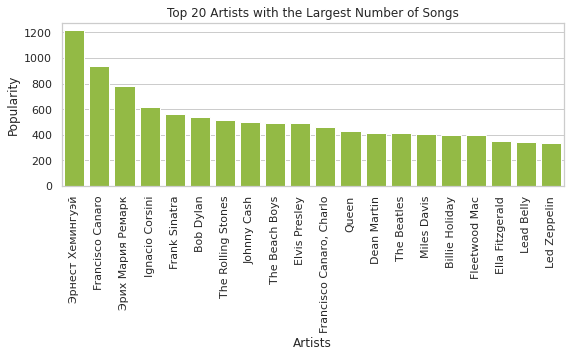

In [138]:
#Number of Songs per Artist 
plt.figure(figsize=(9, 3))
sns.set(style="whitegrid")
x = df.groupby("artists")["popularity"].count().sort_values(ascending=False).head(20)
ax = sns.barplot(x.index, x,color=("yellowgreen"))
ax.set_title('Top 20 Artists with the Largest Number of Songs')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)


Artists with the largest collection of songs coming from older generations, which explains the fact that due to their experience, they tend to have more songs availables compared to younger artists. 

### 4.1.2 Top 20 Artists Based on Total Popularity of Songs

Text(0.5, 1.0, 'Top 20 Artists based on Collective Popularity of Songs')

Text(0, 0.5, 'Popularity')

Text(0.5, 0, 'Artists')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

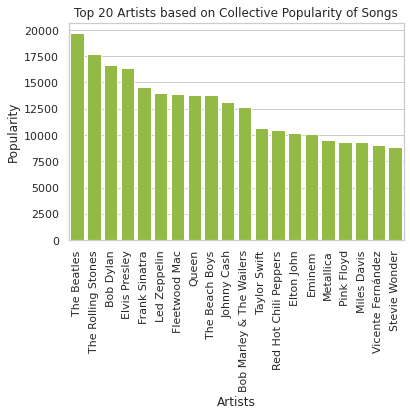

In [139]:
#Top artists based on total popularity of songs
sns.set(style="whitegrid")
x = df.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x.index, x,color=("yellowgreen"))
ax.set_title('Top 20 Artists based on Collective Popularity of Songs')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)

The Beatles are recognized as one of the top most popular artists, followed by The Rolling Stones and Bob Dylan.This could be related to the number of songs they have on Spotify as this chart is based on the total popularity score of their songs. To get a better insight, analysis will be done on the mean popularity score.

### 4.1.3 Top 20 Artists based on Average Popularity of Songs

<Figure size 648x216 with 0 Axes>

Text(0.5, 1.0, 'Top 20 Artists based on Average Popularity of Songs')

Text(0, 0.5, 'Popularity')

Text(0.5, 0, 'Artists')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

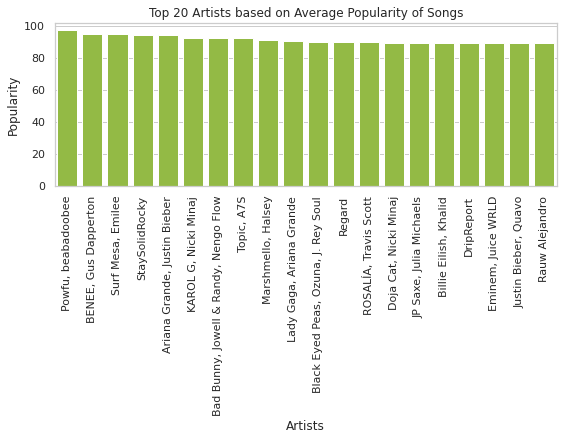

In [140]:
#Most Popular Artists based on their average popluarity of songs 
# pop_ar_year = pd.DataFrame(df.groupby('artists')['popularity'].mean()).sort_values('popularity',ascending=False).reset_index()
# pop_ar_year.head(20)
plt.figure(figsize=(9, 3))
sns.set(style="whitegrid")
x = df.groupby("artists")["popularity"].mean().sort_values(ascending=False).head(20)
ax = sns.barplot(x.index, x, color=("yellowgreen"))
ax.set_title('Top 20 Artists based on Average Popularity of Songs')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)

The top 20 artists are more recent artists. By using the mean popularity is based on recency more than a number of songs. 

### 4.1.4 Top 20 Artists based on Total Popularity Score for Songs Released After 2006

Text(0.5, 1.0, 'Top 20 Artists based on Total Popularity of Songs')

Text(0, 0.5, 'Popularity')

Text(0.5, 0, 'Artists')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

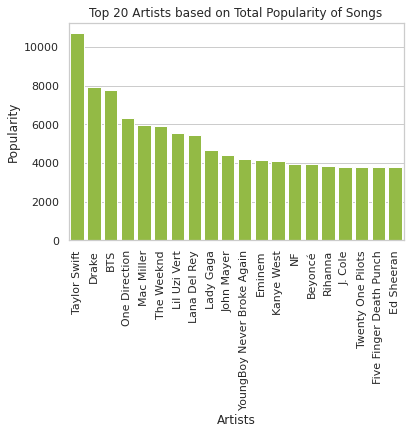

In [141]:
#1st we get all songs popularity from year 2006 to 2020 since spotify started
allpopular_songs_year2006 = df.sort_values('popularity', ascending=False)
allpopular_songs_year2006 = allpopular_songs_year2006[allpopular_songs_year2006.year > 2005]
allpopular_songs_year2006= allpopular_songs_year2006[['artists', 'name', 'popularity', 'year']]
#allpopular_songs_year2006.head(20)
#allpopular_songs_year2006.shape

#2nd group by artists and sum the popularity score of their songs
pop_ar_year2006 = pd.DataFrame(allpopular_songs_year2006.groupby('artists')['popularity'].sum()).sort_values('popularity',ascending=False).reset_index()
# pop_ar_year2006.head(20)
# pop_ar_year2006.shape

sns.set(style="whitegrid")
x = allpopular_songs_year2006.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x.index, x,color=("yellowgreen"))
ax.set_title('Top 20 Artists based on Total Popularity of Songs')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)

Taylor Swift is beating the chart with the highest score among others, by a significant gap in terms of popularity compared to the rest of the artists. 

### 4.1.5 Top 20 Artists based on the Average Popularity of Songs Released After 2006

Text(0.5, 1.0, 'Top 20 Artists with Songs released after 2006 ')

Text(0, 0.5, 'Popularity')

Text(0.5, 0, 'Artists')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

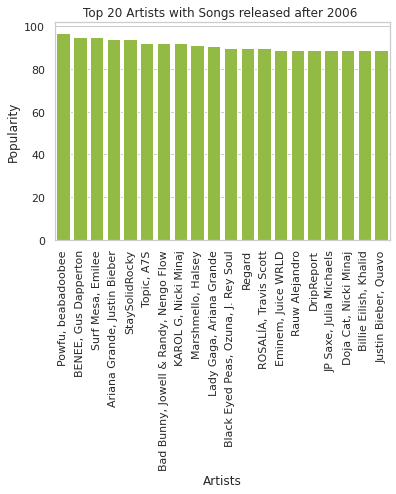

In [142]:
#artists with best mean popularity from year 2006 to 2020 since spotify started
# pop_ar_year2006 = pd.DataFrame(allpopular_songs_year2006.groupby('artists')['popularity'].sum()).sort_values('popularity',ascending=False).reset_index()
# pop_ar_year2006.head(20)
# # pop_ar_year2006.shape
sns.set(style="whitegrid")
x = allpopular_songs_year2006.groupby('artists')['popularity'].mean().sort_values(ascending=False).head(20)
ax = sns.barplot(x.index, x,color=("yellowgreen"))
ax.set_title('Top 20 Artists with Songs released after 2006 ')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)

The top recent artists have almost the same popularity score with no significant difference between them. Further analysis is needed.

## 4.2 Songs Analysis



###  4.2.1 Most Popular Songs on Spotify

In [143]:
#Most Popular Songs currently on Spotify?
popular_songs = df.sort_values('popularity', ascending=False)
popular_songs=popular_songs[['name','artists', 'popularity', 'year']]
popular_songs.head(10)

,name,artists,popularity,year
61855,Blinding Lights,The Weeknd,100,2020
61853,ROCKSTAR (feat. Roddy Ricch),"DaBaby, Roddy Ricch",99,2020
61862,death bed (coffee for your head) (feat. beabad...,"Powfu, beabadoobee",97,2020
61854,THE SCOTTS,"THE SCOTTS, Travis Scott, Kid Cudi",96,2020
61765,ily (i love you baby) (feat. Emilee),"Surf Mesa, Emilee",95,2019
61753,The Box,Roddy Ricch,95,2019
61757,Supalonely,"BENEE, Gus Dapperton",95,2019
61859,Toosie Slide,Drake,95,2020
61864,GOOBA,6ix9ine,94,2020
61866,Stuck with U (with Justin Bieber),"Ariana Grande, Justin Bieber",94,2020


From the analysis above, people tend to listen to the newly released tracks and of those the majority were released in 2020, with only few in 2019. The Weekend is leading the chart, followed by DaBaby and Powfu.

### 4.2.2 Most Popular Song for Each Release Year 

In [144]:
#Most Popular Songs for each release year 
popular_songs_year = df.sort_values('popularity', ascending=False).groupby('year').first()
popular_songs_year = popular_songs_year.reset_index()
popular_songs_year = popular_songs_year[['year','name','artists', 'popularity']]
popular_songs_year = popular_songs_year.sort_values('popularity', ascending=False)
popular_songs_year.head(5)


,year,name,artists,popularity
99,2020,Blinding Lights,The Weeknd,100
98,2019,ily (i love you baby) (feat. Emilee),"Surf Mesa, Emilee",95
97,2018,Falling,Trevor Daniel,92
95,2016,goosebumps,Travis Scott,92
94,2015,Play Date,Melanie Martinez,91


The weekend being top for the most popular song 2020. The 2nd and 3rd places are taken by Surf Mesa and Travis Scott being top performers for 2019 and 2018 respectively. 

### 4.2.3 Top Popularity Score for Each Release Year



<Figure size 2160x720 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

Text(0.5, 1.0, 'The Top Popularity Score Per Year ')

Text(0, 0.5, 'Popularity')

Text(0.5, 0, 'Year')

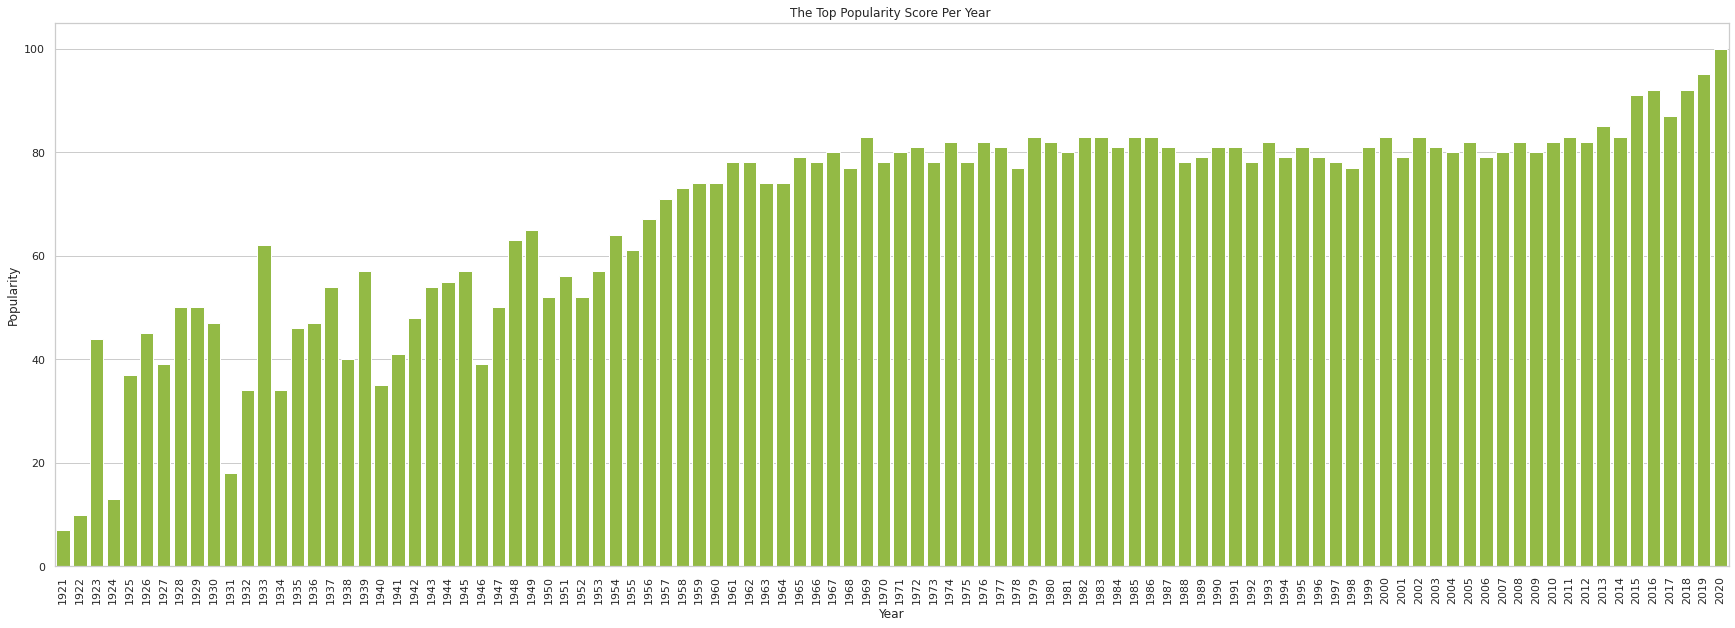

In [145]:
#The popularity of a song for each year of release
sns.set(style="whitegrid")
plt.figure(figsize = (30,10))
plt.xticks(rotation=90)

ax = sns.barplot(x='year', y='popularity', color=("yellowgreen"), data =popular_songs_year)
ax.set_title('The Top Popularity Score Per Year ')
ax.set_ylabel('Popularity')
ax.set_xlabel('Year')

Some songs from the 60’s are still popular but the popularity score drastically increases as we move towards the recent years.

### 4.2.4 The Top Popularity Score of Songs released after 2006

Based on the previous findings, it is clear that songs released recently are more popular compared to the older songs. To understand the differences in popularity among the recent songs, the analysis will focus on the songs released after the launch of Spotify in 2006. 

<Figure size 1440x720 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

Text(0.5, 1.0, 'The Top Popularity Score of Songs released after 2006 ')

Text(0, 0.5, 'Popularity')

Text(0.5, 0, 'Year')

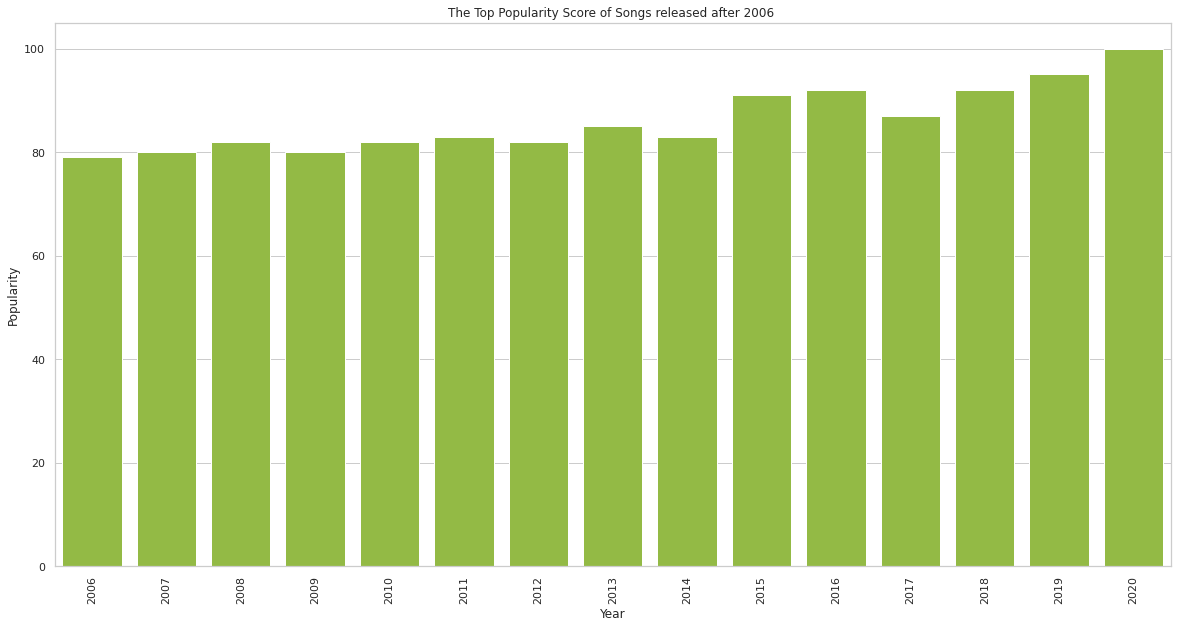

In [146]:
#1st we get all songs popularity from year 2006 to 2020 since spotify started
allpopular_songs_year2006 = df.sort_values('popularity', ascending=False)
allpopular_songs_year2006 = allpopular_songs_year2006[allpopular_songs_year2006.year > 2005]
allpopular_songs_year2006= allpopular_songs_year2006[['artists', 'name', 'popularity', 'year']]
# allpopular_songs_year2006.head(20)
# allpopular_songs_year2006.shape

#2nd we get the most popular song per year from year 2006 to 2020 since spotify started
popular_songs_year2006=allpopular_songs_year2006.groupby('year').first().reset_index()
# popular_songs_year2006.head(20)
# popular_songs_year2006.shape

sns.set(style="whitegrid")
plt.figure(figsize = (20,10))
plt.xticks(rotation=90)
ax = sns.barplot(x='year', y='popularity', color=("yellowgreen"), data =popular_songs_year2006)
ax.set_title('The Top Popularity Score of Songs released after 2006 ')
ax.set_ylabel('Popularity')
ax.set_xlabel('Year')



Songs in year 2020 are the most popular, but the differences in popularity of songs from 2006 till 2019 are not that significant.

### 4.2.5 The Average Popularity Score of Songs released after 2006 per year

In [147]:
#Get only the year groups and average popularity of songs for that year
popularity_by_year = df[['year','popularity']]
popularity_by_year = popularity_by_year.groupby(popularity_by_year['year']).mean().reset_index().tail(15)
#reset_index() is done to have it so the year groups are reset - we can then use them as an x column to plot after
popularity_by_year
#popularity_from_2006 = popularity_by_year[-15:]
#popularity_from_2006


,year,popularity
85,2006,50.631000
86,2007,50.708500
87,2008,50.522000
88,2009,51.360000
89,2010,52.763500
90,2011,53.184000
91,2012,54.340000
92,2013,55.691500
93,2014,56.964500
94,2015,59.547903


Text(0.5, 0, 'Year')

Text(0, 0.5, 'Average popularity of songs')

Text(0.5, 1.0, 'Average Popularity of Songs')

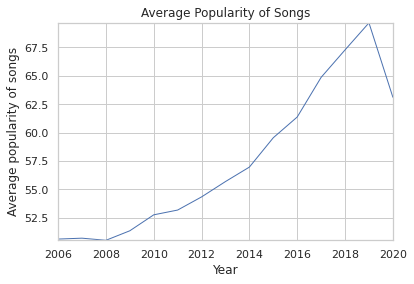

In [148]:
#Analyzing the trend with the line graph:
popularity_plt = plt.plot(popularity_by_year['year'],
                          popularity_by_year['popularity'],
                          linewidth = 1)
plt.xlabel('Year') # add labels to the axes
plt.ylabel('Average popularity of songs')
plt.title("Average Popularity of Songs")
plt.margins(0,0) #zoom into graph
popularity_plt

The average popularity of songs begins to increase sharply from 2008 to 2019, with a slight decrease after. Due to the fact that dataset constains data for the 1st 5 month of 2020 only, it is reasonable to assume that this factor might cause the decrease.


### 4.2.6 The Average Songs Popularity and Energy by Months

In [149]:
# to create the dataframe with variables "popularity" and "energy" grouped by months
popular_songs = df[df['popularity'] >= 70]
df['release_date'] = pd.to_datetime(df['release_date'])

p_by_months = popular_songs.groupby(df['release_date'].dt.strftime('%B'))[['popularity','energy']].mean().sort_index().reset_index()

p_by_months['month#'] = np.where(
    p_by_months['release_date'] == 'January',1, np.where(
    p_by_months['release_date'] == 'February',2, np.where(
    p_by_months['release_date'] == 'March',3, np.where(
    p_by_months['release_date'] == 'April',4, np.where(
    p_by_months['release_date'] == 'May',5, np.where(
    p_by_months['release_date'] == 'June',6, np.where(
    p_by_months['release_date'] == 'July',7, np.where(
    p_by_months['release_date'] == 'August',8, np.where(
    p_by_months['release_date'] == 'September',9, np.where(
    p_by_months['release_date'] == 'October',10, np.where(
    p_by_months['release_date'] == 'November',11, np.where(
    p_by_months['release_date'] == 'December',12, 0))))))))))))

p_by_months = p_by_months.sort_values('month#')
p_by_months

,release_date,popularity,energy,month#
4,January,73.684783,0.645239,1
3,February,74.851852,0.641420,2
7,March,75.549751,0.616281,3
0,April,74.564767,0.620317,4
8,May,74.476540,0.649543,5
6,June,74.571031,0.648008,6
5,July,73.696429,0.660133,7
1,August,74.443820,0.612659,8
11,September,74.166667,0.647067,9
10,October,74.549296,0.614825,10


<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Songs Popularity Over Months')

Text(0, 0.5, 'value')

<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Songs Energy Over Months')

Text(0, 0.5, 'energy')

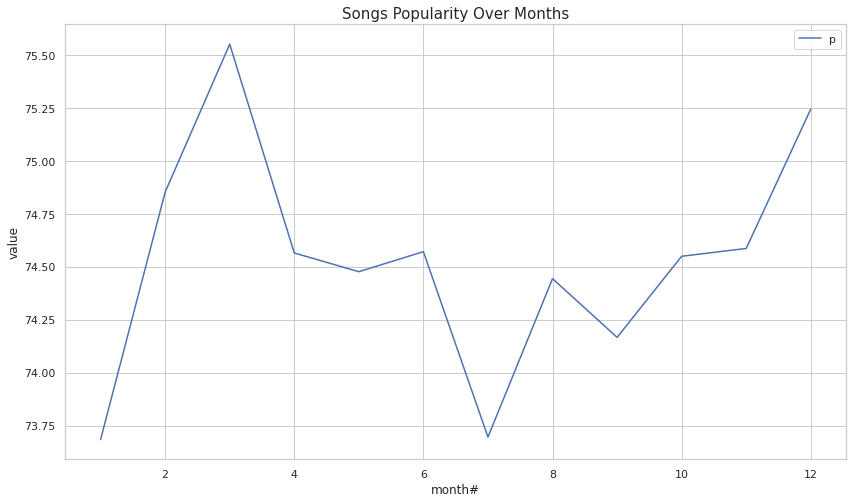

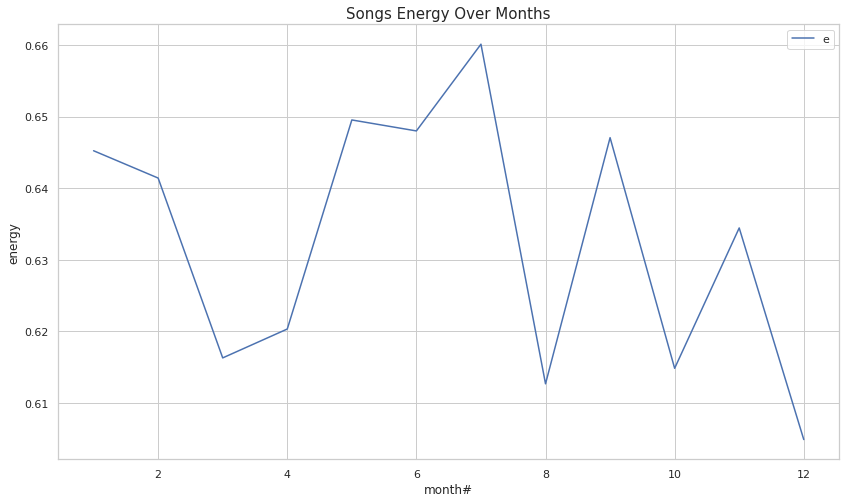

In [150]:
# popularity
plt.figure(figsize=(14,8))
plt.title("Songs Popularity Over Months", fontdict={"fontsize": 15})
ax = sns.lineplot(x='month#', y='popularity', data=p_by_months)  
plt.ylabel("value")
plt.legend('popularity')

# energy
plt.figure(figsize=(14,8))
plt.title("Songs Energy Over Months", fontdict={"fontsize": 15})

ax = sns.lineplot(x='month#', y='energy', data=p_by_months) 
plt.ylabel("energy")
plt.legend('energy')

1. On average, songs released in March tend to be more popular. <br>This might be due to various music festivals taking place in the spring. Thus, new songs have additional promotion platform. 
2. More energetic songs are released from May to July. <br>It might be caused by the seasonal summer holidays.

### 4.2.7 The Most Common Chords 

<BarContainer object of 12 artists>

Text(0.5, 1.0, 'What is the most common chord?')

Text(0.5, 0, 'note')

Text(0, 0.5, 'Frequency')

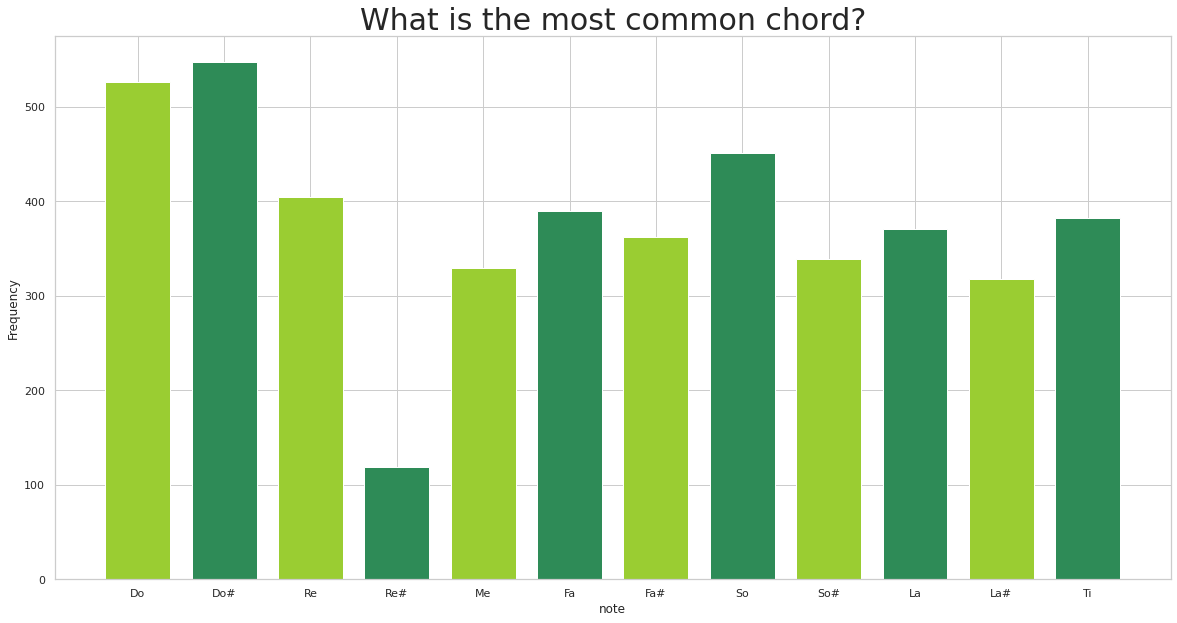

In [151]:
notes = pd.DataFrame(popular_songs['key'].value_counts()).reset_index().sort_values('index')
notes.replace({'index' : { 0 : 'Do', 1 : 'Do#', 2 : 'Re', 3 : 'Re#', 4 : 'Me', 5 : 'Fa', 6 : 'Fa#', 
                        7 : 'So', 8 : 'So#', 9 : 'La', 10 : 'La#', 11 : 'Ti'}} , inplace=True)
fig = plt.figure(figsize=(20,10))
plt.bar(notes['index'],notes['key'],color = ['yellowgreen','seagreen'],width=0.75)
plt.title('What is the most common chord?',fontsize = 30); plt.xlabel('note'); plt.ylabel('Frequency')

The majority of songs revolve around Do major, Do minor, and So major. The popularity of these keys can be explained by the fact that it is easier to play a song on the piano and guitar using these keys.

## 4.3 Audio Features Analysis


### 4.3.1 Audio Features Trend Analysis


<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Song Trends Over Time')

Text(0, 0.5, 'value')

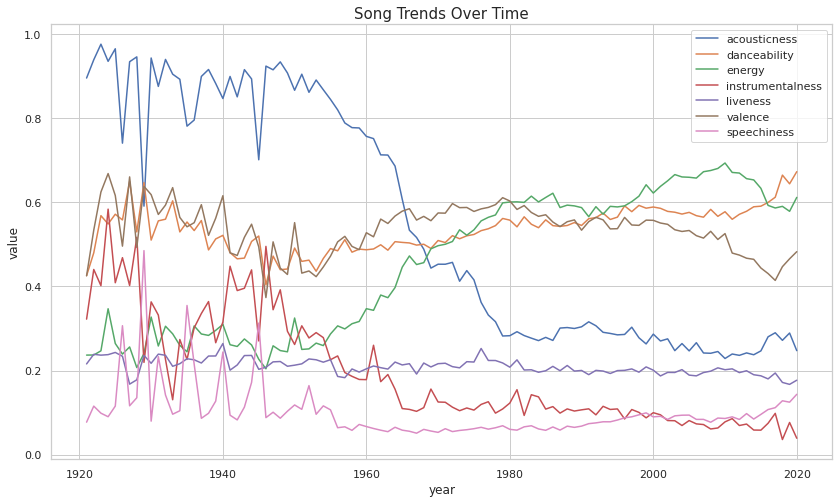

In [152]:
year_avg = df[["acousticness","danceability","energy", "instrumentalness", 
               "liveness","tempo", "valence", "loudness", "speechiness", "year"]].\
groupby("year").mean().sort_values(by="year").reset_index()

#year_avg.head()
# Create a line plot
plt.figure(figsize=(14,8))
plt.title("Song Trends Over Time", fontdict={"fontsize": 15})

lines = ["acousticness","danceability","energy", 
         "instrumentalness", "liveness", "valence", "speechiness"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)  
    
plt.ylabel("value")
plt.legend(lines)



1- Songs acousticness has decreased significantly from 1921 to 2020, this may be caused by technology advancements over the years as most songs now are recorded electrically with less noise and more clarity. 

2- The trend of the energy of the songs, is the opposite to the acousticness. It has increased over the years, specifically  after 2000, it might lead to the fact that the market is focused on fast-paced and loud songs. 

3- Instrumentalness of songs is also decreasing, the trend in the music industry recently is more focused on songs with vocals included.


### 4.3.2 Audio Features Correlation Analysis

#### Audio Features Correlation Analysis Songs released between 1921 and 2020

<Figure size 1080x576 with 0 Axes>

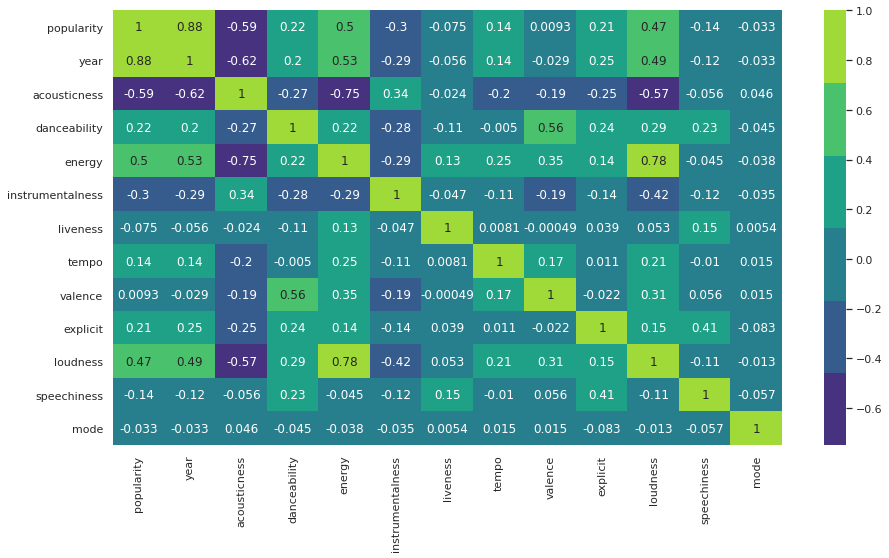

In [153]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
corr = df[["popularity","year","acousticness","danceability","energy", "instrumentalness", 
           "liveness","tempo", "valence",'explicit', "loudness", "speechiness",'mode']].corr()
cmap=sns.color_palette("viridis")
sns.heatmap(corr,annot=True, cmap=cmap)


The correlation table highlights insights to factors that contribute to songs popularity:

1- Recency: The popularity is highly correlated with the year of release. It is clear that the Spotify algorithm puts a high weight on the recency of the song.

2- Energy: The energy of the song is positively correlated with it's popularity score. Many of the popular songs are more energetic.

3- Acousticness: The acousticness of a song is negatively correlated with it's popularity. Most popular songs have higher energy and loudness which is negatively correlated with the song being more instrumental or acoustic.

4- Loudness and energy are highly correlated and both are positively correlated with popularity.

5- Valence and danceability are highly correlated. Valence measures how positive a song is. Dance songs are usually positive and happy songs.


#### Audio Features Correlation Analysis songs released between 2006 and 2020
Since recency has an important impact on the popularity of songs, further analysis is done on more recent songs starting 2006

<Figure size 1080x576 with 0 Axes>

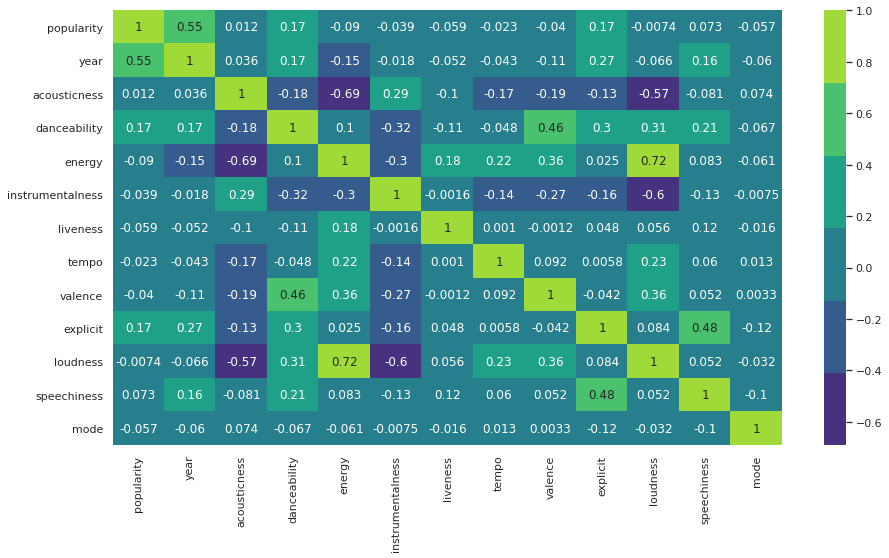

In [154]:
#for songs released after 2006
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
dfover2006 = df[df['year'] >= 2006]

corr = dfover2006[["popularity","year","acousticness","danceability","energy", "instrumentalness", 
           "liveness","tempo", "valence", 'explicit',"loudness", "speechiness",'mode']].corr()
cmap=sns.color_palette("viridis")
sns.heatmap(corr,annot=True, cmap=cmap)

Recency: still has the strongest correlation with popularity compared to the other audio features. 

The impact of dancability and explicitness is the 2nd strongest after recency and it might seem that dancable and explicit songs have higher popularity scores.

The impact of energy, acousticness, loudness is not significant as it seems that most of the songs released after 2006 follow the same trend. 


### 4.3.3 Analyzing the Relationship of Audio Features  & Popularity

Alternative visualisation of the relationships via the scatter plots:

Text(0.5, 1.0, 'Relation between year and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'year')

Text(0.5, 1.0, 'Relation between acousticness and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'acousticness')

Text(0.5, 1.0, 'Relation between danceability and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'danceability')

Text(0.5, 1.0, 'Relation between energy and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'energy')

Text(0.5, 1.0, 'Relation between instrumentalness and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'instrumentalness')

Text(0.5, 1.0, 'Relation between liveness and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'liveness')

Text(0.5, 1.0, 'Relation between tempo and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'tempo')

Text(0.5, 1.0, 'Relation between valence and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'valence')

Text(0.5, 1.0, 'Relation between explicit and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'explicit')

Text(0.5, 1.0, 'Relation between loudness and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'loudness')

Text(0.5, 1.0, 'Relation between speechiness and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'speechiness')

Text(0.5, 1.0, 'Relation between mode and Popularity')

Text(0.5, 0, 'Popularity')

Text(0, 0.5, 'mode')

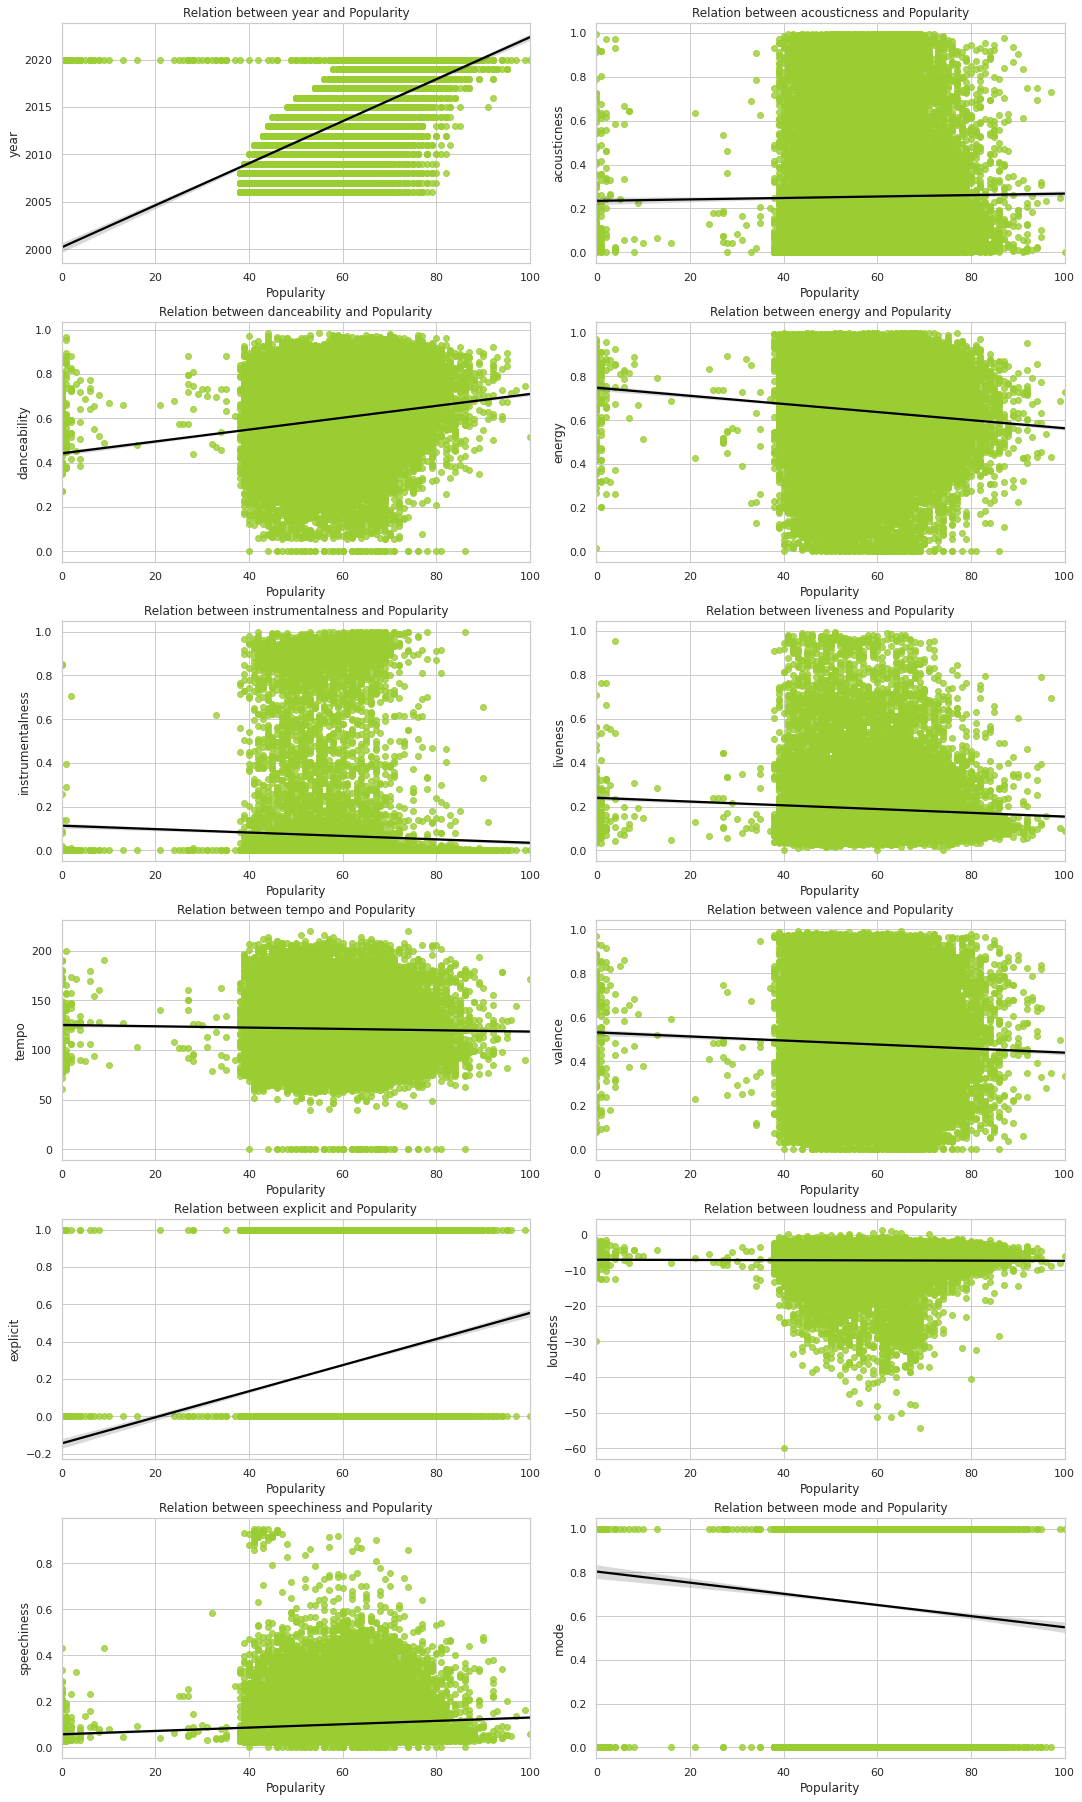

In [155]:
# Relationship between song features and Popularity from 2006 to 2020
df2006 = df[df['year'] >= 2006]
features = ["year","acousticness","danceability","energy", "instrumentalness", 
           "liveness","tempo", "valence", 'explicit',"loudness", "speechiness",'mode']
#year = range(2006,2021)
figure = plt.figure(figsize=(15,25))
for variable,num in zip(features, range(1,len(features)+1)):
    ax = figure.add_subplot(6,2,num)
    #sns.regplot('popularity',variable, line_kws={"color": "red"},data=relation)
    sns.regplot('popularity',variable,scatter_kws={"color": "yellowgreen"}, line_kws={"color": "black"},data=df2006)
    plt.title('Relation between {} and Popularity'.format(variable))
    plt.xlabel('Popularity')
    plt.ylabel(variable)
figure.tight_layout(pad=0.5)

The above scatter plots representation confirms the previous analysis on the correlation matrix.

### 4.3.4 Explicit Content Ratio for Songs Released After 2006

One of the insights of the previous analysis on audio features released after 2006, was that explict songs have higher popularity score. Below is a break down of the percentage of songs with explicit content on Sportify. 

Text(0.5, 1.1, 'Explicit Content Ratio')

(-1.1201500470637107,
 1.1056152969285726,
 -1.1196179845013734,
 1.100934216135549)

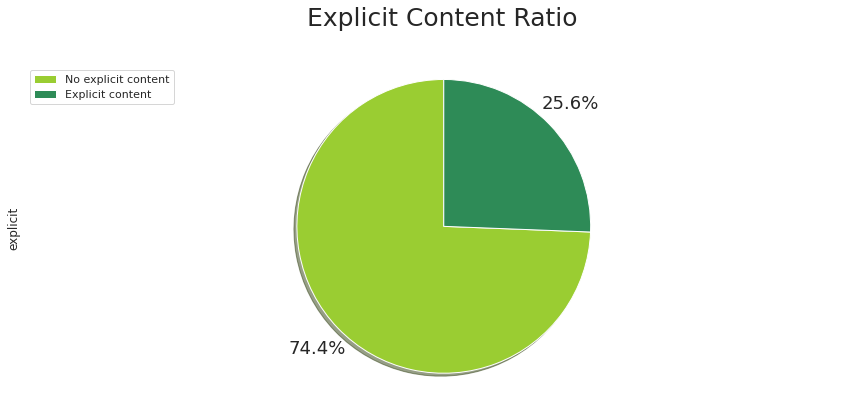

In [159]:
# colors_list = ['#fdc500','#00509d']
colors_list =['yellowgreen','seagreen']
mpl.rcParams['font.size'] = 18.0
ex = pd.DataFrame(new_data['explicit'].value_counts())
ex['explicit'].plot(kind='pie',
            figsize=(15, 6),
            autopct='%1.1f%%', 
            startangle=90,  
            shadow=True,       
            labels=None,    
            pctdistance=1.2, 
            colors=colors_list,
            )

plt.title('Explicit Content Ratio',y=1.1,fontsize=25) 
plt.axis('equal') 
plt.legend(labels=['No explicit content','Explicit content'], loc='upper left') 
plt.show()

- From the graph above we could find clear difference in explicit attribute. 74.4% of music from 2006 are non-explicit contents, with only 25.6% of music being explict.

### 4.3.5 Analyzing  Distribution of Audio Features  released after 2006

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5933f8d5e0>,
      dtype=object)

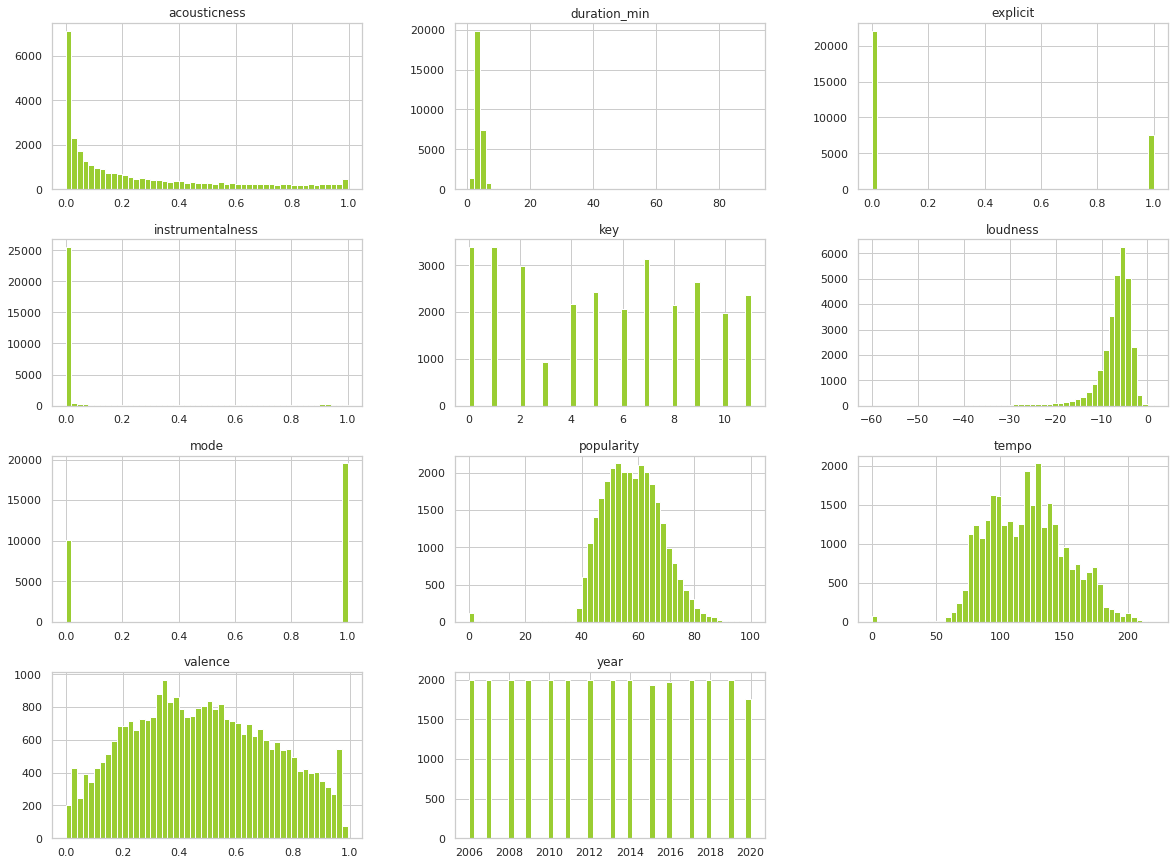

In [160]:
# The histogram distribution of all attributes from 2006 - 2020 
#From the graph below we could find all the attributes distribution from 2006 to 2020 for all songs.
new_data[list(set(new_data.columns.values)-set(["danceability","speechiness","liveness","energy"]))].hist(bins=50, figsize=(20, 15), color="yellowgreen")

Analyzing the distribution of the audio features before regression analysis:


- For acousticness and speechiness, there is a clear decreasing trend starting from zero for both attributes, which means that most songs are not acoustic and not spoken tracks.
- For danceability, loudness and energy, these three attributes are all left-skewed distributed. It shows that most songs are prefered to be made more danceable, loud and with high energy.
- For instrumentalness, zero possesses dominant shares, which means that most music include vocal contents.
- For liveness and speechiness with right-skewed distribution,  showed that most contents in Spotify are not performed live and are not speechess, audiobooks or similar contents.
- For tempo and valence, these two attributes distributed alike, with the median at 125 and 0.5 respectively.

# 5. Linear Regression Model

After highlighted the correlations between variables independently and checking the distribution of the data set, Multiple regression analysis is performed for the below variables against popularity to examine the significance of the relationship.

How popularity is affected by the following features :
- Year
- Valence
- Loudness
- Acousticness
- Energy
- Dancability
- Explicity
- Tempo
- Instrumentalness
- Speechiness
- Liveliness

#### Audio Features Regression Analysis for songs released between 1921 and 2020


In [161]:
#This section below is dedicated to the multiple regression bit.
# Variables
X = df[['year','valence','loudness','acousticness', 'energy','danceability','explicit','tempo','instrumentalness','speechiness','liveness']]
Y = df['popularity']
X = sm.add_constant(X)


vcvtype = 'nonrobust'
# Regression 
model = sm.OLS(Y, X)
results = model.fit(cov_type=vcvtype)
print(results.summary())


#to check multicolliniarity 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 5.602e+04
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:29:43   Log-Likelihood:            -6.3278e+05
No. Observations:              169879   AIC:                         1.266e+06
Df Residuals:                  169867   BIC:                         1.266e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1319.3301      2.738  

,VIF Factor,features
0,12647.5,const
1,2.1,year
2,2.0,valence
3,3.2,loudness
4,3.0,acousticness
5,4.9,energy
6,2.0,danceability
7,1.4,explicit
8,1.1,tempo
9,1.4,instrumentalness


The results of the regression for the popularity based on the above variables highlights an R-squared value of 0.784, indicating that 78.4% of the values in the dataset can be predicted by this model.

#### Audio Features Regression Analysis for songs released after 2006 to 2020

In [162]:
#after 2006
allpopular_songs_year2006 = df.sort_values('popularity', ascending=False)
allpopular_songs_year2006 = allpopular_songs_year2006[allpopular_songs_year2006.year > 2005]

# Variables
X = allpopular_songs_year2006[['year','valence','loudness','acousticness', 'energy','danceability','explicit','tempo','instrumentalness','speechiness','liveness']]
Y = allpopular_songs_year2006['popularity']
X = sm.add_constant(X)


vcvtype = 'nonrobust'
# Regression 
model = sm.OLS(Y, X)
results = model.fit(cov_type=vcvtype)
print(results.summary())


#to check multicolliniarity 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     1217.
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:29:50   Log-Likelihood:            -1.0680e+05
No. Observations:               29656   AIC:                         2.136e+05
Df Residuals:                   29644   BIC:                         2.137e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2609.9212     25.793  

,VIF Factor,features
0,250900.4,const
1,1.1,year
2,1.6,valence
3,3.4,loudness
4,2.1,acousticness
5,3.5,energy
6,1.8,danceability
7,1.5,explicit
8,1.1,tempo
9,1.7,instrumentalness


After 2006, we can see that the R-squared value is 0.311. 
This value shows that only 31.1% of the variance in the dataset can be predicted by this model. 
Compared to our initial findings from previous multiple regression - there is a significant difference.

# 6. Popularity Prediction Model

### Decision Tree

In [47]:
# to remove extra columns 
df = df.drop(['artists','id','name','release_date'],axis=1)

# to split the dataframe into separate data sets for train and test (80/20)
train_data, test_data = np.split(df.sample(frac=1, random_state=0),[int(.8*len(df))])

# to defined dependent and independent variables
Y_train = train_data['popularity']
Y_test = train_data['popularity']
X_train = train_data.drop(['popularity'], axis=1)
X_test = train_data.drop(['popularity'], axis=1)

tree = DecisionTreeRegressor(max_leaf_nodes=50, min_samples_split=2000)
tree.fit(X_train, Y_train)
predict_test = tree.predict(X_test).clip(0, 1)
RMSE_test = (mse(Y_test, predict_test))**(1/2)
print('RMSE = ', round(RMSE_test,2))

DecisionTreeRegressor(max_leaf_nodes=50, min_samples_split=2000)

RMSE =  37.37


### Random Forest

In [48]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train,Y_train)
predict_test = forest_model.predict(X_test)

# to evaluate accuracy of the model
RMSE = (mean_squared_error(Y_test, predict_test))**(1/2)
print('RMSE = ', round(RMSE,2))

RandomForestRegressor(random_state=1)

RMSE =  3.47


Based on the RMSE of the two models, the random forest model is able to fit a dataset much better and quite well.

# 7. Summary

One key finding is the effect of year of release on both regression models - Recency has a very strong effect on popularity This is reinforced by our findings in the dataset - recent artists are on average more popular than older artists. 

A possible explanation for recency being so important is due to Spotify's algorithm, where they actively promote more recent songs over older songs. This also allowed for smaller artists and label groups to gain popularity over major label groups. (Prey, Del Valle, Zwerwer, 2020)

Over time, energetic electronic songs with vocals have been more popular, with acousticness and instrumentalness dropping over time and energy increasing over time, which showcases that taste in music has been changing.

To conclude the findings of this analysis,artists interested in increasing the popularity of their songs on Spotify should:

1- Follow the trend of creating energetic and fast paced songs with loud mix in the background.

2- Focus on creating dance oriented songs.

3- Avoid creating highly acoustic songs.

4- Include vocals and avoid too much instrumentalness.


# 8. References 
1. BBC News. 2018. How Spotify Came To Be Worth Billions. [online] Available at: <https://www.bbc.co.uk/news/newsbeat-43240886> [Accessed 12 December 2020].
2. Prey, R., Del Valle, M. and Zwerwer, L., 2020. Platform Pop: Disentangling Spotify’S Intermediary Role In The Music Industry. [online] Taylor & Francis. Available at: <https://www.tandfonline.com/doi/full/10.1080/1369118X.2020.1761859> [Accessed 12 December 2020].
3. Negus, K., 1992. Producing Pop: Culture And Conflict In The Popular Music Industry.
4. Spotify Usage and Revenue Statistics (2020) [Internet]. Business of Apps. 2020 [cited 14 December 2020]. Available from: https://www.businessofapps.com/data/spotify-statistics/#:~:text=during%20Q3%202018-,Spotify%20User%20Statistics,Premium%20subscribers%20in%20Q4%202019

# 9. Appendix

Further analysis was done and included in the appendix for reference. 

### Differences in danceability, speechiness, liveness and energy for songs with popularity score above 70 and below 70

From the correlation analysis results, we can saw that the correlation between the four characteristics of danceability, speechiness, liveness and energy and popularity is relatively high, so we conduct further distribution analysis to check the difference for songs with popularity above 70 and ones below 70.

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Danceability Comparison')

Text(0.5, 0, 'Danceability')

Text(0, 0.5, 'Distribution')

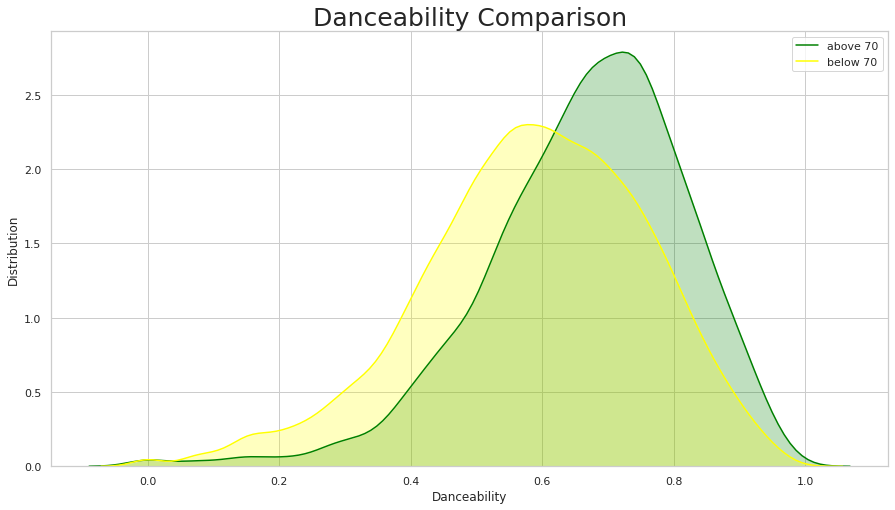

Danceability above 70: 0.6659273577124006
Danceability below 70: 0.5860346938775497


In [15]:
data = pd.read_table('data_clean.csv', delimiter=',')

new_data = pd.DataFrame(data[(data['year'] >= 2006) & (data['year'] <= 2020)])
new_data1 = new_data[new_data['popularity']>=70]
new_data2 = new_data[new_data['popularity']<70]

plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
sns.kdeplot(new_data1["danceability"],label="above 70",shade=True,color="green")
sns.kdeplot(new_data2['danceability'],label="below 70",shade=True,color="yellow")

plt.legend()
plt.title('Danceability Comparison',fontsize=25)
plt.xlabel("Danceability")
plt.ylabel("Distribution")
plt.savefig('')
plt.show()

print("Danceability above 70: "+str(np.mean(new_data1['danceability'])))
print("Danceability below 70: "+str(np.mean(new_data2['danceability'])))

From the above graph we can find that the distribution of this feature is left skewed and the mean value is around 0.658 for data with popularity above 70 and 0.587 for data with popularity below 70, which corresponds to the Danceability's correlation to popularity of 0.17.

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Speechiness Comparison')

Text(0.5, 0, 'Speechiness')

Text(0, 0.5, 'Distribution')

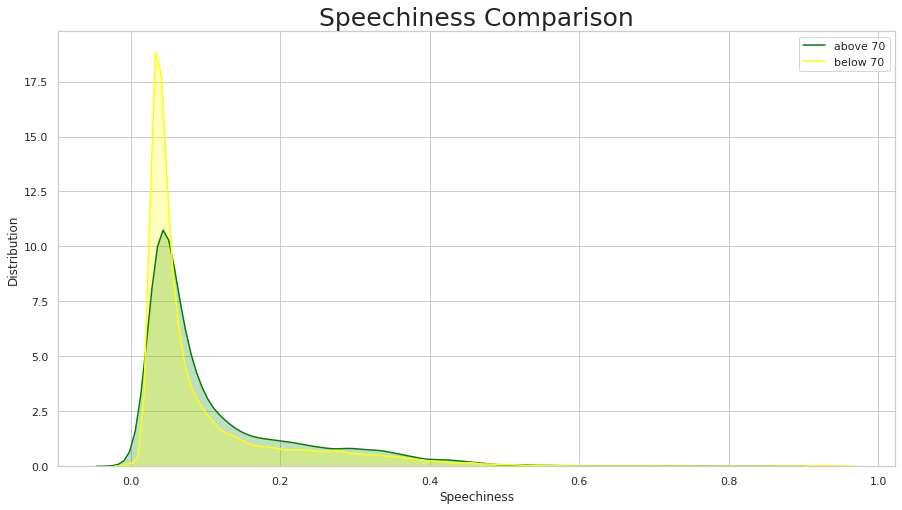

Speechiness above 70: 0.1129307396205664
Speechiness below 70: 0.09663332948998794


In [16]:
plt.figure(figsize=(15, 8))
sns.kdeplot(new_data1["speechiness"],label="above 70",shade=True,color="green")
sns.kdeplot(new_data2['speechiness'],label="below 70",shade=True,color="yellow")

plt.legend()
plt.title('Speechiness Comparison',fontsize=25)
plt.xlabel("Speechiness")
plt.ylabel("Distribution")
plt.savefig('')
plt.show()

print("Speechiness above 70: "+str(np.mean(new_data1['speechiness'])))
print("Speechiness below 70: "+str(np.mean(new_data2['speechiness'])))

From the above graph we can find that the feature is heavily distributed around 0. The mean value of speechiness with popularity above 70 is slightly higher than the mean value of speechiness with popularity below 70,  which corresponds to the Speechiness's correlation to popularity of 0.073.

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Liveness compare')

Text(0.5, 0, 'Liveness')

Text(0, 0.5, 'Distribution')

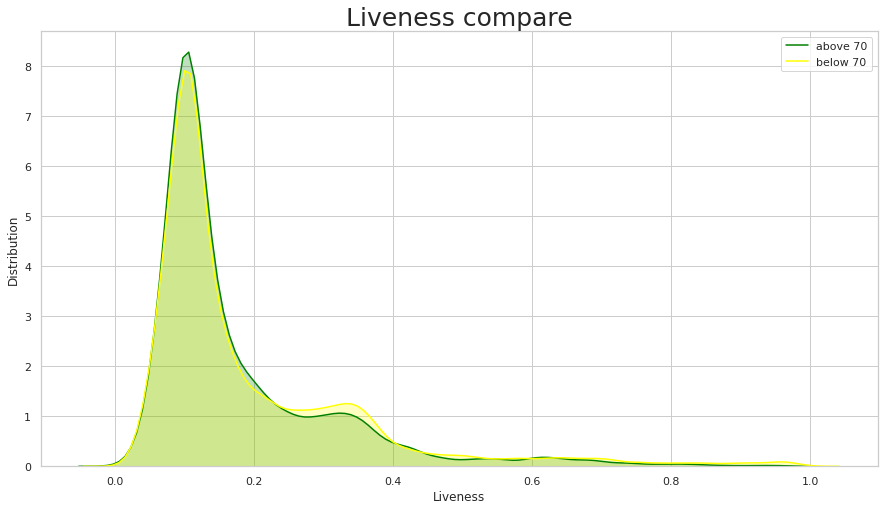

Liveness above 70: 0.17613038218311805
Liveness below 70: 0.19257481071524513


In [17]:
plt.figure(figsize=(15, 8))
sns.kdeplot(new_data1["liveness"],label="above 70",shade=True, color="green")
sns.kdeplot(new_data2['liveness'],label="below 70",shade=True, color="yellow")

plt.legend()
plt.title('Liveness compare',fontsize=25)
plt.xlabel("Liveness")
plt.ylabel("Distribution")
plt.savefig('')
plt.show()

print("Liveness above 70: "+str(np.mean(new_data1['liveness'])))
print("Liveness below 70: "+str(np.mean(new_data2['liveness'])))

The liveness characteristics showed a bimodal distribution, with most of the data distributed around 0.1, and the mean liveness of popularity level above 70 is slightly lower then the ones below 70,  which corresponds to the Liveness's correlation to popularity of -0.059.

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Energy Comparison')

Text(0.5, 0, 'Energy')

Text(0, 0.5, 'Distribution')

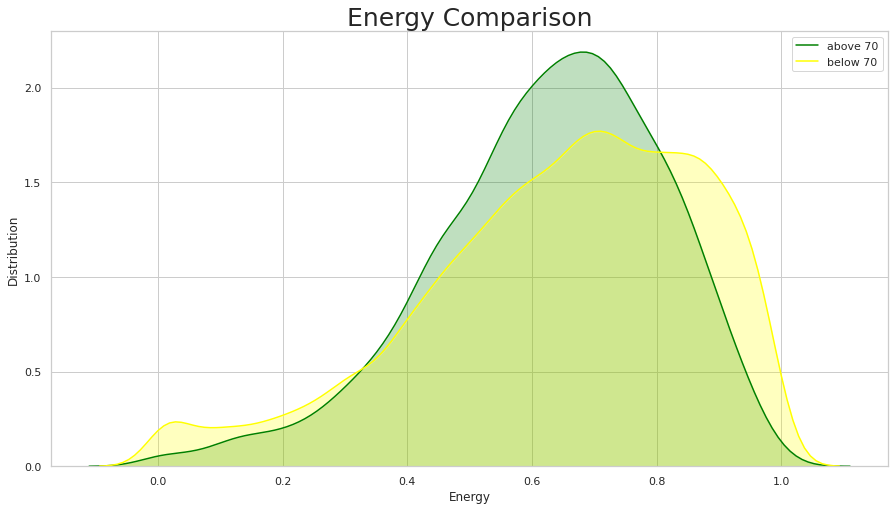

Energy above 70: 0.6261900294748418
Energy below 70: 0.6443136940620299


In [18]:
plt.figure(figsize=(15, 8))
sns.kdeplot(new_data1["energy"],label="above 70",shade=True,color="green")
sns.kdeplot(new_data2['energy'],label="below 70",shade=True,color="yellow")

plt.legend()
plt.title('Energy Comparison',fontsize=25)
plt.xlabel("Energy")
plt.ylabel("Distribution")
plt.savefig('')
plt.show()
print("Energy above 70: "+str(np.mean(new_data1['energy'])))
print("Energy below 70: "+str(np.mean(new_data2['energy'])))

The distribution of energy shows generally high values. The distribution of data with popularity above 70 ranges from 0.5 to 0.8 with mean value being 0.626, while the distribution of data with popularity below 70 ranges from 0.6 to 1.0 with mean value being 0.641. Popular songs tends to have relatively low energy, which corresponds to the Energy's correlation to popularity of -0.09.

# Limitations:

Despite the fact that Spotify is a well known and established platform among music providers we can not guarantee what part of population would or would not use it. Logically we can assume  that the age of Spotify users mainly varies between 10-50, even though we are capturing quite a wide range of potential users, we can also agree that it is not the whole population, hence we cannot draw any concrete conclusions and facts. 

Another  limitation to consider is the data range available. End of the end is fast approaching hence the provided data is represented only for the first couple of month of 2020, because of this fact it’s difficult to conclude any specific trends in music as short data availability makes the conclusion very biased.

The liveness characteristics showed a bimodal distribution, with most of the data distributed around 0.1, and the mean liveness of popularity level above 70 is slightly lower then the ones below 70,  which corresponds to the Liveness's correlation to popularity of -0.059.